In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Bidirectional, LSTM, concatenate, Flatten
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    
    # Define the first Densely Connected Bidirectional LSTM layer
    lstm_1 = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal', dropout=0.3))(inputs)
    lstm_1_batch_norm = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(lstm_1_batch_norm)
    lstm_1_dropout = Dropout(0.3)(lstm_1_LRelu)
    
    # Define the second Densely Connected Bidirectional LSTM layer
    lstm_2_input = concatenate([lstm_1, inputs], axis=2)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal', dropout=0.3))(lstm_2_input)
    lstm_2_batch_norm = BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(lstm_2_batch_norm)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    
    # Define the output layer
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()
    
    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
#         if(cur_gen_loss > 0.85):
#                 break;
    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "IBM"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2000-01-10  112.093689  114.125237  110.301147  112.810707   64.370804   
6    2000-01-11  112.691208  115.798279  111.496178  113.766731   64.916290   
7    2000-01-12  114.364243  116.634796  113.049713  114.244743   65.189049   
8    2000-01-13  114.663002  115.678780  110.659653  113.049713   64.507149   
9    2000-01-14  115.619026  117.889580  112.332695  114.364243   65.257225   
...         ...         ...         ...         ...         ...         ...   
5278 2020-12-23  118.432121  119.703636  118.298279  118.451241  106.144394   
5279 2020-12-24  119.502869  119.598473  118.747612  119.206497  106.821190   
5280 2020-12-28  119.598473  121.032501  118.986618  119.330788  106.932556   
5281 2020-12-29  119.837479  119.961761  117.820267  118.355644  106.058739   
5282 2020-12-30  118.355644  119.359467  118.193115  118.871895  106.521347   

        Volume          Ma  
5      8933363  109.285373  
6      8235472  109.667783  
7      7116775  110.994264  
8      8880226  111.663481  
9     11460604  112.476100  
...        ...         ...  
5278   2817819  119.302103  
5279   1842111  118.986615  
5280   3781499  118.822179  
5281   3647402  118.625238  
5282   3535794  118.703633  

[5278 rows x 8 columns]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 20)        1440        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 5, 27)        0           ['bidirectional[0][0]',          
                                                                  'input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20)          3040        ['concatenate[0][0]']        

Time for epoch 48 is 1.088524580001831 sec Generator Loss: 0.8643067479133606,  Discriminator_loss: 1.2913520336151123
Time for epoch 49 is 1.0976860523223877 sec Generator Loss: 0.8672242760658264,  Discriminator_loss: 1.2991665601730347
Time for epoch 50 is 1.1236538887023926 sec Generator Loss: 0.8626989126205444,  Discriminator_loss: 1.3041738271713257
Time for epoch 51 is 0.9573993682861328 sec Generator Loss: 0.8644897937774658,  Discriminator_loss: 1.304724931716919
Time for epoch 52 is 0.9597783088684082 sec Generator Loss: 0.8626875877380371,  Discriminator_loss: 1.3046183586120605
Time for epoch 53 is 0.9886817932128906 sec Generator Loss: 0.8661692142486572,  Discriminator_loss: 1.306167483329773
Time for epoch 54 is 1.057124376296997 sec Generator Loss: 0.8566382527351379,  Discriminator_loss: 1.3017085790634155
Time for epoch 55 is 0.9866824150085449 sec Generator Loss: 0.8473668098449707,  Discriminator_loss: 1.3140660524368286
Time for epoch 56 is 0.9729547500610352 sec 

Time for epoch 117 is 0.8885054588317871 sec Generator Loss: 0.7988057136535645,  Discriminator_loss: 1.3456910848617554
Time for epoch 118 is 0.884598970413208 sec Generator Loss: 0.8145788908004761,  Discriminator_loss: 1.3382517099380493
Time for epoch 119 is 0.908623218536377 sec Generator Loss: 0.8039649724960327,  Discriminator_loss: 1.347366452217102
Time for epoch 120 is 0.8943662643432617 sec Generator Loss: 0.8010132908821106,  Discriminator_loss: 1.3429170846939087
Time for epoch 121 is 0.9208629131317139 sec Generator Loss: 0.8003399968147278,  Discriminator_loss: 1.3392829895019531
Time for epoch 122 is 0.9126007556915283 sec Generator Loss: 0.810447633266449,  Discriminator_loss: 1.3437743186950684
Time for epoch 123 is 0.8988635540008545 sec Generator Loss: 0.7956268787384033,  Discriminator_loss: 1.3523454666137695
Time for epoch 124 is 0.9240238666534424 sec Generator Loss: 0.8067532181739807,  Discriminator_loss: 1.3371589183807373
Time for epoch 125 is 0.911249876022

Time for epoch 185 is 0.8645181655883789 sec Generator Loss: 0.7937185168266296,  Discriminator_loss: 1.3545167446136475
Time for epoch 186 is 0.9292802810668945 sec Generator Loss: 0.7956587672233582,  Discriminator_loss: 1.3497891426086426
Time for epoch 187 is 0.9698889255523682 sec Generator Loss: 0.7951292395591736,  Discriminator_loss: 1.3468797206878662
Time for epoch 188 is 0.9812986850738525 sec Generator Loss: 0.7928290963172913,  Discriminator_loss: 1.3550784587860107
Time for epoch 189 is 0.9984467029571533 sec Generator Loss: 0.7940799593925476,  Discriminator_loss: 1.3496696949005127
Time for epoch 190 is 1.1211237907409668 sec Generator Loss: 0.7898582816123962,  Discriminator_loss: 1.3501651287078857
Time for epoch 191 is 1.1141748428344727 sec Generator Loss: 0.8013343811035156,  Discriminator_loss: 1.3497750759124756
Time for epoch 192 is 1.0696382522583008 sec Generator Loss: 0.804961085319519,  Discriminator_loss: 1.3470542430877686
Time for epoch 193 is 1.133146286

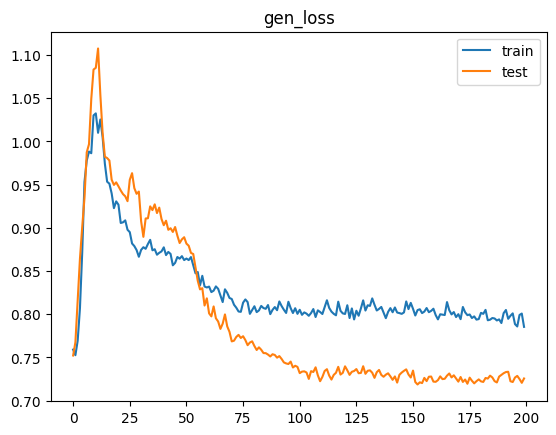

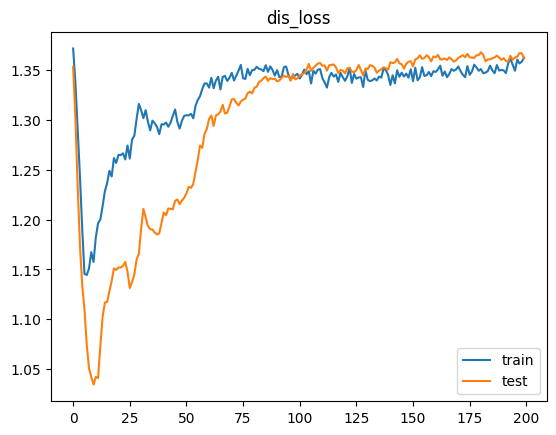

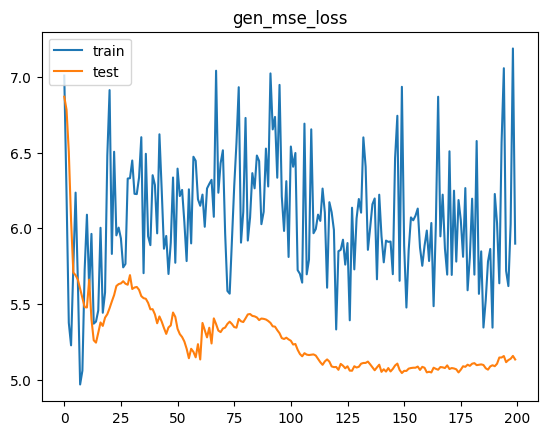

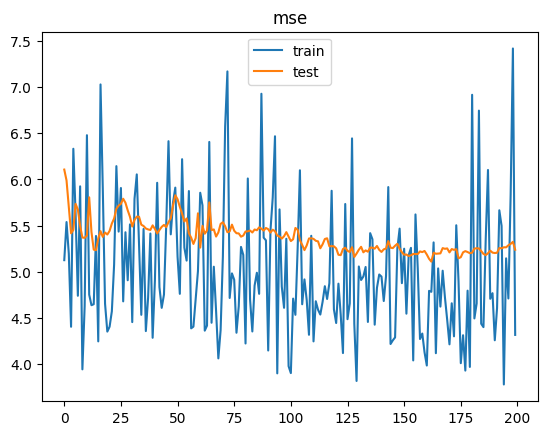

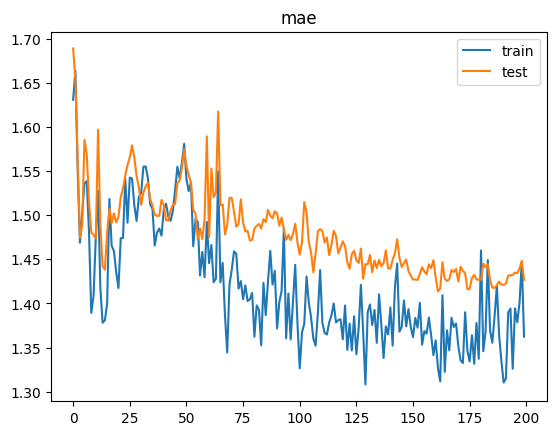

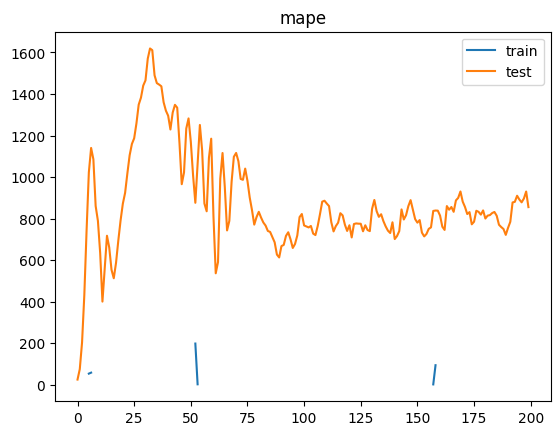

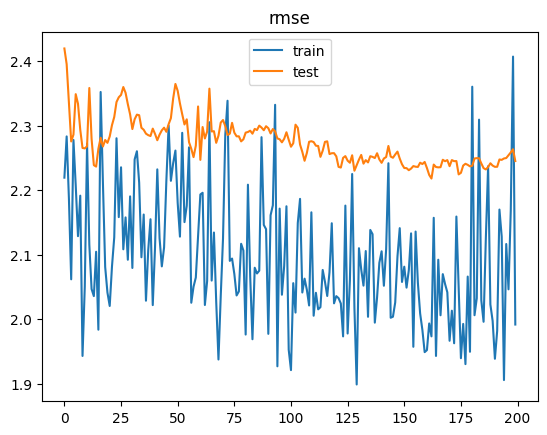

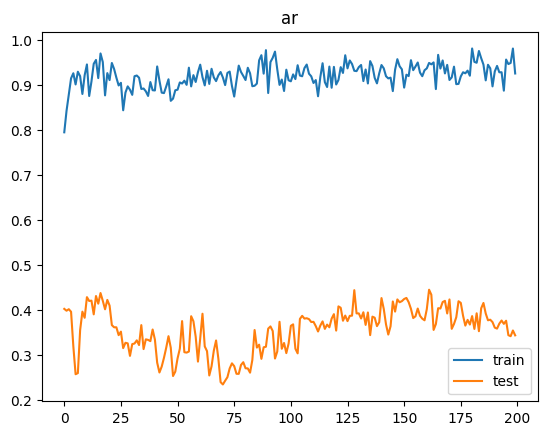

2/2 [==============================] - 1s 3ms/step


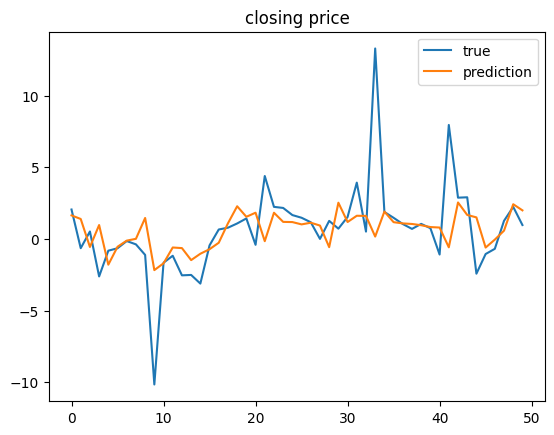

[MSE Baseline] train: 4.089966904517997  test: 4.988566607603537
Delta time with epochs = 200: 0:03:37.796759
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 5, 20)       1440        ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 5, 27)        0           ['bidirectional_2[0][0]',        
                                                                  'input_2[0][0]'

Time for epoch 46 is 1.1025981903076172 sec Generator Loss: 0.8171152472496033,  Discriminator_loss: 1.3403183221817017
Time for epoch 47 is 1.290696620941162 sec Generator Loss: 0.8224937915802002,  Discriminator_loss: 1.3291583061218262
Time for epoch 48 is 1.0677440166473389 sec Generator Loss: 0.8317083716392517,  Discriminator_loss: 1.3326388597488403
Time for epoch 49 is 0.9631972312927246 sec Generator Loss: 0.8143405914306641,  Discriminator_loss: 1.3396649360656738
Time for epoch 50 is 0.9547607898712158 sec Generator Loss: 0.8174989223480225,  Discriminator_loss: 1.335833191871643
Time for epoch 51 is 0.9609112739562988 sec Generator Loss: 0.8122999668121338,  Discriminator_loss: 1.3420754671096802
Time for epoch 52 is 0.9567601680755615 sec Generator Loss: 0.8103137612342834,  Discriminator_loss: 1.337713599205017
Time for epoch 53 is 0.9596140384674072 sec Generator Loss: 0.8128057718276978,  Discriminator_loss: 1.3307846784591675
Time for epoch 54 is 0.986746072769165 sec 

Time for epoch 115 is 0.9864170551300049 sec Generator Loss: 0.8110897541046143,  Discriminator_loss: 1.3447566032409668
Time for epoch 116 is 0.9414587020874023 sec Generator Loss: 0.8084350824356079,  Discriminator_loss: 1.350060224533081
Time for epoch 117 is 0.92423415184021 sec Generator Loss: 0.8031150698661804,  Discriminator_loss: 1.3515625
Time for epoch 118 is 0.9346826076507568 sec Generator Loss: 0.7969387173652649,  Discriminator_loss: 1.355350136756897
Time for epoch 119 is 0.9939677715301514 sec Generator Loss: 0.7937782406806946,  Discriminator_loss: 1.3559367656707764
Time for epoch 120 is 0.9609057903289795 sec Generator Loss: 0.7944726943969727,  Discriminator_loss: 1.3503559827804565
Time for epoch 121 is 0.935945987701416 sec Generator Loss: 0.7977598309516907,  Discriminator_loss: 1.347953200340271
Time for epoch 122 is 0.9329140186309814 sec Generator Loss: 0.7995500564575195,  Discriminator_loss: 1.346822738647461
Time for epoch 123 is 0.9248251914978027 sec Gen

Time for epoch 184 is 0.9002459049224854 sec Generator Loss: 0.7999695539474487,  Discriminator_loss: 1.353793740272522
Time for epoch 185 is 0.934201717376709 sec Generator Loss: 0.7980976104736328,  Discriminator_loss: 1.3465057611465454
Time for epoch 186 is 0.9204778671264648 sec Generator Loss: 0.7985814213752747,  Discriminator_loss: 1.3480408191680908
Time for epoch 187 is 0.9071953296661377 sec Generator Loss: 0.8004623651504517,  Discriminator_loss: 1.345752477645874
Time for epoch 188 is 0.8997476100921631 sec Generator Loss: 0.8030181527137756,  Discriminator_loss: 1.3522988557815552
Time for epoch 189 is 0.8966057300567627 sec Generator Loss: 0.8061503171920776,  Discriminator_loss: 1.3519301414489746
Time for epoch 190 is 0.9395012855529785 sec Generator Loss: 0.8037526607513428,  Discriminator_loss: 1.3451393842697144
Time for epoch 191 is 0.9212784767150879 sec Generator Loss: 0.7989513278007507,  Discriminator_loss: 1.3567215204238892
Time for epoch 192 is 1.05970764160

Time for epoch 252 is 0.9353246688842773 sec Generator Loss: 0.8012869954109192,  Discriminator_loss: 1.3479127883911133
Time for epoch 253 is 0.9263770580291748 sec Generator Loss: 0.8007596135139465,  Discriminator_loss: 1.3520302772521973
Time for epoch 254 is 0.9249000549316406 sec Generator Loss: 0.7975993156433105,  Discriminator_loss: 1.346801519393921
Time for epoch 255 is 0.925851583480835 sec Generator Loss: 0.8091475963592529,  Discriminator_loss: 1.3455350399017334
Time for epoch 256 is 0.916677713394165 sec Generator Loss: 0.8080366849899292,  Discriminator_loss: 1.347753643989563
Time for epoch 257 is 0.9260766506195068 sec Generator Loss: 0.806460976600647,  Discriminator_loss: 1.3424673080444336
Time for epoch 258 is 0.9821066856384277 sec Generator Loss: 0.8089659810066223,  Discriminator_loss: 1.3460235595703125
Time for epoch 259 is 0.9121637344360352 sec Generator Loss: 0.8030619025230408,  Discriminator_loss: 1.3452277183532715
Time for epoch 260 is 0.9229931831359

Time for epoch 320 is 1.0578713417053223 sec Generator Loss: 0.8048692345619202,  Discriminator_loss: 1.3410158157348633
Time for epoch 321 is 1.008589267730713 sec Generator Loss: 0.7998000979423523,  Discriminator_loss: 1.3426398038864136
Time for epoch 322 is 1.0254707336425781 sec Generator Loss: 0.8160178065299988,  Discriminator_loss: 1.3341948986053467
Time for epoch 323 is 0.9912662506103516 sec Generator Loss: 0.8085464835166931,  Discriminator_loss: 1.3403290510177612
Time for epoch 324 is 1.0241646766662598 sec Generator Loss: 0.8062098622322083,  Discriminator_loss: 1.344853401184082
Time for epoch 325 is 1.1546037197113037 sec Generator Loss: 0.8147336840629578,  Discriminator_loss: 1.347701072692871
Time for epoch 326 is 1.222208023071289 sec Generator Loss: 0.8124629855155945,  Discriminator_loss: 1.3365951776504517
Time for epoch 327 is 1.0096824169158936 sec Generator Loss: 0.8087960481643677,  Discriminator_loss: 1.3438055515289307
Time for epoch 328 is 1.015596389770

Time for epoch 389 is 1.0121409893035889 sec Generator Loss: 0.8188669085502625,  Discriminator_loss: 1.3308460712432861
Time for epoch 390 is 1.0445952415466309 sec Generator Loss: 0.8206232786178589,  Discriminator_loss: 1.3271137475967407
Time for epoch 391 is 0.9524037837982178 sec Generator Loss: 0.822114884853363,  Discriminator_loss: 1.3333630561828613
Time for epoch 392 is 0.9170734882354736 sec Generator Loss: 0.8211976885795593,  Discriminator_loss: 1.3360381126403809
Time for epoch 393 is 0.9833455085754395 sec Generator Loss: 0.8219838738441467,  Discriminator_loss: 1.3363155126571655
Time for epoch 394 is 0.9111013412475586 sec Generator Loss: 0.8244717121124268,  Discriminator_loss: 1.330364465713501
Time for epoch 395 is 0.9222326278686523 sec Generator Loss: 0.8332696557044983,  Discriminator_loss: 1.3248600959777832
Time for epoch 396 is 0.9157721996307373 sec Generator Loss: 0.816720187664032,  Discriminator_loss: 1.3361883163452148
Time for epoch 397 is 0.90868449211

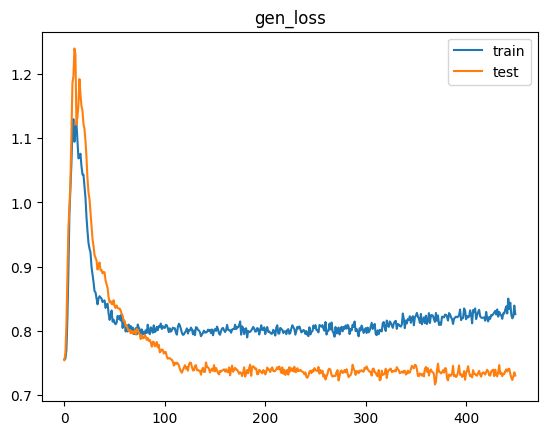

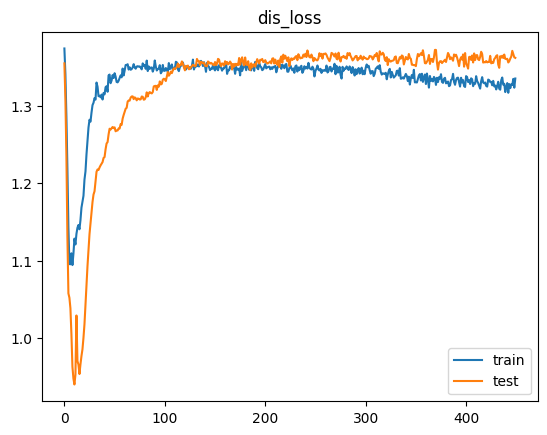

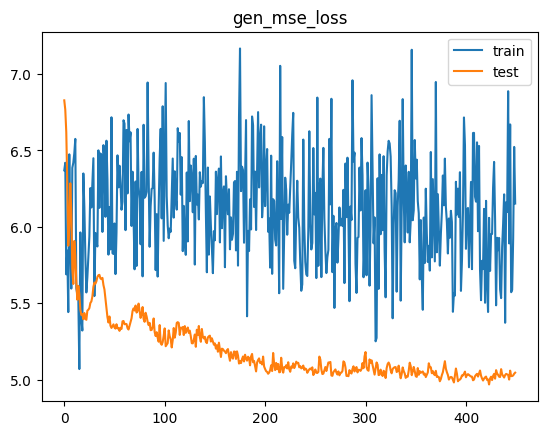

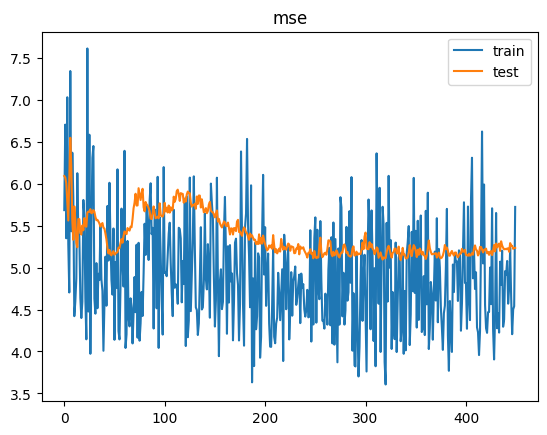

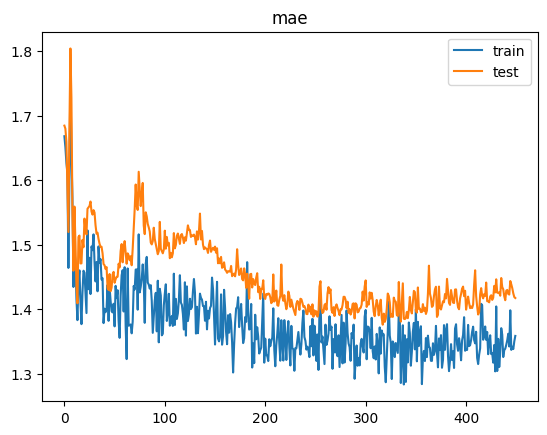

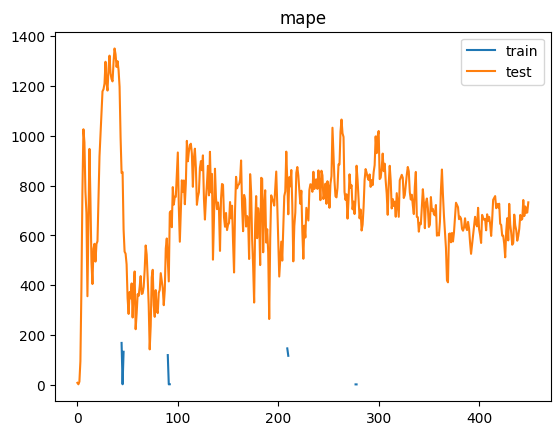

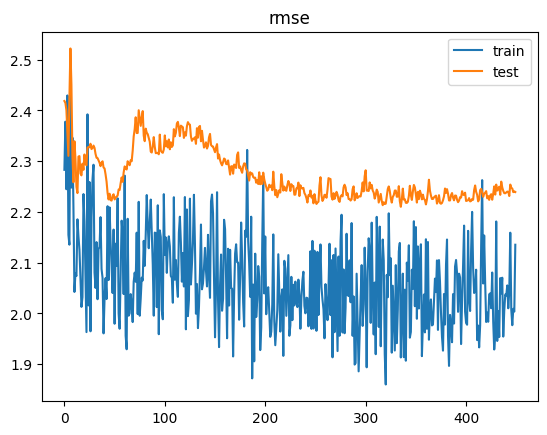

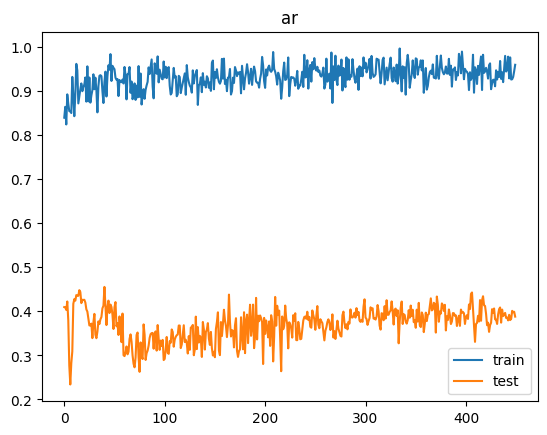

2/2 [==============================] - 1s 3ms/step


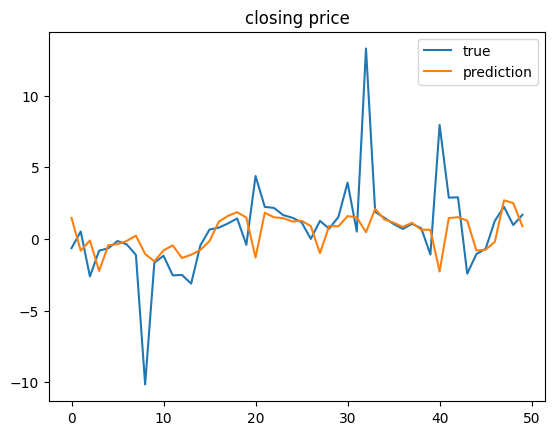

[MSE Baseline] train: 4.8544356910696935  test: 5.002352560408067
Delta time with epochs = 450: 0:07:49.474274
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 5, 20)       1440        ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 5, 27)        0           ['bidirectional_4[0][0]',        
                                                                  'input_3[0][0]

Time for epoch 46 is 1.2279894351959229 sec Generator Loss: 0.8756898045539856,  Discriminator_loss: 1.290900468826294
Time for epoch 47 is 1.1632955074310303 sec Generator Loss: 0.8625016212463379,  Discriminator_loss: 1.3001906871795654
Time for epoch 48 is 1.0568697452545166 sec Generator Loss: 0.8719034194946289,  Discriminator_loss: 1.295756459236145
Time for epoch 49 is 1.065887451171875 sec Generator Loss: 0.8674761652946472,  Discriminator_loss: 1.3035738468170166
Time for epoch 50 is 0.9472179412841797 sec Generator Loss: 0.8660552501678467,  Discriminator_loss: 1.3001028299331665
Time for epoch 51 is 0.9428830146789551 sec Generator Loss: 0.8662475943565369,  Discriminator_loss: 1.3024166822433472
Time for epoch 52 is 0.9488692283630371 sec Generator Loss: 0.8625867366790771,  Discriminator_loss: 1.3060709238052368
Time for epoch 53 is 0.9590919017791748 sec Generator Loss: 0.8565704226493835,  Discriminator_loss: 1.3132771253585815
Time for epoch 54 is 1.0112354755401611 sec

Time for epoch 115 is 1.0511486530303955 sec Generator Loss: 0.8197435140609741,  Discriminator_loss: 1.3398107290267944
Time for epoch 116 is 0.955650806427002 sec Generator Loss: 0.8294137120246887,  Discriminator_loss: 1.3286076784133911
Time for epoch 117 is 0.9470760822296143 sec Generator Loss: 0.8240319490432739,  Discriminator_loss: 1.3331533670425415
Time for epoch 118 is 1.1606652736663818 sec Generator Loss: 0.81868577003479,  Discriminator_loss: 1.3366036415100098
Time for epoch 119 is 1.0655665397644043 sec Generator Loss: 0.8122252821922302,  Discriminator_loss: 1.3459526300430298
Time for epoch 120 is 1.0106940269470215 sec Generator Loss: 0.8219503164291382,  Discriminator_loss: 1.3363794088363647
Time for epoch 121 is 1.1131799221038818 sec Generator Loss: 0.8263626098632812,  Discriminator_loss: 1.3310891389846802
Time for epoch 122 is 1.1155283451080322 sec Generator Loss: 0.8203582763671875,  Discriminator_loss: 1.3398077487945557
Time for epoch 123 is 1.08337283134

Time for epoch 183 is 1.1029469966888428 sec Generator Loss: 0.7973306775093079,  Discriminator_loss: 1.3546853065490723
Time for epoch 184 is 1.1274645328521729 sec Generator Loss: 0.8147417902946472,  Discriminator_loss: 1.3362650871276855
Time for epoch 185 is 0.9872736930847168 sec Generator Loss: 0.8075499534606934,  Discriminator_loss: 1.3423596620559692
Time for epoch 186 is 1.0898094177246094 sec Generator Loss: 0.8135368824005127,  Discriminator_loss: 1.3399970531463623
Time for epoch 187 is 0.9567680358886719 sec Generator Loss: 0.8051011562347412,  Discriminator_loss: 1.352774739265442
Time for epoch 188 is 0.9474132061004639 sec Generator Loss: 0.8194444179534912,  Discriminator_loss: 1.3502559661865234
Time for epoch 189 is 1.004549503326416 sec Generator Loss: 0.8204031586647034,  Discriminator_loss: 1.3419440984725952
Time for epoch 190 is 0.9626584053039551 sec Generator Loss: 0.8033260107040405,  Discriminator_loss: 1.346417784690857
Time for epoch 191 is 0.99240255355

Time for epoch 251 is 0.9806749820709229 sec Generator Loss: 0.8125562071800232,  Discriminator_loss: 1.3424935340881348
Time for epoch 252 is 0.9943745136260986 sec Generator Loss: 0.8104110956192017,  Discriminator_loss: 1.3415406942367554
Time for epoch 253 is 0.9861383438110352 sec Generator Loss: 0.8012517094612122,  Discriminator_loss: 1.3521270751953125
Time for epoch 254 is 0.9773669242858887 sec Generator Loss: 0.8063046336174011,  Discriminator_loss: 1.3447935581207275
Time for epoch 255 is 1.0139355659484863 sec Generator Loss: 0.8036712408065796,  Discriminator_loss: 1.349855899810791
Time for epoch 256 is 0.9837315082550049 sec Generator Loss: 0.8088490962982178,  Discriminator_loss: 1.3446600437164307
Time for epoch 257 is 1.0027055740356445 sec Generator Loss: 0.8069124221801758,  Discriminator_loss: 1.3435938358306885
Time for epoch 258 is 0.9447317123413086 sec Generator Loss: 0.8082393407821655,  Discriminator_loss: 1.3419941663742065
Time for epoch 259 is 0.931261539

Time for epoch 320 is 0.910935640335083 sec Generator Loss: 0.8262465596199036,  Discriminator_loss: 1.3274017572402954
Time for epoch 321 is 0.9074788093566895 sec Generator Loss: 0.8273022174835205,  Discriminator_loss: 1.335599422454834
Time for epoch 322 is 0.9492406845092773 sec Generator Loss: 0.829978883266449,  Discriminator_loss: 1.3311465978622437
Time for epoch 323 is 0.9255516529083252 sec Generator Loss: 0.8233432173728943,  Discriminator_loss: 1.3404035568237305
Time for epoch 324 is 0.9533374309539795 sec Generator Loss: 0.8360463380813599,  Discriminator_loss: 1.3288400173187256
Time for epoch 325 is 0.9151015281677246 sec Generator Loss: 0.8231245279312134,  Discriminator_loss: 1.3361623287200928
Time for epoch 326 is 0.9134411811828613 sec Generator Loss: 0.8232660889625549,  Discriminator_loss: 1.3346291780471802
Time for epoch 327 is 0.9338488578796387 sec Generator Loss: 0.8185321092605591,  Discriminator_loss: 1.3349368572235107
Time for epoch 328 is 0.94027948379

Time for epoch 389 is 1.0046148300170898 sec Generator Loss: 0.8257957696914673,  Discriminator_loss: 1.328804850578308
Time for epoch 390 is 0.9590067863464355 sec Generator Loss: 0.8320381045341492,  Discriminator_loss: 1.3233921527862549
Time for epoch 391 is 0.9835734367370605 sec Generator Loss: 0.8245204091072083,  Discriminator_loss: 1.3379719257354736
Time for epoch 392 is 0.9322357177734375 sec Generator Loss: 0.8206984400749207,  Discriminator_loss: 1.3387815952301025
Time for epoch 393 is 0.9637625217437744 sec Generator Loss: 0.830977737903595,  Discriminator_loss: 1.325386881828308
Time for epoch 394 is 0.9794459342956543 sec Generator Loss: 0.8359094262123108,  Discriminator_loss: 1.3286113739013672
Time for epoch 395 is 0.9536604881286621 sec Generator Loss: 0.8431431651115417,  Discriminator_loss: 1.319683313369751
Time for epoch 396 is 0.936227560043335 sec Generator Loss: 0.8374067544937134,  Discriminator_loss: 1.3295350074768066
Time for epoch 397 is 0.9472777843475

Time for epoch 458 is 1.1778130531311035 sec Generator Loss: 0.8403017520904541,  Discriminator_loss: 1.3280359506607056
Time for epoch 459 is 1.3970370292663574 sec Generator Loss: 0.8384925127029419,  Discriminator_loss: 1.3245978355407715
Time for epoch 460 is 1.1014447212219238 sec Generator Loss: 0.8382672071456909,  Discriminator_loss: 1.332021713256836
Time for epoch 461 is 1.2059383392333984 sec Generator Loss: 0.835442066192627,  Discriminator_loss: 1.3302321434020996
Time for epoch 462 is 1.225074052810669 sec Generator Loss: 0.8382366895675659,  Discriminator_loss: 1.325965166091919
Time for epoch 463 is 1.3584153652191162 sec Generator Loss: 0.8283272385597229,  Discriminator_loss: 1.3302522897720337
Time for epoch 464 is 1.153698205947876 sec Generator Loss: 0.8313732147216797,  Discriminator_loss: 1.328691005706787
Time for epoch 465 is 1.011073112487793 sec Generator Loss: 0.8354495763778687,  Discriminator_loss: 1.329028844833374
Time for epoch 466 is 0.9619152545928955

Time for epoch 527 is 0.9949862957000732 sec Generator Loss: 0.8300858736038208,  Discriminator_loss: 1.3300440311431885
Time for epoch 528 is 1.004302740097046 sec Generator Loss: 0.8282727003097534,  Discriminator_loss: 1.3357430696487427
Time for epoch 529 is 0.9579277038574219 sec Generator Loss: 0.8394051194190979,  Discriminator_loss: 1.3248786926269531
Time for epoch 530 is 1.0140154361724854 sec Generator Loss: 0.8412199020385742,  Discriminator_loss: 1.3277558088302612
Time for epoch 531 is 1.0212337970733643 sec Generator Loss: 0.8376656770706177,  Discriminator_loss: 1.324170708656311
Time for epoch 532 is 1.013422966003418 sec Generator Loss: 0.8433928489685059,  Discriminator_loss: 1.323614478111267
Time for epoch 533 is 1.0159213542938232 sec Generator Loss: 0.8425890803337097,  Discriminator_loss: 1.318299412727356
Time for epoch 534 is 0.9932410717010498 sec Generator Loss: 0.8429401516914368,  Discriminator_loss: 1.322661280632019
Time for epoch 535 is 1.00480198860168

Time for epoch 595 is 0.9844167232513428 sec Generator Loss: 0.8422912359237671,  Discriminator_loss: 1.3268120288848877
Time for epoch 596 is 0.9796996116638184 sec Generator Loss: 0.8481646180152893,  Discriminator_loss: 1.3220181465148926
Time for epoch 597 is 1.0089640617370605 sec Generator Loss: 0.8459053635597229,  Discriminator_loss: 1.3238307237625122
Time for epoch 598 is 1.026059627532959 sec Generator Loss: 0.8356825113296509,  Discriminator_loss: 1.3254982233047485
Time for epoch 599 is 0.9940035343170166 sec Generator Loss: 0.8308262825012207,  Discriminator_loss: 1.3294990062713623
Time for epoch 600 is 0.9882762432098389 sec Generator Loss: 0.8445214033126831,  Discriminator_loss: 1.3227479457855225
Time for epoch 601 is 0.9766867160797119 sec Generator Loss: 0.8480105996131897,  Discriminator_loss: 1.3200881481170654
Time for epoch 602 is 1.0103564262390137 sec Generator Loss: 0.8425652980804443,  Discriminator_loss: 1.318394422531128
Time for epoch 603 is 1.0142958164

Time for epoch 663 is 0.9938700199127197 sec Generator Loss: 0.8422643542289734,  Discriminator_loss: 1.3273695707321167
Time for epoch 664 is 0.9864740371704102 sec Generator Loss: 0.8350570201873779,  Discriminator_loss: 1.3331533670425415
Time for epoch 665 is 1.018671989440918 sec Generator Loss: 0.8492914438247681,  Discriminator_loss: 1.3154748678207397
Time for epoch 666 is 1.0225141048431396 sec Generator Loss: 0.8479182720184326,  Discriminator_loss: 1.3183037042617798
Time for epoch 667 is 0.982457160949707 sec Generator Loss: 0.8502114415168762,  Discriminator_loss: 1.321292757987976
Time for epoch 668 is 0.9359030723571777 sec Generator Loss: 0.8435771465301514,  Discriminator_loss: 1.3272151947021484
Time for epoch 669 is 0.942164421081543 sec Generator Loss: 0.848360002040863,  Discriminator_loss: 1.324461579322815
Time for epoch 670 is 0.9674019813537598 sec Generator Loss: 0.8412505388259888,  Discriminator_loss: 1.3178359270095825
Time for epoch 671 is 0.95499038696289

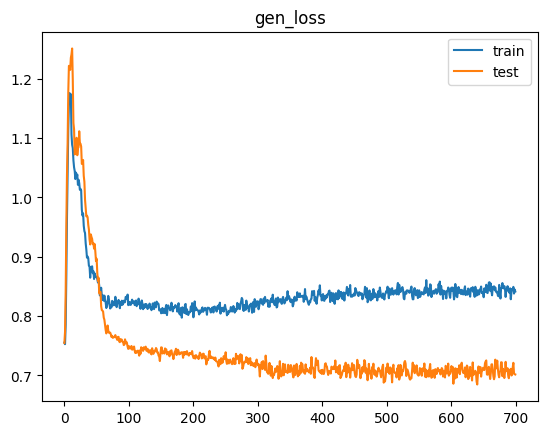

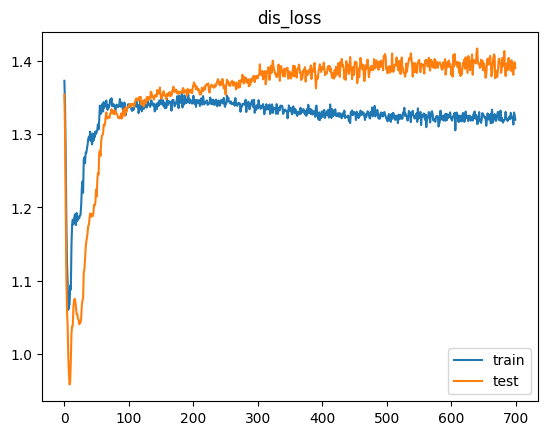

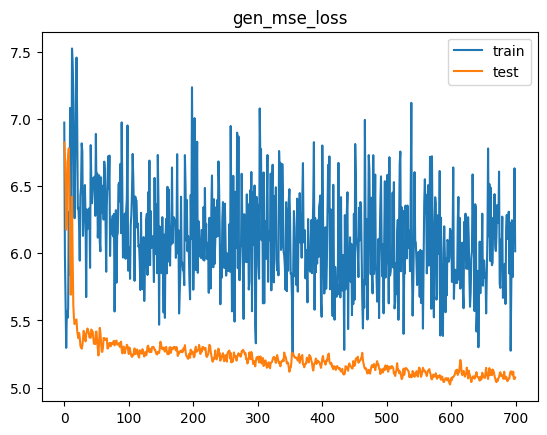

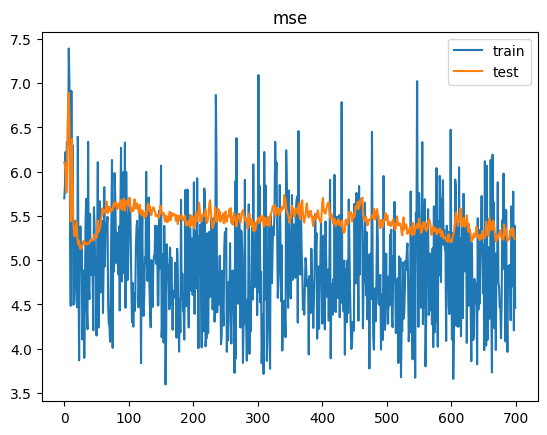

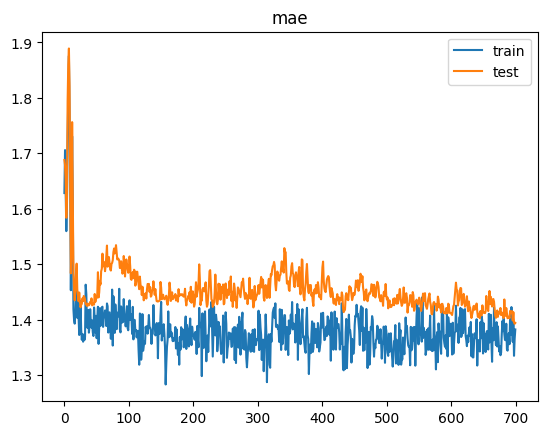

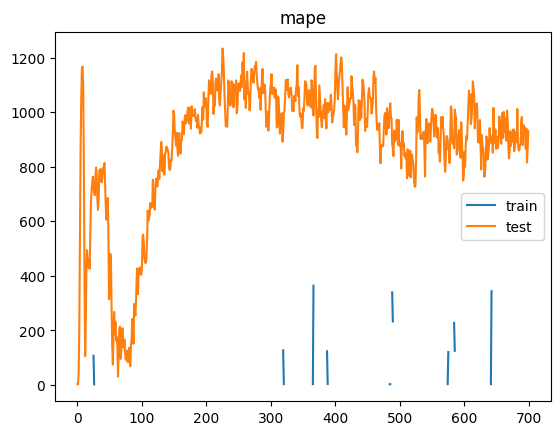

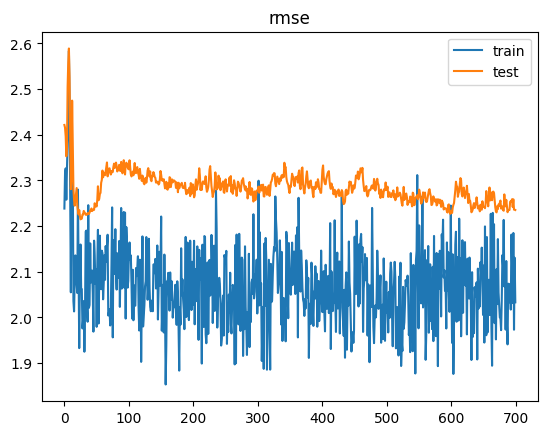

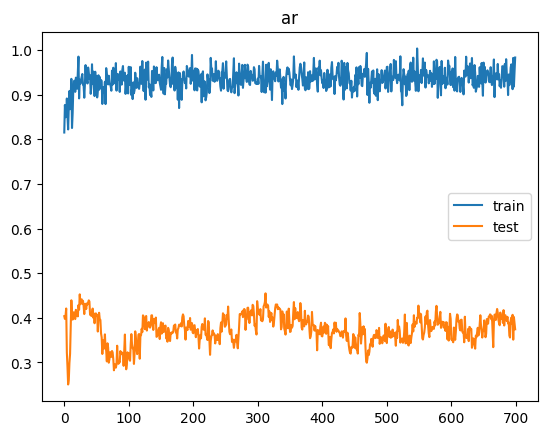

2/2 [==============================] - 1s 4ms/step


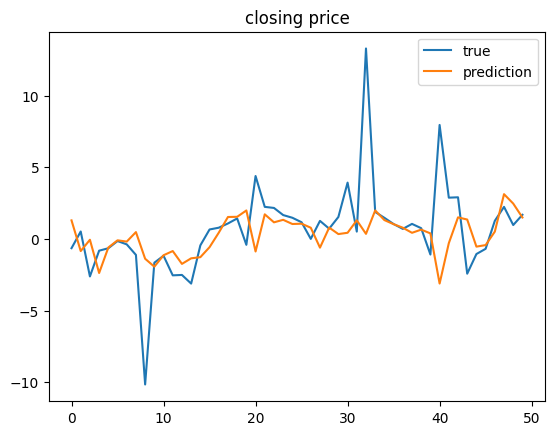

[MSE Baseline] train: 5.122533247209292  test: 5.002352560408067
Delta time with epochs = 700: 0:12:10.017304
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 5, 20)       1440        ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 5, 27)        0           ['bidirectional_6[0][0]',        
                                                                  'input_4[0][0]'

Time for epoch 46 is 1.0567288398742676 sec Generator Loss: 0.8296619057655334,  Discriminator_loss: 1.344843864440918
Time for epoch 47 is 1.0444834232330322 sec Generator Loss: 0.8406639099121094,  Discriminator_loss: 1.3346341848373413
Time for epoch 48 is 0.9825961589813232 sec Generator Loss: 0.8387536406517029,  Discriminator_loss: 1.3338630199432373
Time for epoch 49 is 1.0006330013275146 sec Generator Loss: 0.8305813670158386,  Discriminator_loss: 1.3458669185638428
Time for epoch 50 is 1.0595881938934326 sec Generator Loss: 0.8276882171630859,  Discriminator_loss: 1.3468354940414429
Time for epoch 51 is 0.9771006107330322 sec Generator Loss: 0.8168023824691772,  Discriminator_loss: 1.3445509672164917
Time for epoch 52 is 1.0060093402862549 sec Generator Loss: 0.8154053688049316,  Discriminator_loss: 1.336511254310608
Time for epoch 53 is 0.9972708225250244 sec Generator Loss: 0.8110689520835876,  Discriminator_loss: 1.3408507108688354
Time for epoch 54 is 0.9902074337005615 se

Time for epoch 115 is 0.9910898208618164 sec Generator Loss: 0.8035844564437866,  Discriminator_loss: 1.3418316841125488
Time for epoch 116 is 0.9853787422180176 sec Generator Loss: 0.8089280724525452,  Discriminator_loss: 1.350144386291504
Time for epoch 117 is 1.0373036861419678 sec Generator Loss: 0.8038948774337769,  Discriminator_loss: 1.3463964462280273
Time for epoch 118 is 0.9897208213806152 sec Generator Loss: 0.8034079670906067,  Discriminator_loss: 1.3529480695724487
Time for epoch 119 is 1.0322773456573486 sec Generator Loss: 0.7995361685752869,  Discriminator_loss: 1.356358528137207
Time for epoch 120 is 0.9983236789703369 sec Generator Loss: 0.7975707054138184,  Discriminator_loss: 1.3557186126708984
Time for epoch 121 is 0.956688642501831 sec Generator Loss: 0.8067736625671387,  Discriminator_loss: 1.3547009229660034
Time for epoch 122 is 0.960153341293335 sec Generator Loss: 0.7941787242889404,  Discriminator_loss: 1.3528847694396973
Time for epoch 123 is 0.975259304046

Time for epoch 184 is 0.9983773231506348 sec Generator Loss: 0.8009223937988281,  Discriminator_loss: 1.3535356521606445
Time for epoch 185 is 0.945605993270874 sec Generator Loss: 0.7983924150466919,  Discriminator_loss: 1.3535593748092651
Time for epoch 186 is 0.947955846786499 sec Generator Loss: 0.8048550486564636,  Discriminator_loss: 1.348514199256897
Time for epoch 187 is 0.9499218463897705 sec Generator Loss: 0.8093113899230957,  Discriminator_loss: 1.3466970920562744
Time for epoch 188 is 0.9486091136932373 sec Generator Loss: 0.8023562431335449,  Discriminator_loss: 1.3504793643951416
Time for epoch 189 is 1.0089855194091797 sec Generator Loss: 0.7945112586021423,  Discriminator_loss: 1.348394751548767
Time for epoch 190 is 0.9580957889556885 sec Generator Loss: 0.8069281578063965,  Discriminator_loss: 1.3494046926498413
Time for epoch 191 is 0.9825229644775391 sec Generator Loss: 0.8012315630912781,  Discriminator_loss: 1.3422716856002808
Time for epoch 192 is 0.964908599853

Time for epoch 252 is 0.9672725200653076 sec Generator Loss: 0.8032140731811523,  Discriminator_loss: 1.3473683595657349
Time for epoch 253 is 0.9517464637756348 sec Generator Loss: 0.8176305890083313,  Discriminator_loss: 1.3351720571517944
Time for epoch 254 is 0.9908337593078613 sec Generator Loss: 0.8143559098243713,  Discriminator_loss: 1.3405661582946777
Time for epoch 255 is 0.965080976486206 sec Generator Loss: 0.8062658905982971,  Discriminator_loss: 1.3419133424758911
Time for epoch 256 is 0.949923038482666 sec Generator Loss: 0.8115602731704712,  Discriminator_loss: 1.3436686992645264
Time for epoch 257 is 1.0162184238433838 sec Generator Loss: 0.814294695854187,  Discriminator_loss: 1.3356575965881348
Time for epoch 258 is 0.957416296005249 sec Generator Loss: 0.805217981338501,  Discriminator_loss: 1.3411966562271118
Time for epoch 259 is 0.9677467346191406 sec Generator Loss: 0.8043060898780823,  Discriminator_loss: 1.3468090295791626
Time for epoch 260 is 0.9498267173767

Time for epoch 320 is 0.9490194320678711 sec Generator Loss: 0.8251655697822571,  Discriminator_loss: 1.3340718746185303
Time for epoch 321 is 0.936866283416748 sec Generator Loss: 0.8174843788146973,  Discriminator_loss: 1.335988163948059
Time for epoch 322 is 0.9396810531616211 sec Generator Loss: 0.8306522369384766,  Discriminator_loss: 1.3139081001281738
Time for epoch 323 is 0.9475319385528564 sec Generator Loss: 0.8216941952705383,  Discriminator_loss: 1.3290998935699463
Time for epoch 324 is 0.9923343658447266 sec Generator Loss: 0.832156777381897,  Discriminator_loss: 1.3383312225341797
Time for epoch 325 is 0.9912443161010742 sec Generator Loss: 0.8337663412094116,  Discriminator_loss: 1.3309322595596313
Time for epoch 326 is 0.9399065971374512 sec Generator Loss: 0.8231722116470337,  Discriminator_loss: 1.3302814960479736
Time for epoch 327 is 0.9511699676513672 sec Generator Loss: 0.8221291899681091,  Discriminator_loss: 1.3306514024734497
Time for epoch 328 is 0.94762849807

Time for epoch 389 is 0.9985451698303223 sec Generator Loss: 0.8245826363563538,  Discriminator_loss: 1.328758955001831
Time for epoch 390 is 0.9485487937927246 sec Generator Loss: 0.8289772272109985,  Discriminator_loss: 1.3283095359802246
Time for epoch 391 is 0.8479814529418945 sec Generator Loss: 0.8363430500030518,  Discriminator_loss: 1.323907732963562
Time for epoch 392 is 1.1982285976409912 sec Generator Loss: 0.8294327259063721,  Discriminator_loss: 1.3242443799972534
Time for epoch 393 is 1.100909948348999 sec Generator Loss: 0.8288396596908569,  Discriminator_loss: 1.3269474506378174
Time for epoch 394 is 1.1657304763793945 sec Generator Loss: 0.8301734924316406,  Discriminator_loss: 1.328010082244873
Time for epoch 395 is 1.0938496589660645 sec Generator Loss: 0.8316023945808411,  Discriminator_loss: 1.3229180574417114
Time for epoch 396 is 1.060518503189087 sec Generator Loss: 0.8279338479042053,  Discriminator_loss: 1.3305350542068481
Time for epoch 397 is 1.0023794174194

Time for epoch 458 is 1.0583457946777344 sec Generator Loss: 0.8352169990539551,  Discriminator_loss: 1.324908971786499
Time for epoch 459 is 1.3994827270507812 sec Generator Loss: 0.8250925540924072,  Discriminator_loss: 1.3286832571029663
Time for epoch 460 is 1.3238623142242432 sec Generator Loss: 0.8346824645996094,  Discriminator_loss: 1.3218780755996704
Time for epoch 461 is 1.376075267791748 sec Generator Loss: 0.8318356275558472,  Discriminator_loss: 1.3269822597503662
Time for epoch 462 is 1.3518943786621094 sec Generator Loss: 0.8506554365158081,  Discriminator_loss: 1.3162726163864136
Time for epoch 463 is 1.2028071880340576 sec Generator Loss: 0.8340417146682739,  Discriminator_loss: 1.3229190111160278
Time for epoch 464 is 1.0098023414611816 sec Generator Loss: 0.8301154375076294,  Discriminator_loss: 1.324374794960022
Time for epoch 465 is 1.233922004699707 sec Generator Loss: 0.8386058807373047,  Discriminator_loss: 1.3233904838562012
Time for epoch 466 is 1.123153924942

Time for epoch 527 is 1.0601880550384521 sec Generator Loss: 0.8441128134727478,  Discriminator_loss: 1.3193174600601196
Time for epoch 528 is 1.0709924697875977 sec Generator Loss: 0.8372507095336914,  Discriminator_loss: 1.3198516368865967
Time for epoch 529 is 1.0159003734588623 sec Generator Loss: 0.8354134559631348,  Discriminator_loss: 1.3299061059951782
Time for epoch 530 is 0.9723021984100342 sec Generator Loss: 0.8331059813499451,  Discriminator_loss: 1.3227492570877075
Time for epoch 531 is 0.9601378440856934 sec Generator Loss: 0.8386179208755493,  Discriminator_loss: 1.3253052234649658
Time for epoch 532 is 1.0792574882507324 sec Generator Loss: 0.8477237224578857,  Discriminator_loss: 1.3147492408752441
Time for epoch 533 is 1.0025804042816162 sec Generator Loss: 0.8445544838905334,  Discriminator_loss: 1.3132067918777466
Time for epoch 534 is 1.0134069919586182 sec Generator Loss: 0.8578222990036011,  Discriminator_loss: 1.3177874088287354
Time for epoch 535 is 1.02671551

Time for epoch 595 is 1.19010591506958 sec Generator Loss: 0.8503435850143433,  Discriminator_loss: 1.319347620010376
Time for epoch 596 is 1.11142897605896 sec Generator Loss: 0.8386847376823425,  Discriminator_loss: 1.325230360031128
Time for epoch 597 is 1.1298935413360596 sec Generator Loss: 0.8369519710540771,  Discriminator_loss: 1.3258039951324463
Time for epoch 598 is 1.0550243854522705 sec Generator Loss: 0.847896933555603,  Discriminator_loss: 1.3210036754608154
Time for epoch 599 is 1.0132827758789062 sec Generator Loss: 0.8473832011222839,  Discriminator_loss: 1.3154906034469604
Time for epoch 600 is 1.1853718757629395 sec Generator Loss: 0.8428088426589966,  Discriminator_loss: 1.313944935798645
Time for epoch 601 is 1.1901555061340332 sec Generator Loss: 0.8419145345687866,  Discriminator_loss: 1.3261443376541138
Time for epoch 602 is 1.135282278060913 sec Generator Loss: 0.8402764201164246,  Discriminator_loss: 1.3251705169677734
Time for epoch 603 is 1.0653080940246582 

Time for epoch 664 is 0.9322919845581055 sec Generator Loss: 0.8459406495094299,  Discriminator_loss: 1.3193057775497437
Time for epoch 665 is 0.9187531471252441 sec Generator Loss: 0.8439163565635681,  Discriminator_loss: 1.3214267492294312
Time for epoch 666 is 0.9210190773010254 sec Generator Loss: 0.8399579524993896,  Discriminator_loss: 1.320967197418213
Time for epoch 667 is 0.9443244934082031 sec Generator Loss: 0.8471220135688782,  Discriminator_loss: 1.327786922454834
Time for epoch 668 is 0.9303908348083496 sec Generator Loss: 0.8445210456848145,  Discriminator_loss: 1.3161535263061523
Time for epoch 669 is 0.9235882759094238 sec Generator Loss: 0.842781662940979,  Discriminator_loss: 1.3233698606491089
Time for epoch 670 is 0.9244904518127441 sec Generator Loss: 0.8418718576431274,  Discriminator_loss: 1.3247203826904297
Time for epoch 671 is 0.9077892303466797 sec Generator Loss: 0.8447955250740051,  Discriminator_loss: 1.3246934413909912
Time for epoch 672 is 0.94930362701

Time for epoch 732 is 0.9435825347900391 sec Generator Loss: 0.8468548655509949,  Discriminator_loss: 1.3246275186538696
Time for epoch 733 is 0.9602491855621338 sec Generator Loss: 0.842294454574585,  Discriminator_loss: 1.315777063369751
Time for epoch 734 is 0.9656062126159668 sec Generator Loss: 0.8583015203475952,  Discriminator_loss: 1.318852186203003
Time for epoch 735 is 0.942479133605957 sec Generator Loss: 0.8491641879081726,  Discriminator_loss: 1.3140836954116821
Time for epoch 736 is 0.9859774112701416 sec Generator Loss: 0.8447613716125488,  Discriminator_loss: 1.3140859603881836
Time for epoch 737 is 1.0243325233459473 sec Generator Loss: 0.8448171019554138,  Discriminator_loss: 1.3246231079101562
Time for epoch 738 is 1.0353491306304932 sec Generator Loss: 0.8439289927482605,  Discriminator_loss: 1.3207000494003296
Time for epoch 739 is 0.9958949089050293 sec Generator Loss: 0.8486407995223999,  Discriminator_loss: 1.3118441104888916
Time for epoch 740 is 1.112525701522

Time for epoch 800 is 1.1946585178375244 sec Generator Loss: 0.8589604496955872,  Discriminator_loss: 1.311570644378662
Time for epoch 801 is 1.0893583297729492 sec Generator Loss: 0.8508278131484985,  Discriminator_loss: 1.3210831880569458
Time for epoch 802 is 1.1352050304412842 sec Generator Loss: 0.8545711040496826,  Discriminator_loss: 1.3181668519973755
Time for epoch 803 is 1.1442368030548096 sec Generator Loss: 0.8435412049293518,  Discriminator_loss: 1.3252698183059692
Time for epoch 804 is 1.121988296508789 sec Generator Loss: 0.8449051976203918,  Discriminator_loss: 1.3188377618789673
Time for epoch 805 is 1.0778815746307373 sec Generator Loss: 0.8494994640350342,  Discriminator_loss: 1.3179293870925903
Time for epoch 806 is 1.1849925518035889 sec Generator Loss: 0.8460260629653931,  Discriminator_loss: 1.3152700662612915
Time for epoch 807 is 1.1451003551483154 sec Generator Loss: 0.8579350709915161,  Discriminator_loss: 1.3168367147445679
Time for epoch 808 is 1.0763666629

Time for epoch 869 is 1.272294044494629 sec Generator Loss: 0.8450949788093567,  Discriminator_loss: 1.326403260231018
Time for epoch 870 is 1.2390751838684082 sec Generator Loss: 0.8553911447525024,  Discriminator_loss: 1.3148088455200195
Time for epoch 871 is 1.2754840850830078 sec Generator Loss: 0.8596614599227905,  Discriminator_loss: 1.3092745542526245
Time for epoch 872 is 1.2332768440246582 sec Generator Loss: 0.8626111745834351,  Discriminator_loss: 1.3170536756515503
Time for epoch 873 is 1.2942430973052979 sec Generator Loss: 0.8446509838104248,  Discriminator_loss: 1.3096401691436768
Time for epoch 874 is 1.22029447555542 sec Generator Loss: 0.8539642691612244,  Discriminator_loss: 1.319854974746704
Time for epoch 875 is 1.0496363639831543 sec Generator Loss: 0.8423863053321838,  Discriminator_loss: 1.3175599575042725
Time for epoch 876 is 1.175739049911499 sec Generator Loss: 0.8650833368301392,  Discriminator_loss: 1.3147516250610352
Time for epoch 877 is 1.10302758216857

Time for epoch 938 is 0.9163365364074707 sec Generator Loss: 0.8540951609611511,  Discriminator_loss: 1.3165544271469116
Time for epoch 939 is 0.9126255512237549 sec Generator Loss: 0.8531041741371155,  Discriminator_loss: 1.3149476051330566
Time for epoch 940 is 0.9268436431884766 sec Generator Loss: 0.8428158164024353,  Discriminator_loss: 1.3223826885223389
Time for epoch 941 is 0.9617416858673096 sec Generator Loss: 0.8415959477424622,  Discriminator_loss: 1.3198328018188477
Time for epoch 942 is 0.936180830001831 sec Generator Loss: 0.8487026691436768,  Discriminator_loss: 1.3172061443328857
Time for epoch 943 is 0.9409646987915039 sec Generator Loss: 0.8467239737510681,  Discriminator_loss: 1.3258806467056274
Time for epoch 944 is 0.908949613571167 sec Generator Loss: 0.8431107401847839,  Discriminator_loss: 1.3213266134262085
Time for epoch 945 is 0.9156661033630371 sec Generator Loss: 0.8410050272941589,  Discriminator_loss: 1.328606128692627
Time for epoch 946 is 0.97190046310

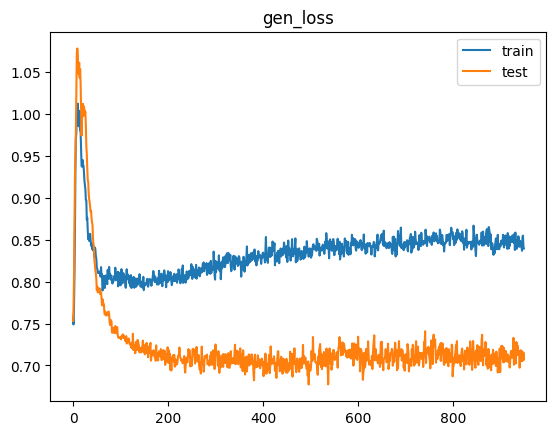

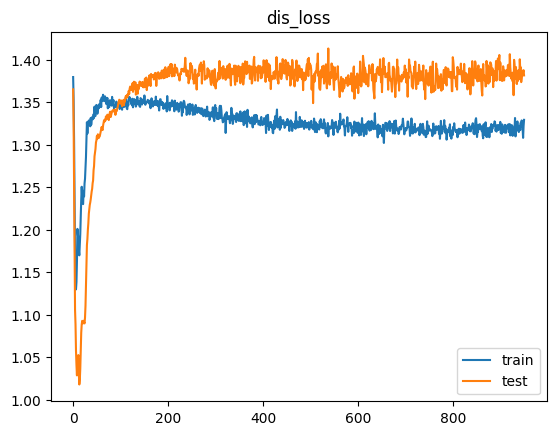

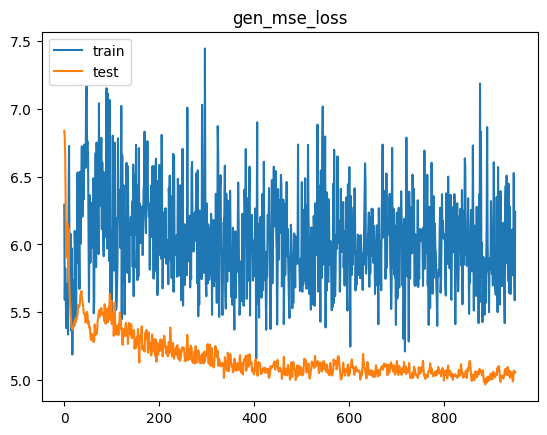

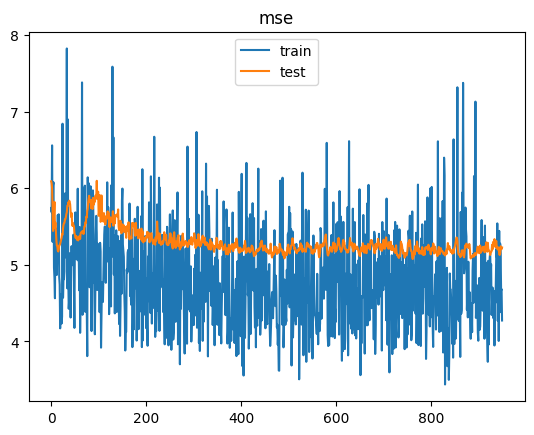

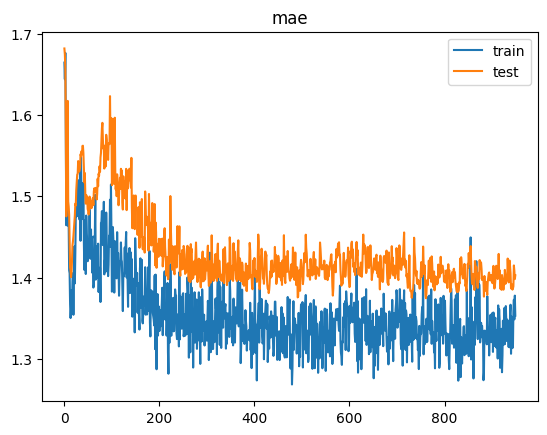

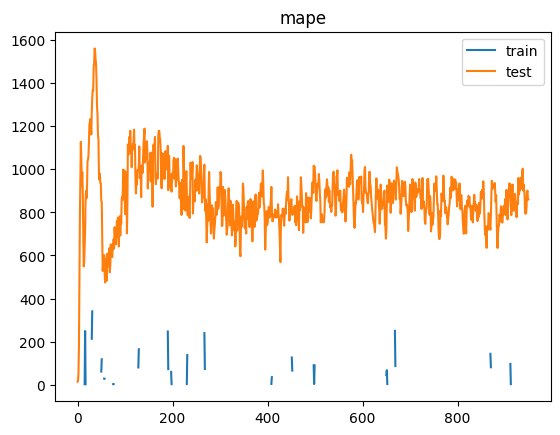

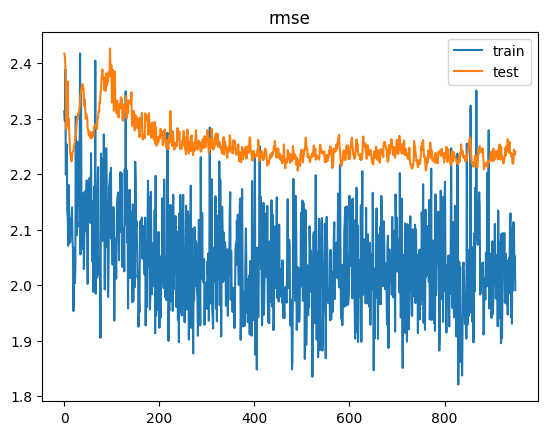

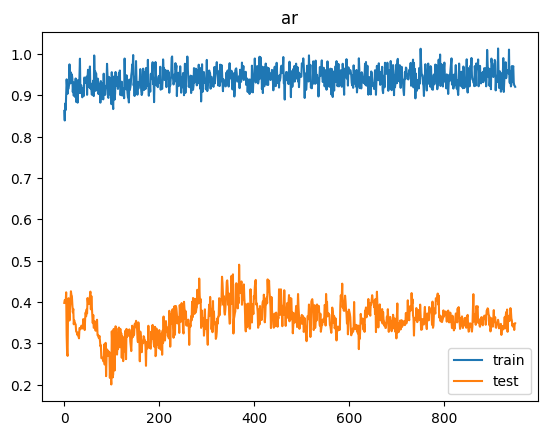

2/2 [==============================] - 1s 2ms/step


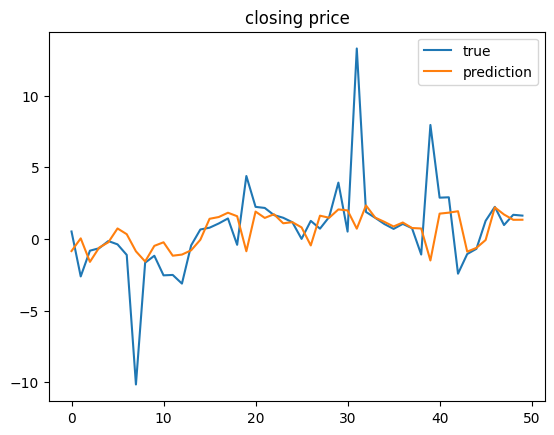

[MSE Baseline] train: 4.115626995471265  test: 5.010967196008289
Delta time with epochs = 950: 0:16:43.440249
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 5, 20)       1440        ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 5, 27)        0           ['bidirectional_8[0][0]',        
                                                                  'input_5[0][0]'

Time for epoch 46 is 0.9915645122528076 sec Generator Loss: 0.8239436745643616,  Discriminator_loss: 1.338114619255066
Time for epoch 47 is 0.9884486198425293 sec Generator Loss: 0.8225625157356262,  Discriminator_loss: 1.3284986019134521
Time for epoch 48 is 0.9562726020812988 sec Generator Loss: 0.8087378144264221,  Discriminator_loss: 1.336551547050476
Time for epoch 49 is 0.9367580413818359 sec Generator Loss: 0.8112344741821289,  Discriminator_loss: 1.342846393585205
Time for epoch 50 is 0.9766037464141846 sec Generator Loss: 0.811163067817688,  Discriminator_loss: 1.3447173833847046
Time for epoch 51 is 0.9781742095947266 sec Generator Loss: 0.806018054485321,  Discriminator_loss: 1.3519166707992554
Time for epoch 52 is 0.9719715118408203 sec Generator Loss: 0.8091674447059631,  Discriminator_loss: 1.3553754091262817
Time for epoch 53 is 0.9954476356506348 sec Generator Loss: 0.8110142350196838,  Discriminator_loss: 1.3580448627471924
Time for epoch 54 is 0.9958631992340088 sec G

Time for epoch 115 is 1.1435508728027344 sec Generator Loss: 0.8064596056938171,  Discriminator_loss: 1.347625732421875
Time for epoch 116 is 1.1314442157745361 sec Generator Loss: 0.8080928325653076,  Discriminator_loss: 1.3356759548187256
Time for epoch 117 is 1.0628070831298828 sec Generator Loss: 0.7984138131141663,  Discriminator_loss: 1.3365412950515747
Time for epoch 118 is 1.0764756202697754 sec Generator Loss: 0.7876320481300354,  Discriminator_loss: 1.3468878269195557
Time for epoch 119 is 1.1735351085662842 sec Generator Loss: 0.8046407699584961,  Discriminator_loss: 1.3449909687042236
Time for epoch 120 is 1.0437679290771484 sec Generator Loss: 0.7961094975471497,  Discriminator_loss: 1.3394595384597778
Time for epoch 121 is 1.0180063247680664 sec Generator Loss: 0.7958391308784485,  Discriminator_loss: 1.344545841217041
Time for epoch 122 is 0.9954192638397217 sec Generator Loss: 0.800250768661499,  Discriminator_loss: 1.3467285633087158
Time for epoch 123 is 1.02973270416

Time for epoch 184 is 1.0615119934082031 sec Generator Loss: 0.8085713386535645,  Discriminator_loss: 1.3467516899108887
Time for epoch 185 is 1.0109751224517822 sec Generator Loss: 0.802581250667572,  Discriminator_loss: 1.3401782512664795
Time for epoch 186 is 1.0393002033233643 sec Generator Loss: 0.8100820779800415,  Discriminator_loss: 1.3369200229644775
Time for epoch 187 is 1.101940631866455 sec Generator Loss: 0.8086422681808472,  Discriminator_loss: 1.340228796005249
Time for epoch 188 is 1.0547068119049072 sec Generator Loss: 0.8053151965141296,  Discriminator_loss: 1.342847228050232
Time for epoch 189 is 1.0051887035369873 sec Generator Loss: 0.8185422420501709,  Discriminator_loss: 1.3393748998641968
Time for epoch 190 is 1.0354602336883545 sec Generator Loss: 0.8090357184410095,  Discriminator_loss: 1.339257836341858
Time for epoch 191 is 1.0268678665161133 sec Generator Loss: 0.8016073703765869,  Discriminator_loss: 1.3417731523513794
Time for epoch 192 is 1.0264208316802

Time for epoch 253 is 1.0355823040008545 sec Generator Loss: 0.8125122785568237,  Discriminator_loss: 1.3380736112594604
Time for epoch 254 is 1.0262081623077393 sec Generator Loss: 0.8152579069137573,  Discriminator_loss: 1.3363356590270996
Time for epoch 255 is 1.0682976245880127 sec Generator Loss: 0.8114665150642395,  Discriminator_loss: 1.3278650045394897
Time for epoch 256 is 1.0696425437927246 sec Generator Loss: 0.8109235167503357,  Discriminator_loss: 1.3307690620422363
Time for epoch 257 is 1.0834214687347412 sec Generator Loss: 0.811095118522644,  Discriminator_loss: 1.3285574913024902
Time for epoch 258 is 1.0422446727752686 sec Generator Loss: 0.8203577399253845,  Discriminator_loss: 1.3330414295196533
Time for epoch 259 is 1.013688087463379 sec Generator Loss: 0.8292502760887146,  Discriminator_loss: 1.3294404745101929
Time for epoch 260 is 1.0613574981689453 sec Generator Loss: 0.8192570209503174,  Discriminator_loss: 1.3341609239578247
Time for epoch 261 is 1.0883047580

Time for epoch 321 is 1.0361151695251465 sec Generator Loss: 0.8210028409957886,  Discriminator_loss: 1.3291605710983276
Time for epoch 322 is 1.1191699504852295 sec Generator Loss: 0.8297848105430603,  Discriminator_loss: 1.3250815868377686
Time for epoch 323 is 1.0667190551757812 sec Generator Loss: 0.826793372631073,  Discriminator_loss: 1.3239432573318481
Time for epoch 324 is 1.0512452125549316 sec Generator Loss: 0.8224447965621948,  Discriminator_loss: 1.3267184495925903
Time for epoch 325 is 1.0387489795684814 sec Generator Loss: 0.8312328457832336,  Discriminator_loss: 1.3272746801376343
Time for epoch 326 is 1.0853497982025146 sec Generator Loss: 0.8290024995803833,  Discriminator_loss: 1.3214739561080933
Time for epoch 327 is 1.0477583408355713 sec Generator Loss: 0.8254523277282715,  Discriminator_loss: 1.3311713933944702
Time for epoch 328 is 1.0757598876953125 sec Generator Loss: 0.8305180072784424,  Discriminator_loss: 1.3227291107177734
Time for epoch 329 is 1.024050951

Time for epoch 389 is 1.0317659378051758 sec Generator Loss: 0.8242455124855042,  Discriminator_loss: 1.3306341171264648
Time for epoch 390 is 1.0081043243408203 sec Generator Loss: 0.8259569406509399,  Discriminator_loss: 1.3243370056152344
Time for epoch 391 is 1.014355182647705 sec Generator Loss: 0.8335226774215698,  Discriminator_loss: 1.3221943378448486
Time for epoch 392 is 1.0920610427856445 sec Generator Loss: 0.8320891261100769,  Discriminator_loss: 1.3342888355255127
Time for epoch 393 is 1.0814564228057861 sec Generator Loss: 0.8290935158729553,  Discriminator_loss: 1.3257538080215454
Time for epoch 394 is 1.001563549041748 sec Generator Loss: 0.828681230545044,  Discriminator_loss: 1.3212907314300537
Time for epoch 395 is 1.0187478065490723 sec Generator Loss: 0.8284481763839722,  Discriminator_loss: 1.3200342655181885
Time for epoch 396 is 1.0374228954315186 sec Generator Loss: 0.8355016112327576,  Discriminator_loss: 1.3274967670440674
Time for epoch 397 is 1.05290675163

Time for epoch 458 is 1.0579895973205566 sec Generator Loss: 0.847909688949585,  Discriminator_loss: 1.3171014785766602
Time for epoch 459 is 1.0245301723480225 sec Generator Loss: 0.8335707783699036,  Discriminator_loss: 1.3182204961776733
Time for epoch 460 is 1.0720367431640625 sec Generator Loss: 0.8326576352119446,  Discriminator_loss: 1.3192110061645508
Time for epoch 461 is 1.0052952766418457 sec Generator Loss: 0.8298898339271545,  Discriminator_loss: 1.3203068971633911
Time for epoch 462 is 1.0024864673614502 sec Generator Loss: 0.8460948467254639,  Discriminator_loss: 1.3108134269714355
Time for epoch 463 is 0.9843637943267822 sec Generator Loss: 0.8454845547676086,  Discriminator_loss: 1.3184210062026978
Time for epoch 464 is 1.107201099395752 sec Generator Loss: 0.832134485244751,  Discriminator_loss: 1.3212733268737793
Time for epoch 465 is 1.1097440719604492 sec Generator Loss: 0.8409750461578369,  Discriminator_loss: 1.3168749809265137
Time for epoch 466 is 1.06859517097

Time for epoch 526 is 1.1130046844482422 sec Generator Loss: 0.8378977179527283,  Discriminator_loss: 1.3206067085266113
Time for epoch 527 is 1.0563709735870361 sec Generator Loss: 0.8498700857162476,  Discriminator_loss: 1.3193743228912354
Time for epoch 528 is 1.0506515502929688 sec Generator Loss: 0.8441289067268372,  Discriminator_loss: 1.308271050453186
Time for epoch 529 is 1.0985405445098877 sec Generator Loss: 0.8576634526252747,  Discriminator_loss: 1.3051021099090576
Time for epoch 530 is 1.072073221206665 sec Generator Loss: 0.8478154540061951,  Discriminator_loss: 1.3224951028823853
Time for epoch 531 is 1.0643274784088135 sec Generator Loss: 0.8482003808021545,  Discriminator_loss: 1.3165583610534668
Time for epoch 532 is 1.0638365745544434 sec Generator Loss: 0.8417209982872009,  Discriminator_loss: 1.319823145866394
Time for epoch 533 is 1.0496044158935547 sec Generator Loss: 0.8534565567970276,  Discriminator_loss: 1.3067035675048828
Time for epoch 534 is 1.04870080947

Time for epoch 595 is 1.0280044078826904 sec Generator Loss: 0.8485215306282043,  Discriminator_loss: 1.3167765140533447
Time for epoch 596 is 1.0583386421203613 sec Generator Loss: 0.8498407602310181,  Discriminator_loss: 1.3108505010604858
Time for epoch 597 is 1.0740752220153809 sec Generator Loss: 0.8447604179382324,  Discriminator_loss: 1.3185054063796997
Time for epoch 598 is 1.067216396331787 sec Generator Loss: 0.8442140817642212,  Discriminator_loss: 1.3125176429748535
Time for epoch 599 is 1.021397590637207 sec Generator Loss: 0.8483783602714539,  Discriminator_loss: 1.3190064430236816
Time for epoch 600 is 1.054950475692749 sec Generator Loss: 0.8458602428436279,  Discriminator_loss: 1.311034083366394
Time for epoch 601 is 1.0978915691375732 sec Generator Loss: 0.8411101698875427,  Discriminator_loss: 1.3193824291229248
Time for epoch 602 is 1.09210205078125 sec Generator Loss: 0.8544160723686218,  Discriminator_loss: 1.3177236318588257
Time for epoch 603 is 1.03570699691772

Time for epoch 664 is 1.0694940090179443 sec Generator Loss: 0.846498429775238,  Discriminator_loss: 1.315286636352539
Time for epoch 665 is 1.036137580871582 sec Generator Loss: 0.8471050262451172,  Discriminator_loss: 1.3214436769485474
Time for epoch 666 is 1.0412685871124268 sec Generator Loss: 0.8462727069854736,  Discriminator_loss: 1.3179152011871338
Time for epoch 667 is 1.0360827445983887 sec Generator Loss: 0.8434664011001587,  Discriminator_loss: 1.3185033798217773
Time for epoch 668 is 1.052379846572876 sec Generator Loss: 0.8523619174957275,  Discriminator_loss: 1.3136001825332642
Time for epoch 669 is 1.060619831085205 sec Generator Loss: 0.8544988632202148,  Discriminator_loss: 1.313966155052185
Time for epoch 670 is 1.0248565673828125 sec Generator Loss: 0.8487358689308167,  Discriminator_loss: 1.3158003091812134
Time for epoch 671 is 1.007807970046997 sec Generator Loss: 0.844554603099823,  Discriminator_loss: 1.3181984424591064
Time for epoch 672 is 0.9810762405395508

Time for epoch 733 is 0.9975244998931885 sec Generator Loss: 0.8534290194511414,  Discriminator_loss: 1.3097970485687256
Time for epoch 734 is 1.0549664497375488 sec Generator Loss: 0.8501649498939514,  Discriminator_loss: 1.3121992349624634
Time for epoch 735 is 1.0179760456085205 sec Generator Loss: 0.8440874218940735,  Discriminator_loss: 1.3243348598480225
Time for epoch 736 is 1.001664638519287 sec Generator Loss: 0.8552597165107727,  Discriminator_loss: 1.3140243291854858
Time for epoch 737 is 1.0102217197418213 sec Generator Loss: 0.8368545174598694,  Discriminator_loss: 1.327416181564331
Time for epoch 738 is 1.0166969299316406 sec Generator Loss: 0.8475987911224365,  Discriminator_loss: 1.3142268657684326
Time for epoch 739 is 1.0270566940307617 sec Generator Loss: 0.8543845415115356,  Discriminator_loss: 1.3142284154891968
Time for epoch 740 is 1.0221033096313477 sec Generator Loss: 0.8469951152801514,  Discriminator_loss: 1.3155218362808228
Time for epoch 741 is 1.0086259841

Time for epoch 802 is 0.9984865188598633 sec Generator Loss: 0.8440974354743958,  Discriminator_loss: 1.3191193342208862
Time for epoch 803 is 1.0182819366455078 sec Generator Loss: 0.8543476462364197,  Discriminator_loss: 1.3155603408813477
Time for epoch 804 is 1.0009026527404785 sec Generator Loss: 0.8463969826698303,  Discriminator_loss: 1.3192338943481445
Time for epoch 805 is 1.0794861316680908 sec Generator Loss: 0.8509278893470764,  Discriminator_loss: 1.320939064025879
Time for epoch 806 is 1.069366216659546 sec Generator Loss: 0.8525937795639038,  Discriminator_loss: 1.3185298442840576
Time for epoch 807 is 1.0897843837738037 sec Generator Loss: 0.8392986059188843,  Discriminator_loss: 1.326066255569458
Time for epoch 808 is 1.0549733638763428 sec Generator Loss: 0.8458192944526672,  Discriminator_loss: 1.307186245918274
Time for epoch 809 is 1.0855374336242676 sec Generator Loss: 0.8449104428291321,  Discriminator_loss: 1.3197859525680542
Time for epoch 810 is 1.0546875 sec 

Time for epoch 871 is 1.0345218181610107 sec Generator Loss: 0.8381720781326294,  Discriminator_loss: 1.3177002668380737
Time for epoch 872 is 1.009878396987915 sec Generator Loss: 0.8380674719810486,  Discriminator_loss: 1.3181062936782837
Time for epoch 873 is 1.0751676559448242 sec Generator Loss: 0.8602901697158813,  Discriminator_loss: 1.317263126373291
Time for epoch 874 is 1.0255708694458008 sec Generator Loss: 0.8513830304145813,  Discriminator_loss: 1.319904088973999
Time for epoch 875 is 1.0363638401031494 sec Generator Loss: 0.8443492650985718,  Discriminator_loss: 1.311224102973938
Time for epoch 876 is 1.018523931503296 sec Generator Loss: 0.8376928567886353,  Discriminator_loss: 1.326314091682434
Time for epoch 877 is 1.0027875900268555 sec Generator Loss: 0.8434104323387146,  Discriminator_loss: 1.317258358001709
Time for epoch 878 is 1.0393316745758057 sec Generator Loss: 0.8409450650215149,  Discriminator_loss: 1.32185959815979
Time for epoch 879 is 1.0047898292541504 

Time for epoch 940 is 1.1051881313323975 sec Generator Loss: 0.8354228138923645,  Discriminator_loss: 1.3228801488876343
Time for epoch 941 is 1.1368632316589355 sec Generator Loss: 0.8405261039733887,  Discriminator_loss: 1.3244236707687378
Time for epoch 942 is 0.9731569290161133 sec Generator Loss: 0.8448109030723572,  Discriminator_loss: 1.323112964630127
Time for epoch 943 is 1.000236988067627 sec Generator Loss: 0.8469107747077942,  Discriminator_loss: 1.315150260925293
Time for epoch 944 is 1.012568473815918 sec Generator Loss: 0.8534221649169922,  Discriminator_loss: 1.3108888864517212
Time for epoch 945 is 1.176367998123169 sec Generator Loss: 0.8370448350906372,  Discriminator_loss: 1.3234243392944336
Time for epoch 946 is 1.2258377075195312 sec Generator Loss: 0.8357967138290405,  Discriminator_loss: 1.3349213600158691
Time for epoch 947 is 1.0686976909637451 sec Generator Loss: 0.8492812514305115,  Discriminator_loss: 1.316375970840454
Time for epoch 948 is 1.02455687522888

Time for epoch 1008 is 1.313788890838623 sec Generator Loss: 0.8542208671569824,  Discriminator_loss: 1.3166117668151855
Time for epoch 1009 is 1.2404289245605469 sec Generator Loss: 0.8400101065635681,  Discriminator_loss: 1.3120620250701904
Time for epoch 1010 is 1.406266450881958 sec Generator Loss: 0.8457497954368591,  Discriminator_loss: 1.3155934810638428
Time for epoch 1011 is 1.1112310886383057 sec Generator Loss: 0.8498448729515076,  Discriminator_loss: 1.313767910003662
Time for epoch 1012 is 1.162435531616211 sec Generator Loss: 0.8546580672264099,  Discriminator_loss: 1.3146131038665771
Time for epoch 1013 is 1.1399078369140625 sec Generator Loss: 0.8440734148025513,  Discriminator_loss: 1.3224583864212036
Time for epoch 1014 is 1.1580047607421875 sec Generator Loss: 0.8464818596839905,  Discriminator_loss: 1.3172311782836914
Time for epoch 1015 is 1.242405652999878 sec Generator Loss: 0.8553722500801086,  Discriminator_loss: 1.318152666091919
Time for epoch 1016 is 1.23881

Time for epoch 1076 is 0.974236249923706 sec Generator Loss: 0.8521596193313599,  Discriminator_loss: 1.3153777122497559
Time for epoch 1077 is 0.9625363349914551 sec Generator Loss: 0.8498809337615967,  Discriminator_loss: 1.323104977607727
Time for epoch 1078 is 0.9787671566009521 sec Generator Loss: 0.8422039151191711,  Discriminator_loss: 1.3216668367385864
Time for epoch 1079 is 0.9603149890899658 sec Generator Loss: 0.8468011617660522,  Discriminator_loss: 1.3186453580856323
Time for epoch 1080 is 0.976405143737793 sec Generator Loss: 0.8334606289863586,  Discriminator_loss: 1.3189506530761719
Time for epoch 1081 is 1.1152703762054443 sec Generator Loss: 0.8322440385818481,  Discriminator_loss: 1.326505184173584
Time for epoch 1082 is 1.0682356357574463 sec Generator Loss: 0.8480274081230164,  Discriminator_loss: 1.315175175666809
Time for epoch 1083 is 1.1519834995269775 sec Generator Loss: 0.8372170925140381,  Discriminator_loss: 1.3270668983459473
Time for epoch 1084 is 1.1289

Time for epoch 1144 is 0.9931268692016602 sec Generator Loss: 0.8480756878852844,  Discriminator_loss: 1.3243460655212402
Time for epoch 1145 is 1.0086352825164795 sec Generator Loss: 0.8432018756866455,  Discriminator_loss: 1.3182964324951172
Time for epoch 1146 is 0.9906933307647705 sec Generator Loss: 0.8524979948997498,  Discriminator_loss: 1.3168059587478638
Time for epoch 1147 is 0.9993593692779541 sec Generator Loss: 0.8419985771179199,  Discriminator_loss: 1.3220359086990356
Time for epoch 1148 is 1.0180237293243408 sec Generator Loss: 0.8479115962982178,  Discriminator_loss: 1.3210959434509277
Time for epoch 1149 is 0.9974024295806885 sec Generator Loss: 0.8508688807487488,  Discriminator_loss: 1.3145378828048706
Time for epoch 1150 is 1.0141103267669678 sec Generator Loss: 0.8500984907150269,  Discriminator_loss: 1.319872260093689
Time for epoch 1151 is 1.1440181732177734 sec Generator Loss: 0.8380546569824219,  Discriminator_loss: 1.3266806602478027
Time for epoch 1152 is 1.

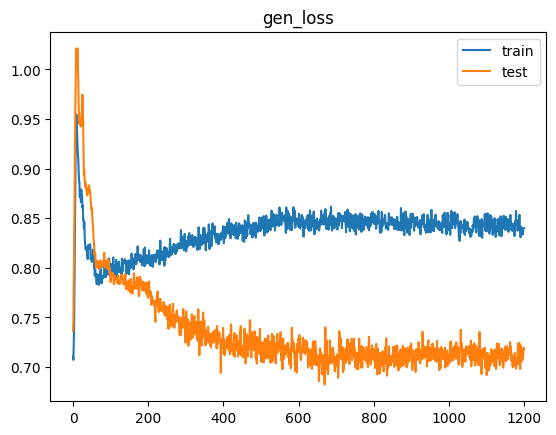

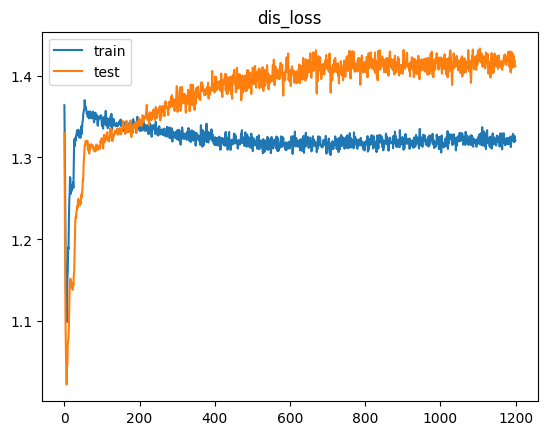

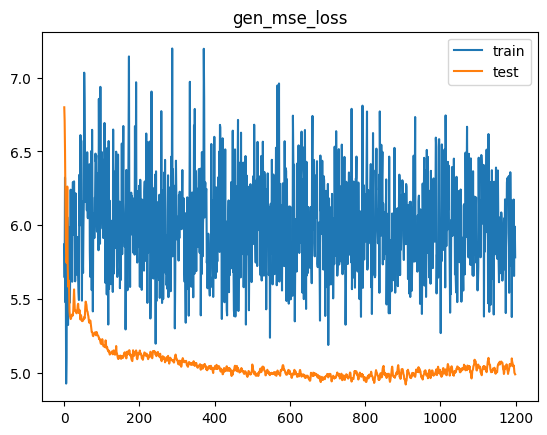

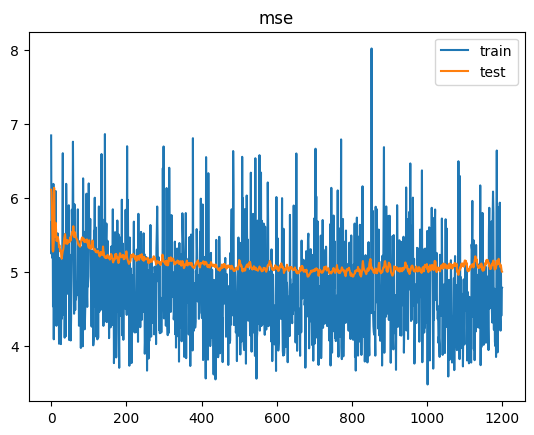

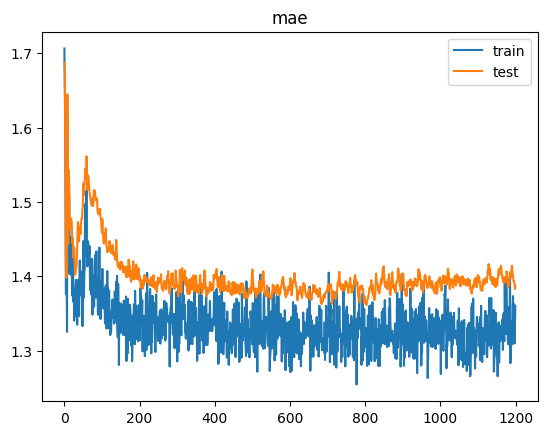

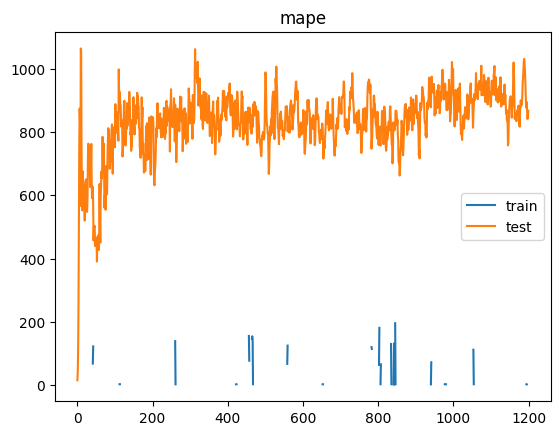

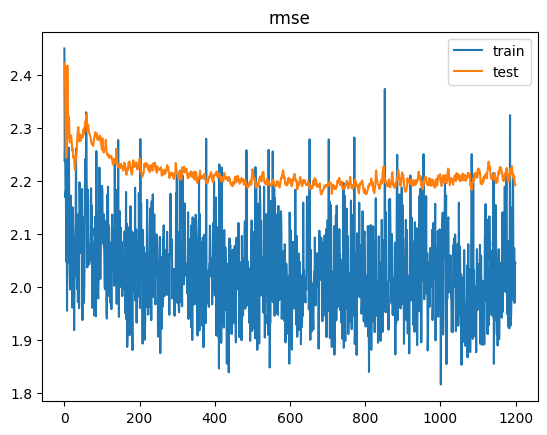

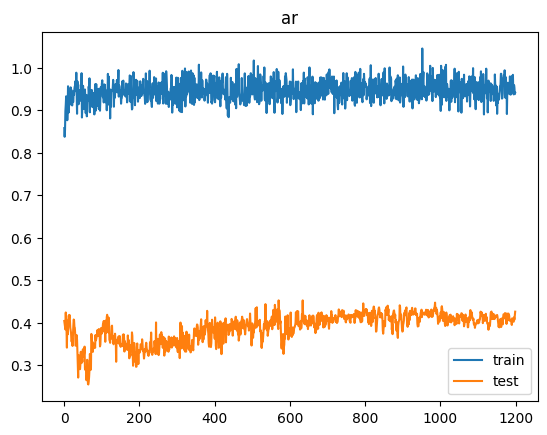

2/2 [==============================] - 1s 5ms/step


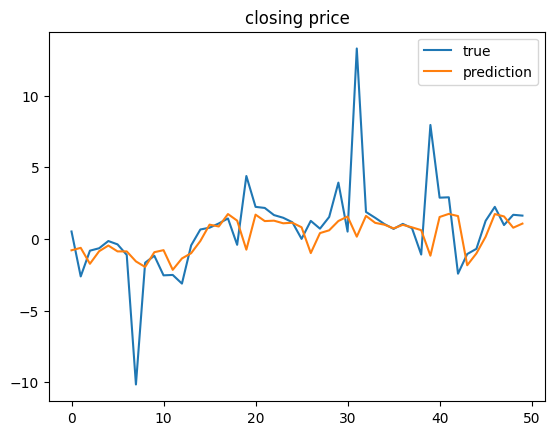

[MSE Baseline] train: 3.7320983911011414  test: 5.010967196008289
Delta time with epochs = 1200: 0:21:24.288259
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 5, 20)       1440        ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 5, 27)        0           ['bidirectional_10[0][0]',       
                                                                  'input_6[0][0

Time for epoch 46 is 1.0527729988098145 sec Generator Loss: 0.8722136616706848,  Discriminator_loss: 1.3103768825531006
Time for epoch 47 is 1.0433659553527832 sec Generator Loss: 0.8701053857803345,  Discriminator_loss: 1.3011451959609985
Time for epoch 48 is 1.0661773681640625 sec Generator Loss: 0.8752082586288452,  Discriminator_loss: 1.3039723634719849
Time for epoch 49 is 1.0859203338623047 sec Generator Loss: 0.8700451254844666,  Discriminator_loss: 1.3100981712341309
Time for epoch 50 is 1.137305736541748 sec Generator Loss: 0.8620943427085876,  Discriminator_loss: 1.3240656852722168
Time for epoch 51 is 1.0978796482086182 sec Generator Loss: 0.8676537275314331,  Discriminator_loss: 1.3148432970046997
Time for epoch 52 is 1.068812608718872 sec Generator Loss: 0.8724715709686279,  Discriminator_loss: 1.318806529045105
Time for epoch 53 is 1.0265274047851562 sec Generator Loss: 0.8434656262397766,  Discriminator_loss: 1.335312008857727
Time for epoch 54 is 1.066164255142212 sec G

Time for epoch 115 is 1.0265932083129883 sec Generator Loss: 0.8271414637565613,  Discriminator_loss: 1.3376288414001465
Time for epoch 116 is 1.0528178215026855 sec Generator Loss: 0.8177940249443054,  Discriminator_loss: 1.3337949514389038
Time for epoch 117 is 1.0199558734893799 sec Generator Loss: 0.82887864112854,  Discriminator_loss: 1.3299216032028198
Time for epoch 118 is 1.0447475910186768 sec Generator Loss: 0.8184066414833069,  Discriminator_loss: 1.3363903760910034
Time for epoch 119 is 1.1040904521942139 sec Generator Loss: 0.8300756216049194,  Discriminator_loss: 1.3306697607040405
Time for epoch 120 is 1.050241470336914 sec Generator Loss: 0.8220868110656738,  Discriminator_loss: 1.3330652713775635
Time for epoch 121 is 1.0931482315063477 sec Generator Loss: 0.8172732591629028,  Discriminator_loss: 1.3323748111724854
Time for epoch 122 is 1.0638959407806396 sec Generator Loss: 0.818326473236084,  Discriminator_loss: 1.3338419198989868
Time for epoch 123 is 1.002892971038

Time for epoch 184 is 1.0099809169769287 sec Generator Loss: 0.8038672208786011,  Discriminator_loss: 1.3467864990234375
Time for epoch 185 is 1.0057439804077148 sec Generator Loss: 0.7983231544494629,  Discriminator_loss: 1.3489229679107666
Time for epoch 186 is 1.1160790920257568 sec Generator Loss: 0.8040728569030762,  Discriminator_loss: 1.3455829620361328
Time for epoch 187 is 1.0965430736541748 sec Generator Loss: 0.8155473470687866,  Discriminator_loss: 1.341209888458252
Time for epoch 188 is 0.9656567573547363 sec Generator Loss: 0.8085532188415527,  Discriminator_loss: 1.3420649766921997
Time for epoch 189 is 1.0242810249328613 sec Generator Loss: 0.8102641701698303,  Discriminator_loss: 1.3434720039367676
Time for epoch 190 is 1.0144586563110352 sec Generator Loss: 0.7990013360977173,  Discriminator_loss: 1.358088493347168
Time for epoch 191 is 0.9630908966064453 sec Generator Loss: 0.8038625717163086,  Discriminator_loss: 1.3456650972366333
Time for epoch 192 is 1.0451872348

Time for epoch 252 is 1.0822536945343018 sec Generator Loss: 0.8099385499954224,  Discriminator_loss: 1.3410383462905884
Time for epoch 253 is 1.032567024230957 sec Generator Loss: 0.8103914856910706,  Discriminator_loss: 1.3392739295959473
Time for epoch 254 is 1.054126501083374 sec Generator Loss: 0.805155336856842,  Discriminator_loss: 1.3418575525283813
Time for epoch 255 is 0.9888396263122559 sec Generator Loss: 0.8067821860313416,  Discriminator_loss: 1.3457224369049072
Time for epoch 256 is 1.0219182968139648 sec Generator Loss: 0.8106055855751038,  Discriminator_loss: 1.3402595520019531
Time for epoch 257 is 1.0241262912750244 sec Generator Loss: 0.808626651763916,  Discriminator_loss: 1.3344266414642334
Time for epoch 258 is 0.9879405498504639 sec Generator Loss: 0.8202389478683472,  Discriminator_loss: 1.3321930170059204
Time for epoch 259 is 1.0051312446594238 sec Generator Loss: 0.815129816532135,  Discriminator_loss: 1.3404101133346558
Time for epoch 260 is 0.9867405891418

Time for epoch 320 is 1.0267722606658936 sec Generator Loss: 0.8291445374488831,  Discriminator_loss: 1.3295410871505737
Time for epoch 321 is 1.0856945514678955 sec Generator Loss: 0.8274037837982178,  Discriminator_loss: 1.3319714069366455
Time for epoch 322 is 1.0264031887054443 sec Generator Loss: 0.8282730579376221,  Discriminator_loss: 1.3309409618377686
Time for epoch 323 is 1.0328137874603271 sec Generator Loss: 0.8321267366409302,  Discriminator_loss: 1.3212001323699951
Time for epoch 324 is 1.054399013519287 sec Generator Loss: 0.8250036239624023,  Discriminator_loss: 1.3381762504577637
Time for epoch 325 is 1.0390069484710693 sec Generator Loss: 0.8193722367286682,  Discriminator_loss: 1.3346751928329468
Time for epoch 326 is 1.1073360443115234 sec Generator Loss: 0.8214935660362244,  Discriminator_loss: 1.3279367685317993
Time for epoch 327 is 1.0900015830993652 sec Generator Loss: 0.8217864036560059,  Discriminator_loss: 1.3380987644195557
Time for epoch 328 is 1.103267908

Time for epoch 389 is 1.160607099533081 sec Generator Loss: 0.8226684927940369,  Discriminator_loss: 1.3281912803649902
Time for epoch 390 is 1.1544198989868164 sec Generator Loss: 0.8557795882225037,  Discriminator_loss: 1.3128331899642944
Time for epoch 391 is 1.1039364337921143 sec Generator Loss: 0.8356671333312988,  Discriminator_loss: 1.3216698169708252
Time for epoch 392 is 1.1681244373321533 sec Generator Loss: 0.8381518125534058,  Discriminator_loss: 1.3166754245758057
Time for epoch 393 is 1.2187068462371826 sec Generator Loss: 0.8438996076583862,  Discriminator_loss: 1.3182098865509033
Time for epoch 394 is 1.1714191436767578 sec Generator Loss: 0.8411435484886169,  Discriminator_loss: 1.316993236541748
Time for epoch 395 is 1.1108660697937012 sec Generator Loss: 0.839564859867096,  Discriminator_loss: 1.321932315826416
Time for epoch 396 is 1.1281030178070068 sec Generator Loss: 0.8335082530975342,  Discriminator_loss: 1.3222944736480713
Time for epoch 397 is 1.133486986160

Time for epoch 458 is 1.0887832641601562 sec Generator Loss: 0.8526498675346375,  Discriminator_loss: 1.3178223371505737
Time for epoch 459 is 1.1458559036254883 sec Generator Loss: 0.8434072136878967,  Discriminator_loss: 1.3209564685821533
Time for epoch 460 is 1.0966734886169434 sec Generator Loss: 0.8439947366714478,  Discriminator_loss: 1.3131417036056519
Time for epoch 461 is 1.0754423141479492 sec Generator Loss: 0.8503462076187134,  Discriminator_loss: 1.3163695335388184
Time for epoch 462 is 1.0538406372070312 sec Generator Loss: 0.837892472743988,  Discriminator_loss: 1.3180524110794067
Time for epoch 463 is 1.0718116760253906 sec Generator Loss: 0.839494526386261,  Discriminator_loss: 1.3256264925003052
Time for epoch 464 is 1.177138328552246 sec Generator Loss: 0.8428472280502319,  Discriminator_loss: 1.315858006477356
Time for epoch 465 is 1.072139024734497 sec Generator Loss: 0.8357338309288025,  Discriminator_loss: 1.3216304779052734
Time for epoch 466 is 1.1321702003479

Time for epoch 527 is 1.1325814723968506 sec Generator Loss: 0.8438405990600586,  Discriminator_loss: 1.318901538848877
Time for epoch 528 is 1.10545015335083 sec Generator Loss: 0.8480426669120789,  Discriminator_loss: 1.3155217170715332
Time for epoch 529 is 0.97599196434021 sec Generator Loss: 0.8546010255813599,  Discriminator_loss: 1.3163191080093384
Time for epoch 530 is 1.019425630569458 sec Generator Loss: 0.8581975102424622,  Discriminator_loss: 1.3141634464263916
Time for epoch 531 is 3.0179035663604736 sec Generator Loss: 0.8445887565612793,  Discriminator_loss: 1.316725492477417
Time for epoch 532 is 1.0371460914611816 sec Generator Loss: 0.846340000629425,  Discriminator_loss: 1.3213496208190918
Time for epoch 533 is 1.0940954685211182 sec Generator Loss: 0.8508313894271851,  Discriminator_loss: 1.3174967765808105
Time for epoch 534 is 1.1984095573425293 sec Generator Loss: 0.8565782308578491,  Discriminator_loss: 1.3073452711105347
Time for epoch 535 is 1.1066937446594238

Time for epoch 596 is 1.1031382083892822 sec Generator Loss: 0.8527054190635681,  Discriminator_loss: 1.3195666074752808
Time for epoch 597 is 1.0796730518341064 sec Generator Loss: 0.8399062752723694,  Discriminator_loss: 1.3164074420928955
Time for epoch 598 is 1.0578937530517578 sec Generator Loss: 0.8501437306404114,  Discriminator_loss: 1.306782841682434
Time for epoch 599 is 1.0787618160247803 sec Generator Loss: 0.8572061657905579,  Discriminator_loss: 1.2978050708770752
Time for epoch 600 is 1.0333030223846436 sec Generator Loss: 0.8443129658699036,  Discriminator_loss: 1.3168270587921143
Time for epoch 601 is 1.2568151950836182 sec Generator Loss: 0.8471314907073975,  Discriminator_loss: 1.3220994472503662
Time for epoch 602 is 1.1399366855621338 sec Generator Loss: 0.8500562906265259,  Discriminator_loss: 1.3151086568832397
Time for epoch 603 is 1.0772714614868164 sec Generator Loss: 0.8473474979400635,  Discriminator_loss: 1.3174821138381958
Time for epoch 604 is 1.038134336

Time for epoch 664 is 1.0101349353790283 sec Generator Loss: 0.8418492078781128,  Discriminator_loss: 1.3233956098556519
Time for epoch 665 is 0.9978072643280029 sec Generator Loss: 0.8586260676383972,  Discriminator_loss: 1.29965078830719
Time for epoch 666 is 0.9961814880371094 sec Generator Loss: 0.8584181666374207,  Discriminator_loss: 1.3077127933502197
Time for epoch 667 is 1.003554105758667 sec Generator Loss: 0.857518196105957,  Discriminator_loss: 1.3069074153900146
Time for epoch 668 is 1.021589756011963 sec Generator Loss: 0.848153829574585,  Discriminator_loss: 1.3131682872772217
Time for epoch 669 is 1.0346126556396484 sec Generator Loss: 0.8497883081436157,  Discriminator_loss: 1.3092319965362549
Time for epoch 670 is 1.030099868774414 sec Generator Loss: 0.8506431579589844,  Discriminator_loss: 1.3277289867401123
Time for epoch 671 is 1.0158896446228027 sec Generator Loss: 0.8388754725456238,  Discriminator_loss: 1.318436622619629
Time for epoch 672 is 1.0058767795562744

Time for epoch 733 is 0.9612867832183838 sec Generator Loss: 0.845317006111145,  Discriminator_loss: 1.313671350479126
Time for epoch 734 is 0.9835419654846191 sec Generator Loss: 0.8657277226448059,  Discriminator_loss: 1.3033963441848755
Time for epoch 735 is 0.9775567054748535 sec Generator Loss: 0.8547965288162231,  Discriminator_loss: 1.3175257444381714
Time for epoch 736 is 0.9765110015869141 sec Generator Loss: 0.8537841439247131,  Discriminator_loss: 1.3140658140182495
Time for epoch 737 is 0.9689970016479492 sec Generator Loss: 0.8457291722297668,  Discriminator_loss: 1.3208240270614624
Time for epoch 738 is 0.9469304084777832 sec Generator Loss: 0.857459545135498,  Discriminator_loss: 1.3120455741882324
Time for epoch 739 is 0.9571545124053955 sec Generator Loss: 0.8508032560348511,  Discriminator_loss: 1.315744161605835
Time for epoch 740 is 0.9622197151184082 sec Generator Loss: 0.8629416823387146,  Discriminator_loss: 1.3078333139419556
Time for epoch 741 is 0.956930637359

Time for epoch 802 is 1.0360183715820312 sec Generator Loss: 0.8426324725151062,  Discriminator_loss: 1.313623309135437
Time for epoch 803 is 1.144740104675293 sec Generator Loss: 0.8606997132301331,  Discriminator_loss: 1.314858078956604
Time for epoch 804 is 1.1658527851104736 sec Generator Loss: 0.8499320149421692,  Discriminator_loss: 1.3250271081924438
Time for epoch 805 is 0.9764249324798584 sec Generator Loss: 0.8535264730453491,  Discriminator_loss: 1.3184887170791626
Time for epoch 806 is 0.9786524772644043 sec Generator Loss: 0.8462483286857605,  Discriminator_loss: 1.3225387334823608
Time for epoch 807 is 1.0072143077850342 sec Generator Loss: 0.8430846929550171,  Discriminator_loss: 1.3127251863479614
Time for epoch 808 is 0.9736485481262207 sec Generator Loss: 0.8516388535499573,  Discriminator_loss: 1.3183475732803345
Time for epoch 809 is 1.0192005634307861 sec Generator Loss: 0.8555201292037964,  Discriminator_loss: 1.3092633485794067
Time for epoch 810 is 0.98053598403

Time for epoch 871 is 0.9987637996673584 sec Generator Loss: 0.8476409912109375,  Discriminator_loss: 1.3141026496887207
Time for epoch 872 is 1.1153314113616943 sec Generator Loss: 0.8554466962814331,  Discriminator_loss: 1.313129186630249
Time for epoch 873 is 1.1379029750823975 sec Generator Loss: 0.8546144962310791,  Discriminator_loss: 1.3170684576034546
Time for epoch 874 is 1.1489832401275635 sec Generator Loss: 0.8523819446563721,  Discriminator_loss: 1.318035364151001
Time for epoch 875 is 0.996392011642456 sec Generator Loss: 0.8469420671463013,  Discriminator_loss: 1.3238435983657837
Time for epoch 876 is 1.2384531497955322 sec Generator Loss: 0.8632551431655884,  Discriminator_loss: 1.3212385177612305
Time for epoch 877 is 1.1159124374389648 sec Generator Loss: 0.8575647473335266,  Discriminator_loss: 1.3211565017700195
Time for epoch 878 is 1.2134225368499756 sec Generator Loss: 0.8496351838111877,  Discriminator_loss: 1.3180354833602905
Time for epoch 879 is 1.09621572494

Time for epoch 939 is 1.0733935832977295 sec Generator Loss: 0.8560624122619629,  Discriminator_loss: 1.3119897842407227
Time for epoch 940 is 1.0817553997039795 sec Generator Loss: 0.8527498245239258,  Discriminator_loss: 1.3173354864120483
Time for epoch 941 is 1.1351771354675293 sec Generator Loss: 0.8539347052574158,  Discriminator_loss: 1.3157399892807007
Time for epoch 942 is 1.0699043273925781 sec Generator Loss: 0.8624956607818604,  Discriminator_loss: 1.309909701347351
Time for epoch 943 is 1.0352275371551514 sec Generator Loss: 0.8442628383636475,  Discriminator_loss: 1.324895977973938
Time for epoch 944 is 1.0535972118377686 sec Generator Loss: 0.8572168946266174,  Discriminator_loss: 1.314012885093689
Time for epoch 945 is 1.0542786121368408 sec Generator Loss: 0.8401517271995544,  Discriminator_loss: 1.323691725730896
Time for epoch 946 is 1.0909814834594727 sec Generator Loss: 0.8595801591873169,  Discriminator_loss: 1.3103855848312378
Time for epoch 947 is 1.045514583587

Time for epoch 1007 is 1.0436275005340576 sec Generator Loss: 0.8469042778015137,  Discriminator_loss: 1.3243374824523926
Time for epoch 1008 is 1.0126619338989258 sec Generator Loss: 0.8510722517967224,  Discriminator_loss: 1.3137991428375244
Time for epoch 1009 is 0.984036922454834 sec Generator Loss: 0.8505526185035706,  Discriminator_loss: 1.3174515962600708
Time for epoch 1010 is 1.1194894313812256 sec Generator Loss: 0.866226315498352,  Discriminator_loss: 1.31326425075531
Time for epoch 1011 is 1.0515830516815186 sec Generator Loss: 0.8381288051605225,  Discriminator_loss: 1.3214672803878784
Time for epoch 1012 is 1.09279465675354 sec Generator Loss: 0.8534347414970398,  Discriminator_loss: 1.3222888708114624
Time for epoch 1013 is 1.0435750484466553 sec Generator Loss: 0.8536446690559387,  Discriminator_loss: 1.313692569732666
Time for epoch 1014 is 1.1046669483184814 sec Generator Loss: 0.861197829246521,  Discriminator_loss: 1.3073153495788574
Time for epoch 1015 is 1.0441296

Time for epoch 1075 is 0.9393467903137207 sec Generator Loss: 0.8460848927497864,  Discriminator_loss: 1.3263890743255615
Time for epoch 1076 is 0.9293012619018555 sec Generator Loss: 0.856713056564331,  Discriminator_loss: 1.3168914318084717
Time for epoch 1077 is 0.9207148551940918 sec Generator Loss: 0.8536008596420288,  Discriminator_loss: 1.31754469871521
Time for epoch 1078 is 0.858837366104126 sec Generator Loss: 0.8465064167976379,  Discriminator_loss: 1.3241243362426758
Time for epoch 1079 is 0.9056737422943115 sec Generator Loss: 0.8603708148002625,  Discriminator_loss: 1.3093559741973877
Time for epoch 1080 is 0.9499857425689697 sec Generator Loss: 0.8545807600021362,  Discriminator_loss: 1.3219066858291626
Time for epoch 1081 is 0.8578259944915771 sec Generator Loss: 0.8493925333023071,  Discriminator_loss: 1.3156388998031616
Time for epoch 1082 is 0.9630031585693359 sec Generator Loss: 0.8463088274002075,  Discriminator_loss: 1.3202325105667114
Time for epoch 1083 is 1.029

Time for epoch 1143 is 1.2148809432983398 sec Generator Loss: 0.8459427952766418,  Discriminator_loss: 1.3211358785629272
Time for epoch 1144 is 1.2475149631500244 sec Generator Loss: 0.8603918552398682,  Discriminator_loss: 1.3159306049346924
Time for epoch 1145 is 1.4037244319915771 sec Generator Loss: 0.8499681353569031,  Discriminator_loss: 1.3270833492279053
Time for epoch 1146 is 0.9271550178527832 sec Generator Loss: 0.8536458611488342,  Discriminator_loss: 1.3199888467788696
Time for epoch 1147 is 0.8805372714996338 sec Generator Loss: 0.8552306294441223,  Discriminator_loss: 1.3105766773223877
Time for epoch 1148 is 0.9402420520782471 sec Generator Loss: 0.8618019819259644,  Discriminator_loss: 1.3187811374664307
Time for epoch 1149 is 0.8860633373260498 sec Generator Loss: 0.8512581586837769,  Discriminator_loss: 1.3212674856185913
Time for epoch 1150 is 0.8746647834777832 sec Generator Loss: 0.861701250076294,  Discriminator_loss: 1.3065807819366455
Time for epoch 1151 is 1.

Time for epoch 1211 is 0.8731770515441895 sec Generator Loss: 0.8475965261459351,  Discriminator_loss: 1.3248432874679565
Time for epoch 1212 is 1.0491619110107422 sec Generator Loss: 0.8578842878341675,  Discriminator_loss: 1.3189537525177002
Time for epoch 1213 is 0.8940954208374023 sec Generator Loss: 0.8546679615974426,  Discriminator_loss: 1.326287865638733
Time for epoch 1214 is 0.8767168521881104 sec Generator Loss: 0.851396918296814,  Discriminator_loss: 1.3232475519180298
Time for epoch 1215 is 0.8656182289123535 sec Generator Loss: 0.8555554151535034,  Discriminator_loss: 1.3170745372772217
Time for epoch 1216 is 0.8765571117401123 sec Generator Loss: 0.8503727912902832,  Discriminator_loss: 1.3142943382263184
Time for epoch 1217 is 0.9590659141540527 sec Generator Loss: 0.8469365239143372,  Discriminator_loss: 1.3255926370620728
Time for epoch 1218 is 0.8937861919403076 sec Generator Loss: 0.8477776050567627,  Discriminator_loss: 1.3258816003799438
Time for epoch 1219 is 0.9

Time for epoch 1279 is 1.105506181716919 sec Generator Loss: 0.8502867221832275,  Discriminator_loss: 1.3189644813537598
Time for epoch 1280 is 1.011805534362793 sec Generator Loss: 0.847361147403717,  Discriminator_loss: 1.3221065998077393
Time for epoch 1281 is 1.0259182453155518 sec Generator Loss: 0.8675784468650818,  Discriminator_loss: 1.3120355606079102
Time for epoch 1282 is 1.0197842121124268 sec Generator Loss: 0.8477641344070435,  Discriminator_loss: 1.3292001485824585
Time for epoch 1283 is 0.9903335571289062 sec Generator Loss: 0.846025824546814,  Discriminator_loss: 1.3307644128799438
Time for epoch 1284 is 1.0342929363250732 sec Generator Loss: 0.8461069464683533,  Discriminator_loss: 1.3160806894302368
Time for epoch 1285 is 1.0594067573547363 sec Generator Loss: 0.8491216897964478,  Discriminator_loss: 1.3250200748443604
Time for epoch 1286 is 1.0231587886810303 sec Generator Loss: 0.8477675318717957,  Discriminator_loss: 1.3312664031982422
Time for epoch 1287 is 1.010

Time for epoch 1347 is 0.9966163635253906 sec Generator Loss: 0.849309504032135,  Discriminator_loss: 1.3272943496704102
Time for epoch 1348 is 1.0029692649841309 sec Generator Loss: 0.8621220588684082,  Discriminator_loss: 1.3178735971450806
Time for epoch 1349 is 0.986635684967041 sec Generator Loss: 0.8395447731018066,  Discriminator_loss: 1.3330403566360474
Time for epoch 1350 is 1.0014832019805908 sec Generator Loss: 0.8542729020118713,  Discriminator_loss: 1.3225727081298828
Time for epoch 1351 is 1.0900051593780518 sec Generator Loss: 0.8497117757797241,  Discriminator_loss: 1.322549819946289
Time for epoch 1352 is 1.032541275024414 sec Generator Loss: 0.8466114401817322,  Discriminator_loss: 1.3195322751998901
Time for epoch 1353 is 1.009711742401123 sec Generator Loss: 0.8576077222824097,  Discriminator_loss: 1.3123806715011597
Time for epoch 1354 is 0.993523359298706 sec Generator Loss: 0.8519337773323059,  Discriminator_loss: 1.3221466541290283
Time for epoch 1355 is 1.05138

Time for epoch 1415 is 1.093351125717163 sec Generator Loss: 0.8453059196472168,  Discriminator_loss: 1.3179736137390137
Time for epoch 1416 is 1.0604169368743896 sec Generator Loss: 0.8416263461112976,  Discriminator_loss: 1.3254767656326294
Time for epoch 1417 is 1.1274914741516113 sec Generator Loss: 0.8477708101272583,  Discriminator_loss: 1.326238751411438
Time for epoch 1418 is 1.1209919452667236 sec Generator Loss: 0.8506544828414917,  Discriminator_loss: 1.3235357999801636
Time for epoch 1419 is 1.090320110321045 sec Generator Loss: 0.8415902256965637,  Discriminator_loss: 1.333428978919983
Time for epoch 1420 is 1.1778895854949951 sec Generator Loss: 0.852840781211853,  Discriminator_loss: 1.3120731115341187
Time for epoch 1421 is 1.1429014205932617 sec Generator Loss: 0.853966236114502,  Discriminator_loss: 1.324820876121521
Time for epoch 1422 is 1.1803886890411377 sec Generator Loss: 0.8469691276550293,  Discriminator_loss: 1.319412350654602
Time for epoch 1423 is 1.2597136

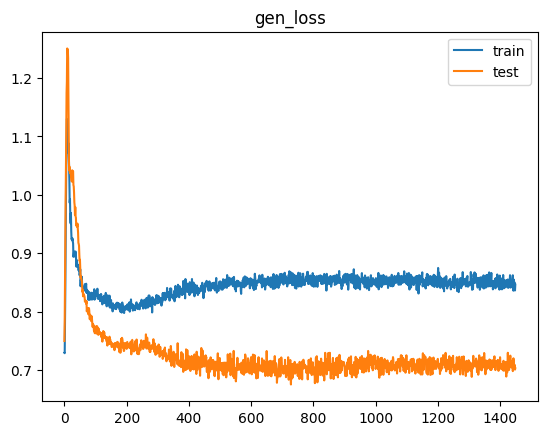

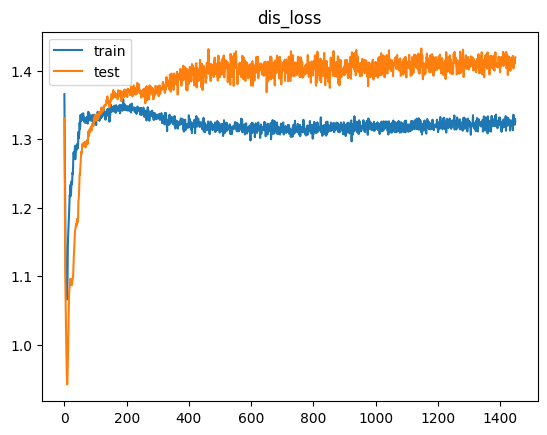

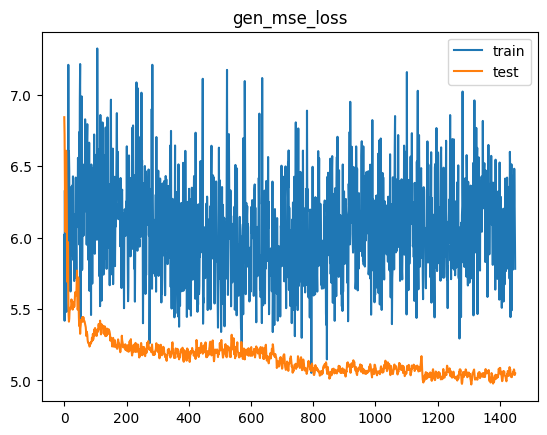

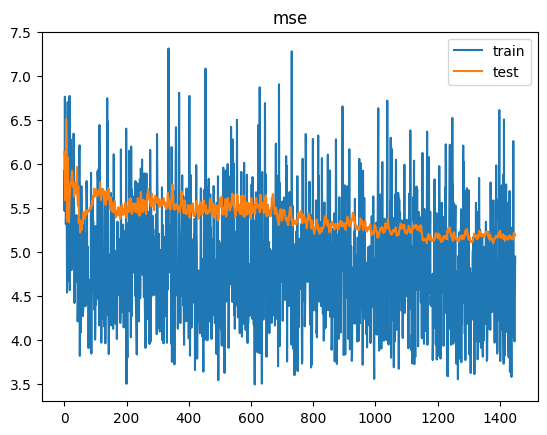

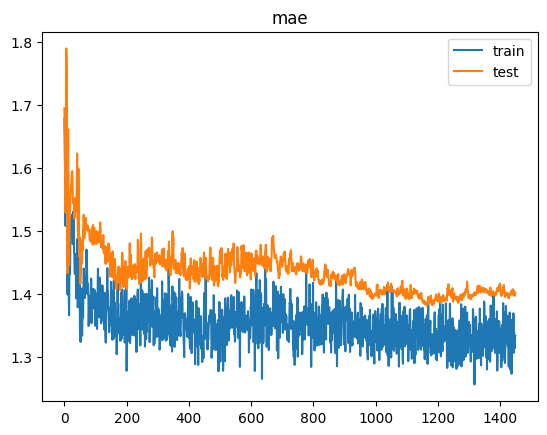

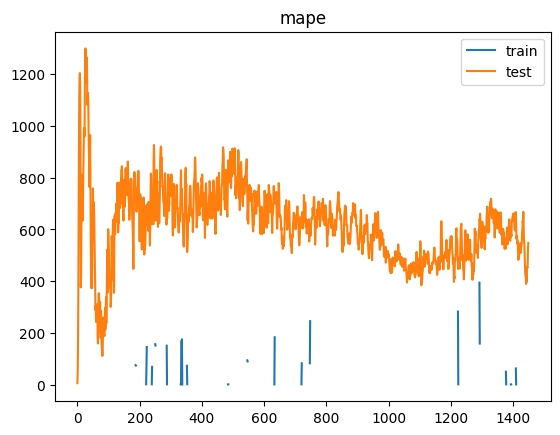

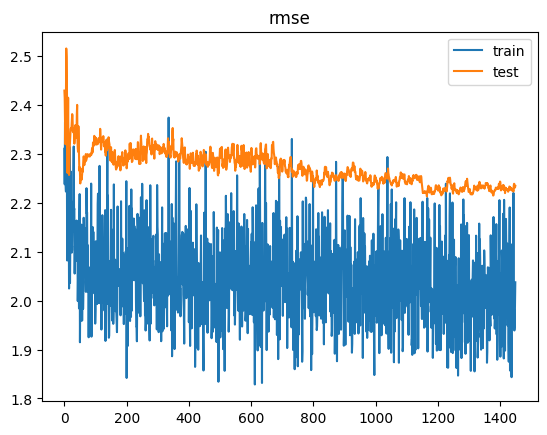

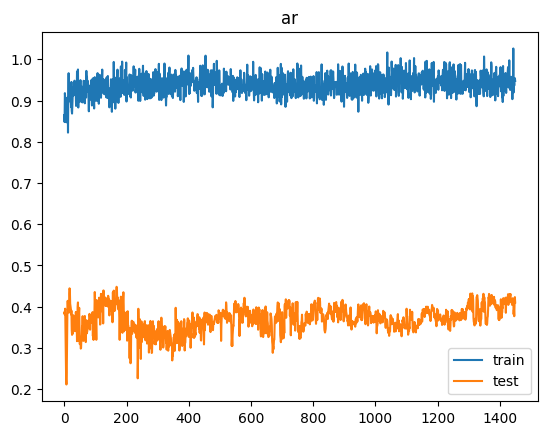

2/2 [==============================] - 1s 4ms/step


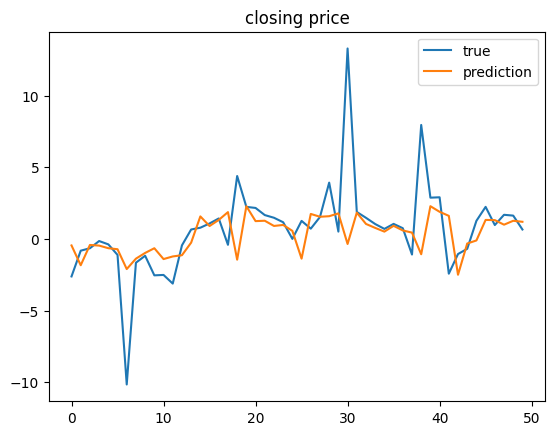

[MSE Baseline] train: 4.842597073813132  test: 5.023830941163814
Delta time with epochs = 1450: 0:25:43.563969
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 5, 20)       1440        ['input_7[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 5, 27)        0           ['bidirectional_12[0][0]',       
                                                                  'input_7[0][0]

Time for epoch 46 is 1.0710570812225342 sec Generator Loss: 0.8539377450942993,  Discriminator_loss: 1.3332374095916748
Time for epoch 47 is 1.070033073425293 sec Generator Loss: 0.8490955233573914,  Discriminator_loss: 1.3537739515304565
Time for epoch 48 is 1.0304534435272217 sec Generator Loss: 0.8514444828033447,  Discriminator_loss: 1.3142462968826294
Time for epoch 49 is 1.041682481765747 sec Generator Loss: 0.8431366086006165,  Discriminator_loss: 1.3242405652999878
Time for epoch 50 is 1.0309727191925049 sec Generator Loss: 0.8444489240646362,  Discriminator_loss: 1.3439710140228271
Time for epoch 51 is 1.0157430171966553 sec Generator Loss: 0.8310849666595459,  Discriminator_loss: 1.3378283977508545
Time for epoch 52 is 1.1417229175567627 sec Generator Loss: 0.8368683457374573,  Discriminator_loss: 1.3144134283065796
Time for epoch 53 is 1.0453236103057861 sec Generator Loss: 0.8344598412513733,  Discriminator_loss: 1.3358733654022217
Time for epoch 54 is 1.0505952835083008 se

Time for epoch 115 is 1.1273009777069092 sec Generator Loss: 0.8144253492355347,  Discriminator_loss: 1.3386826515197754
Time for epoch 116 is 1.0685079097747803 sec Generator Loss: 0.8131958842277527,  Discriminator_loss: 1.345874547958374
Time for epoch 117 is 1.0862693786621094 sec Generator Loss: 0.8165810704231262,  Discriminator_loss: 1.3391517400741577
Time for epoch 118 is 1.0818042755126953 sec Generator Loss: 0.8168090581893921,  Discriminator_loss: 1.3405638933181763
Time for epoch 119 is 1.0995283126831055 sec Generator Loss: 0.8187305331230164,  Discriminator_loss: 1.330637812614441
Time for epoch 120 is 1.0953104496002197 sec Generator Loss: 0.8159182071685791,  Discriminator_loss: 1.3425747156143188
Time for epoch 121 is 1.073767900466919 sec Generator Loss: 0.8298137187957764,  Discriminator_loss: 1.3329678773880005
Time for epoch 122 is 1.0762667655944824 sec Generator Loss: 0.8175075650215149,  Discriminator_loss: 1.3454328775405884
Time for epoch 123 is 1.14332771301

Time for epoch 184 is 1.035569429397583 sec Generator Loss: 0.7951963543891907,  Discriminator_loss: 1.350869059562683
Time for epoch 185 is 1.0650460720062256 sec Generator Loss: 0.7990893125534058,  Discriminator_loss: 1.3570280075073242
Time for epoch 186 is 1.0433666706085205 sec Generator Loss: 0.7995829582214355,  Discriminator_loss: 1.3488155603408813
Time for epoch 187 is 1.0125946998596191 sec Generator Loss: 0.8000029921531677,  Discriminator_loss: 1.3466897010803223
Time for epoch 188 is 1.0156352519989014 sec Generator Loss: 0.8018261194229126,  Discriminator_loss: 1.3515501022338867
Time for epoch 189 is 1.0673487186431885 sec Generator Loss: 0.7996752262115479,  Discriminator_loss: 1.3511464595794678
Time for epoch 190 is 1.0144133567810059 sec Generator Loss: 0.8050671219825745,  Discriminator_loss: 1.344305157661438
Time for epoch 191 is 1.1284737586975098 sec Generator Loss: 0.7962058782577515,  Discriminator_loss: 1.3495113849639893
Time for epoch 192 is 1.18357491493

Time for epoch 253 is 1.0260424613952637 sec Generator Loss: 0.8020867705345154,  Discriminator_loss: 1.35072922706604
Time for epoch 254 is 1.0639195442199707 sec Generator Loss: 0.8003183603286743,  Discriminator_loss: 1.344763159751892
Time for epoch 255 is 1.0378544330596924 sec Generator Loss: 0.8041830062866211,  Discriminator_loss: 1.343998670578003
Time for epoch 256 is 1.0302293300628662 sec Generator Loss: 0.8101067543029785,  Discriminator_loss: 1.3407139778137207
Time for epoch 257 is 1.0228512287139893 sec Generator Loss: 0.7991835474967957,  Discriminator_loss: 1.3472503423690796
Time for epoch 258 is 1.0099194049835205 sec Generator Loss: 0.8024683594703674,  Discriminator_loss: 1.3463513851165771
Time for epoch 259 is 1.0128521919250488 sec Generator Loss: 0.8115313053131104,  Discriminator_loss: 1.3380985260009766
Time for epoch 260 is 1.0256977081298828 sec Generator Loss: 0.8083440065383911,  Discriminator_loss: 1.343949317932129
Time for epoch 261 is 1.0371305942535

Time for epoch 322 is 1.0343844890594482 sec Generator Loss: 0.8143379092216492,  Discriminator_loss: 1.3393627405166626
Time for epoch 323 is 1.0351877212524414 sec Generator Loss: 0.8256911039352417,  Discriminator_loss: 1.3293609619140625
Time for epoch 324 is 1.072284460067749 sec Generator Loss: 0.8265122771263123,  Discriminator_loss: 1.3358865976333618
Time for epoch 325 is 1.0670068264007568 sec Generator Loss: 0.8268991708755493,  Discriminator_loss: 1.3259000778198242
Time for epoch 326 is 1.0686914920806885 sec Generator Loss: 0.8234924674034119,  Discriminator_loss: 1.3350814580917358
Time for epoch 327 is 1.0309698581695557 sec Generator Loss: 0.8220465779304504,  Discriminator_loss: 1.3329691886901855
Time for epoch 328 is 1.027287483215332 sec Generator Loss: 0.8221949338912964,  Discriminator_loss: 1.331847071647644
Time for epoch 329 is 1.0587921142578125 sec Generator Loss: 0.8216248154640198,  Discriminator_loss: 1.3301448822021484
Time for epoch 330 is 1.03505015373

Time for epoch 391 is 1.1088666915893555 sec Generator Loss: 0.8390471339225769,  Discriminator_loss: 1.3255412578582764
Time for epoch 392 is 1.0884182453155518 sec Generator Loss: 0.8212902545928955,  Discriminator_loss: 1.3345857858657837
Time for epoch 393 is 1.0837295055389404 sec Generator Loss: 0.8381955623626709,  Discriminator_loss: 1.3205060958862305
Time for epoch 394 is 1.0758213996887207 sec Generator Loss: 0.8254848122596741,  Discriminator_loss: 1.3253169059753418
Time for epoch 395 is 1.1581079959869385 sec Generator Loss: 0.8439415693283081,  Discriminator_loss: 1.3210312128067017
Time for epoch 396 is 1.138256549835205 sec Generator Loss: 0.8283510804176331,  Discriminator_loss: 1.325370192527771
Time for epoch 397 is 1.1130409240722656 sec Generator Loss: 0.8385851383209229,  Discriminator_loss: 1.3286861181259155
Time for epoch 398 is 1.0868031978607178 sec Generator Loss: 0.8350141644477844,  Discriminator_loss: 1.3280436992645264
Time for epoch 399 is 1.1397306919

Time for epoch 459 is 1.1360058784484863 sec Generator Loss: 0.8365257978439331,  Discriminator_loss: 1.323117733001709
Time for epoch 460 is 1.1344654560089111 sec Generator Loss: 0.8272780179977417,  Discriminator_loss: 1.324404239654541
Time for epoch 461 is 1.1277494430541992 sec Generator Loss: 0.8301935791969299,  Discriminator_loss: 1.3250010013580322
Time for epoch 462 is 1.093446969985962 sec Generator Loss: 0.8327902555465698,  Discriminator_loss: 1.3239747285842896
Time for epoch 463 is 1.0460026264190674 sec Generator Loss: 0.8371667861938477,  Discriminator_loss: 1.3190739154815674
Time for epoch 464 is 1.1127068996429443 sec Generator Loss: 0.8308168649673462,  Discriminator_loss: 1.3330680131912231
Time for epoch 465 is 1.0470948219299316 sec Generator Loss: 0.8439823389053345,  Discriminator_loss: 1.314998984336853
Time for epoch 466 is 1.0669152736663818 sec Generator Loss: 0.8385248780250549,  Discriminator_loss: 1.3267282247543335
Time for epoch 467 is 1.109130859375

Time for epoch 528 is 1.0257387161254883 sec Generator Loss: 0.8446775674819946,  Discriminator_loss: 1.3175591230392456
Time for epoch 529 is 1.1504063606262207 sec Generator Loss: 0.8479025959968567,  Discriminator_loss: 1.3203438520431519
Time for epoch 530 is 1.050940752029419 sec Generator Loss: 0.8513600826263428,  Discriminator_loss: 1.3157155513763428
Time for epoch 531 is 1.0471477508544922 sec Generator Loss: 0.8444289565086365,  Discriminator_loss: 1.3246064186096191
Time for epoch 532 is 1.0382885932922363 sec Generator Loss: 0.8381777405738831,  Discriminator_loss: 1.3183939456939697
Time for epoch 533 is 1.0615904331207275 sec Generator Loss: 0.8435954451560974,  Discriminator_loss: 1.3211562633514404
Time for epoch 534 is 1.0680608749389648 sec Generator Loss: 0.8271901607513428,  Discriminator_loss: 1.3287196159362793
Time for epoch 535 is 1.0593957901000977 sec Generator Loss: 0.8381979465484619,  Discriminator_loss: 1.3218456506729126
Time for epoch 536 is 1.029430150

Time for epoch 597 is 1.045926570892334 sec Generator Loss: 0.846310555934906,  Discriminator_loss: 1.3129109144210815
Time for epoch 598 is 1.1001543998718262 sec Generator Loss: 0.8426846861839294,  Discriminator_loss: 1.3181049823760986
Time for epoch 599 is 1.0797266960144043 sec Generator Loss: 0.854478120803833,  Discriminator_loss: 1.3127588033676147
Time for epoch 600 is 1.0809040069580078 sec Generator Loss: 0.8418956995010376,  Discriminator_loss: 1.3221710920333862
Time for epoch 601 is 1.075195550918579 sec Generator Loss: 0.8532269597053528,  Discriminator_loss: 1.3168244361877441
Time for epoch 602 is 1.0365664958953857 sec Generator Loss: 0.8400561213493347,  Discriminator_loss: 1.324059247970581
Time for epoch 603 is 1.1012141704559326 sec Generator Loss: 0.8448581695556641,  Discriminator_loss: 1.3173136711120605
Time for epoch 604 is 1.0582683086395264 sec Generator Loss: 0.8430070877075195,  Discriminator_loss: 1.3184936046600342
Time for epoch 605 is 1.0376608371734

Time for epoch 666 is 1.0419681072235107 sec Generator Loss: 0.8447058200836182,  Discriminator_loss: 1.3149982690811157
Time for epoch 667 is 1.0637049674987793 sec Generator Loss: 0.8404941558837891,  Discriminator_loss: 1.317165493965149
Time for epoch 668 is 1.1342535018920898 sec Generator Loss: 0.8550189137458801,  Discriminator_loss: 1.3159316778182983
Time for epoch 669 is 1.1285150051116943 sec Generator Loss: 0.8447255492210388,  Discriminator_loss: 1.3179080486297607
Time for epoch 670 is 1.1491079330444336 sec Generator Loss: 0.8510392904281616,  Discriminator_loss: 1.3135038614273071
Time for epoch 671 is 1.17012357711792 sec Generator Loss: 0.8482158780097961,  Discriminator_loss: 1.319974660873413
Time for epoch 672 is 1.1877741813659668 sec Generator Loss: 0.8500446677207947,  Discriminator_loss: 1.3180153369903564
Time for epoch 673 is 1.3170502185821533 sec Generator Loss: 0.8485346436500549,  Discriminator_loss: 1.3207578659057617
Time for epoch 674 is 1.128224372863

Time for epoch 735 is 1.188415765762329 sec Generator Loss: 0.8547151684761047,  Discriminator_loss: 1.3104900121688843
Time for epoch 736 is 1.1222209930419922 sec Generator Loss: 0.8407323956489563,  Discriminator_loss: 1.3218811750411987
Time for epoch 737 is 1.1199069023132324 sec Generator Loss: 0.859672486782074,  Discriminator_loss: 1.311607003211975
Time for epoch 738 is 1.1327641010284424 sec Generator Loss: 0.8682177066802979,  Discriminator_loss: 1.308696985244751
Time for epoch 739 is 1.1215744018554688 sec Generator Loss: 0.8462755084037781,  Discriminator_loss: 1.3116018772125244
Time for epoch 740 is 1.1515817642211914 sec Generator Loss: 0.8457218408584595,  Discriminator_loss: 1.313492774963379
Time for epoch 741 is 1.1839487552642822 sec Generator Loss: 0.8510706424713135,  Discriminator_loss: 1.3163992166519165
Time for epoch 742 is 1.0763626098632812 sec Generator Loss: 0.8451224565505981,  Discriminator_loss: 1.3235780000686646
Time for epoch 743 is 1.1127386093139

Time for epoch 804 is 1.0368175506591797 sec Generator Loss: 0.8453942537307739,  Discriminator_loss: 1.319882869720459
Time for epoch 805 is 1.0557215213775635 sec Generator Loss: 0.852126955986023,  Discriminator_loss: 1.3114389181137085
Time for epoch 806 is 1.0507972240447998 sec Generator Loss: 0.851667582988739,  Discriminator_loss: 1.324499249458313
Time for epoch 807 is 1.130662441253662 sec Generator Loss: 0.8486213088035583,  Discriminator_loss: 1.3142369985580444
Time for epoch 808 is 1.0746114253997803 sec Generator Loss: 0.8465622067451477,  Discriminator_loss: 1.326610803604126
Time for epoch 809 is 1.0740511417388916 sec Generator Loss: 0.8449558019638062,  Discriminator_loss: 1.328900933265686
Time for epoch 810 is 1.056516170501709 sec Generator Loss: 0.8421173691749573,  Discriminator_loss: 1.3195180892944336
Time for epoch 811 is 1.062291145324707 sec Generator Loss: 0.8443739414215088,  Discriminator_loss: 1.3245024681091309
Time for epoch 812 is 1.109506607055664 s

Time for epoch 873 is 1.0620460510253906 sec Generator Loss: 0.8506039381027222,  Discriminator_loss: 1.3108012676239014
Time for epoch 874 is 1.0670983791351318 sec Generator Loss: 0.8638982772827148,  Discriminator_loss: 1.31331467628479
Time for epoch 875 is 1.1015136241912842 sec Generator Loss: 0.8481641411781311,  Discriminator_loss: 1.3227382898330688
Time for epoch 876 is 1.0709736347198486 sec Generator Loss: 0.8479968309402466,  Discriminator_loss: 1.3185441493988037
Time for epoch 877 is 1.1093618869781494 sec Generator Loss: 0.857476532459259,  Discriminator_loss: 1.3168411254882812
Time for epoch 878 is 1.0942583084106445 sec Generator Loss: 0.8477916717529297,  Discriminator_loss: 1.3221116065979004
Time for epoch 879 is 1.097043752670288 sec Generator Loss: 0.8558157682418823,  Discriminator_loss: 1.3111158609390259
Time for epoch 880 is 1.1120929718017578 sec Generator Loss: 0.8561586141586304,  Discriminator_loss: 1.3151288032531738
Time for epoch 881 is 1.073371410369

Time for epoch 942 is 1.164776086807251 sec Generator Loss: 0.8582069277763367,  Discriminator_loss: 1.31533944606781
Time for epoch 943 is 1.139855146408081 sec Generator Loss: 0.8647584915161133,  Discriminator_loss: 1.317609190940857
Time for epoch 944 is 1.1138293743133545 sec Generator Loss: 0.8473310470581055,  Discriminator_loss: 1.3219274282455444
Time for epoch 945 is 1.131371259689331 sec Generator Loss: 0.8453340530395508,  Discriminator_loss: 1.3207156658172607
Time for epoch 946 is 1.207998514175415 sec Generator Loss: 0.8505603075027466,  Discriminator_loss: 1.324328064918518
Time for epoch 947 is 1.1815237998962402 sec Generator Loss: 0.8498257994651794,  Discriminator_loss: 1.325297474861145
Time for epoch 948 is 1.124713659286499 sec Generator Loss: 0.8449899554252625,  Discriminator_loss: 1.3148952722549438
Time for epoch 949 is 1.184926986694336 sec Generator Loss: 0.846323549747467,  Discriminator_loss: 1.329921841621399
Time for epoch 950 is 1.2011988162994385 sec 

Time for epoch 1010 is 1.0874884128570557 sec Generator Loss: 0.8620192408561707,  Discriminator_loss: 1.3060823678970337
Time for epoch 1011 is 1.0814127922058105 sec Generator Loss: 0.8590680956840515,  Discriminator_loss: 1.3104915618896484
Time for epoch 1012 is 1.1422481536865234 sec Generator Loss: 0.8613976240158081,  Discriminator_loss: 1.3170108795166016
Time for epoch 1013 is 1.0840537548065186 sec Generator Loss: 0.854621410369873,  Discriminator_loss: 1.3170437812805176
Time for epoch 1014 is 1.0886375904083252 sec Generator Loss: 0.8578565716743469,  Discriminator_loss: 1.3167674541473389
Time for epoch 1015 is 1.0633676052093506 sec Generator Loss: 0.8556415438652039,  Discriminator_loss: 1.313974380493164
Time for epoch 1016 is 1.0687832832336426 sec Generator Loss: 0.853295087814331,  Discriminator_loss: 1.3261021375656128
Time for epoch 1017 is 1.1153662204742432 sec Generator Loss: 0.8416392207145691,  Discriminator_loss: 1.3298455476760864
Time for epoch 1018 is 1.07

Time for epoch 1078 is 1.0057344436645508 sec Generator Loss: 0.8451854586601257,  Discriminator_loss: 1.3241838216781616
Time for epoch 1079 is 1.031710147857666 sec Generator Loss: 0.8582549095153809,  Discriminator_loss: 1.3114204406738281
Time for epoch 1080 is 1.0080571174621582 sec Generator Loss: 0.8442237377166748,  Discriminator_loss: 1.325714349746704
Time for epoch 1081 is 0.9850976467132568 sec Generator Loss: 0.8475725650787354,  Discriminator_loss: 1.3251349925994873
Time for epoch 1082 is 0.9968276023864746 sec Generator Loss: 0.8567444086074829,  Discriminator_loss: 1.3236980438232422
Time for epoch 1083 is 0.9974198341369629 sec Generator Loss: 0.852235734462738,  Discriminator_loss: 1.3204561471939087
Time for epoch 1084 is 1.0068397521972656 sec Generator Loss: 0.8465779423713684,  Discriminator_loss: 1.3302876949310303
Time for epoch 1085 is 1.0518689155578613 sec Generator Loss: 0.852185845375061,  Discriminator_loss: 1.3224157094955444
Time for epoch 1086 is 1.043

Time for epoch 1146 is 1.0937738418579102 sec Generator Loss: 0.85554039478302,  Discriminator_loss: 1.319333791732788
Time for epoch 1147 is 1.1099960803985596 sec Generator Loss: 0.8477259874343872,  Discriminator_loss: 1.3212361335754395
Time for epoch 1148 is 1.0799055099487305 sec Generator Loss: 0.8574085831642151,  Discriminator_loss: 1.3172028064727783
Time for epoch 1149 is 1.2043569087982178 sec Generator Loss: 0.8502627611160278,  Discriminator_loss: 1.322192668914795
Time for epoch 1150 is 1.080414056777954 sec Generator Loss: 0.8465556502342224,  Discriminator_loss: 1.3249658346176147
Time for epoch 1151 is 1.1345293521881104 sec Generator Loss: 0.8705113530158997,  Discriminator_loss: 1.3101898431777954
Time for epoch 1152 is 1.128288745880127 sec Generator Loss: 0.8445726633071899,  Discriminator_loss: 1.3241819143295288
Time for epoch 1153 is 1.1622207164764404 sec Generator Loss: 0.8389833569526672,  Discriminator_loss: 1.3281517028808594
Time for epoch 1154 is 1.19639

Time for epoch 1214 is 1.1732079982757568 sec Generator Loss: 0.8347355723381042,  Discriminator_loss: 1.32413649559021
Time for epoch 1215 is 1.188642978668213 sec Generator Loss: 0.8469024300575256,  Discriminator_loss: 1.3235342502593994
Time for epoch 1216 is 1.1639142036437988 sec Generator Loss: 0.8658702373504639,  Discriminator_loss: 1.3214969635009766
Time for epoch 1217 is 1.1569972038269043 sec Generator Loss: 0.8495816588401794,  Discriminator_loss: 1.3177123069763184
Time for epoch 1218 is 1.219245195388794 sec Generator Loss: 0.8636715412139893,  Discriminator_loss: 1.3113540410995483
Time for epoch 1219 is 1.1959598064422607 sec Generator Loss: 0.8679455518722534,  Discriminator_loss: 1.3161031007766724
Time for epoch 1220 is 1.154789924621582 sec Generator Loss: 0.8565542697906494,  Discriminator_loss: 1.3162792921066284
Time for epoch 1221 is 1.1665070056915283 sec Generator Loss: 0.8479423522949219,  Discriminator_loss: 1.3201097249984741
Time for epoch 1222 is 1.1406

Time for epoch 1282 is 1.1243946552276611 sec Generator Loss: 0.8426081538200378,  Discriminator_loss: 1.3146872520446777
Time for epoch 1283 is 1.1236915588378906 sec Generator Loss: 0.8521179556846619,  Discriminator_loss: 1.3233907222747803
Time for epoch 1284 is 1.1687304973602295 sec Generator Loss: 0.8444525003433228,  Discriminator_loss: 1.3257417678833008
Time for epoch 1285 is 1.1109960079193115 sec Generator Loss: 0.8387376070022583,  Discriminator_loss: 1.3304593563079834
Time for epoch 1286 is 1.107593297958374 sec Generator Loss: 0.8474716544151306,  Discriminator_loss: 1.3221155405044556
Time for epoch 1287 is 1.15934419631958 sec Generator Loss: 0.8520093560218811,  Discriminator_loss: 1.3137133121490479
Time for epoch 1288 is 1.1379952430725098 sec Generator Loss: 0.8569778203964233,  Discriminator_loss: 1.3202929496765137
Time for epoch 1289 is 1.1042227745056152 sec Generator Loss: 0.8502782583236694,  Discriminator_loss: 1.3215519189834595
Time for epoch 1290 is 1.13

Time for epoch 1350 is 1.1374800205230713 sec Generator Loss: 0.8549757599830627,  Discriminator_loss: 1.3209894895553589
Time for epoch 1351 is 1.1446471214294434 sec Generator Loss: 0.8545281291007996,  Discriminator_loss: 1.3162248134613037
Time for epoch 1352 is 1.1499500274658203 sec Generator Loss: 0.8609148859977722,  Discriminator_loss: 1.3225345611572266
Time for epoch 1353 is 1.1375741958618164 sec Generator Loss: 0.8562755584716797,  Discriminator_loss: 1.3164349794387817
Time for epoch 1354 is 1.1112399101257324 sec Generator Loss: 0.8547762632369995,  Discriminator_loss: 1.3217214345932007
Time for epoch 1355 is 1.1394882202148438 sec Generator Loss: 0.8546414971351624,  Discriminator_loss: 1.3254505395889282
Time for epoch 1356 is 1.1282086372375488 sec Generator Loss: 0.8525317311286926,  Discriminator_loss: 1.31792151927948
Time for epoch 1357 is 1.2712655067443848 sec Generator Loss: 0.8517358899116516,  Discriminator_loss: 1.3227442502975464
Time for epoch 1358 is 1.1

Time for epoch 1418 is 1.1684346199035645 sec Generator Loss: 0.8714488744735718,  Discriminator_loss: 1.315840482711792
Time for epoch 1419 is 1.1664493083953857 sec Generator Loss: 0.8576100468635559,  Discriminator_loss: 1.3243681192398071
Time for epoch 1420 is 1.2020385265350342 sec Generator Loss: 0.8645607829093933,  Discriminator_loss: 1.313015103340149
Time for epoch 1421 is 1.241762638092041 sec Generator Loss: 0.8567136526107788,  Discriminator_loss: 1.3194301128387451
Time for epoch 1422 is 1.1983850002288818 sec Generator Loss: 0.8566836714744568,  Discriminator_loss: 1.3244478702545166
Time for epoch 1423 is 1.1531789302825928 sec Generator Loss: 0.8567605018615723,  Discriminator_loss: 1.3220696449279785
Time for epoch 1424 is 1.2046427726745605 sec Generator Loss: 0.8516336679458618,  Discriminator_loss: 1.3178603649139404
Time for epoch 1425 is 1.1636147499084473 sec Generator Loss: 0.8549153804779053,  Discriminator_loss: 1.3134143352508545
Time for epoch 1426 is 1.19

Time for epoch 1486 is 1.1756739616394043 sec Generator Loss: 0.8453696370124817,  Discriminator_loss: 1.3286726474761963
Time for epoch 1487 is 1.157799482345581 sec Generator Loss: 0.849205732345581,  Discriminator_loss: 1.3296442031860352
Time for epoch 1488 is 1.14872145652771 sec Generator Loss: 0.8554897904396057,  Discriminator_loss: 1.3207554817199707
Time for epoch 1489 is 1.2108824253082275 sec Generator Loss: 0.853198766708374,  Discriminator_loss: 1.3272037506103516
Time for epoch 1490 is 1.1553528308868408 sec Generator Loss: 0.8453608155250549,  Discriminator_loss: 1.3288761377334595
Time for epoch 1491 is 1.141512393951416 sec Generator Loss: 0.8393856883049011,  Discriminator_loss: 1.3300622701644897
Time for epoch 1492 is 1.1393277645111084 sec Generator Loss: 0.8603247404098511,  Discriminator_loss: 1.3132587671279907
Time for epoch 1493 is 1.14263916015625 sec Generator Loss: 0.8530928492546082,  Discriminator_loss: 1.322750449180603
Time for epoch 1494 is 1.18367147

Time for epoch 1554 is 1.1499598026275635 sec Generator Loss: 0.8663321137428284,  Discriminator_loss: 1.3143773078918457
Time for epoch 1555 is 1.1191041469573975 sec Generator Loss: 0.8662469387054443,  Discriminator_loss: 1.3156243562698364
Time for epoch 1556 is 1.1450591087341309 sec Generator Loss: 0.8563170433044434,  Discriminator_loss: 1.3199615478515625
Time for epoch 1557 is 1.1618871688842773 sec Generator Loss: 0.8640454411506653,  Discriminator_loss: 1.3217030763626099
Time for epoch 1558 is 1.1436238288879395 sec Generator Loss: 0.8537140488624573,  Discriminator_loss: 1.3198559284210205
Time for epoch 1559 is 1.1627554893493652 sec Generator Loss: 0.8512783646583557,  Discriminator_loss: 1.3231548070907593
Time for epoch 1560 is 1.1431841850280762 sec Generator Loss: 0.8465306162834167,  Discriminator_loss: 1.3242297172546387
Time for epoch 1561 is 1.165273904800415 sec Generator Loss: 0.8512516021728516,  Discriminator_loss: 1.323876142501831
Time for epoch 1562 is 1.2

Time for epoch 1622 is 1.198857069015503 sec Generator Loss: 0.8598405718803406,  Discriminator_loss: 1.3205196857452393
Time for epoch 1623 is 1.2232983112335205 sec Generator Loss: 0.8499281406402588,  Discriminator_loss: 1.3238781690597534
Time for epoch 1624 is 1.209763765335083 sec Generator Loss: 0.8477798700332642,  Discriminator_loss: 1.3225252628326416
Time for epoch 1625 is 1.2105987071990967 sec Generator Loss: 0.856399416923523,  Discriminator_loss: 1.3211190700531006
Time for epoch 1626 is 1.2253472805023193 sec Generator Loss: 0.8623024225234985,  Discriminator_loss: 1.3176265954971313
Time for epoch 1627 is 1.1826236248016357 sec Generator Loss: 0.8576339483261108,  Discriminator_loss: 1.3228089809417725
Time for epoch 1628 is 1.197213888168335 sec Generator Loss: 0.85801762342453,  Discriminator_loss: 1.325789451599121
Time for epoch 1629 is 1.2591800689697266 sec Generator Loss: 0.8600390553474426,  Discriminator_loss: 1.316831350326538
Time for epoch 1630 is 1.2376143

Time for epoch 1690 is 1.2603156566619873 sec Generator Loss: 0.856304407119751,  Discriminator_loss: 1.3263914585113525
Time for epoch 1691 is 1.202345609664917 sec Generator Loss: 0.8478869199752808,  Discriminator_loss: 1.321286916732788
Time for epoch 1692 is 1.2107834815979004 sec Generator Loss: 0.8546291589736938,  Discriminator_loss: 1.3292793035507202
Time for epoch 1693 is 1.1891546249389648 sec Generator Loss: 0.8577828407287598,  Discriminator_loss: 1.3181438446044922
Time for epoch 1694 is 1.1530497074127197 sec Generator Loss: 0.8591752648353577,  Discriminator_loss: 1.3160241842269897
Time for epoch 1695 is 1.1994235515594482 sec Generator Loss: 0.8471843600273132,  Discriminator_loss: 1.3257992267608643
Time for epoch 1696 is 1.2431340217590332 sec Generator Loss: 0.8521770238876343,  Discriminator_loss: 1.3205174207687378
Time for epoch 1697 is 1.1109771728515625 sec Generator Loss: 0.8450636863708496,  Discriminator_loss: 1.3289285898208618
Time for epoch 1698 is 1.18

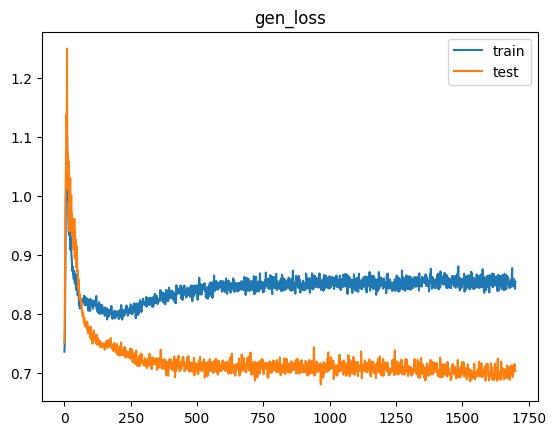

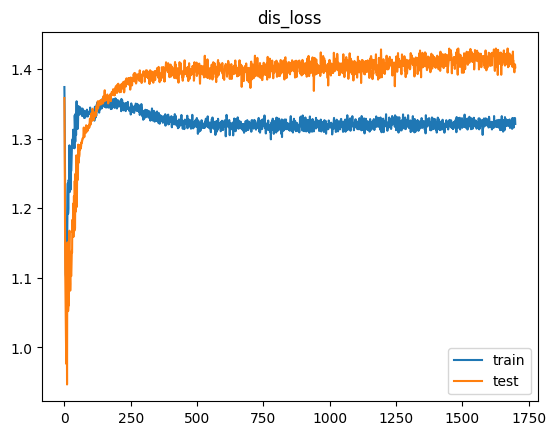

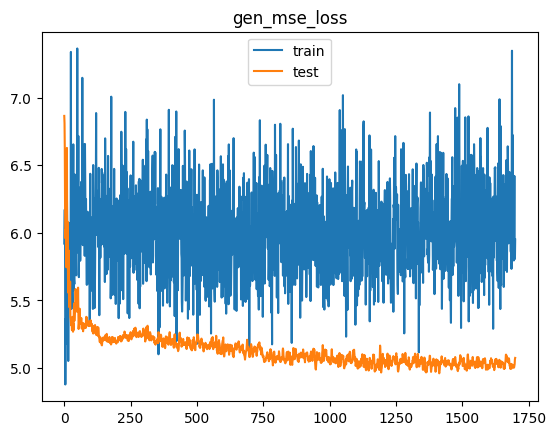

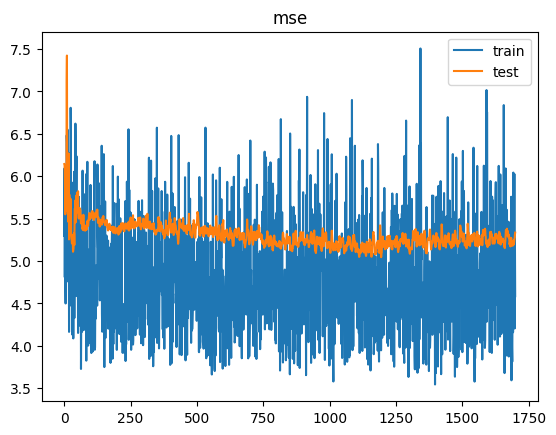

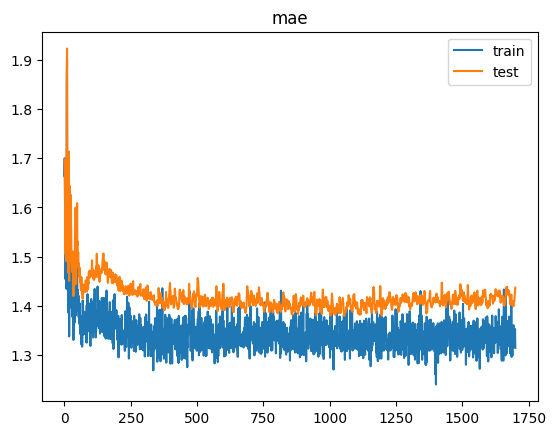

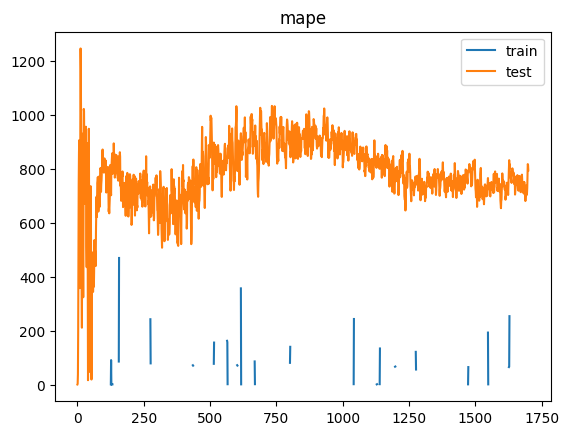

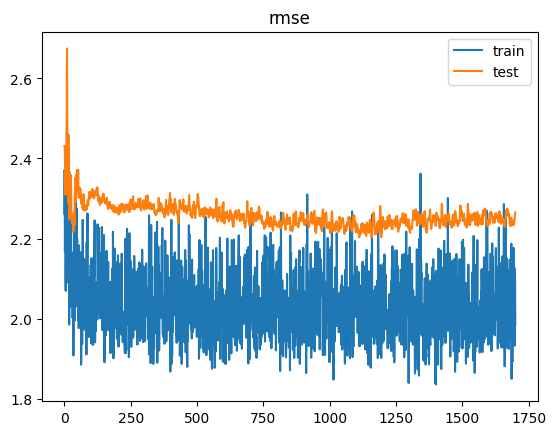

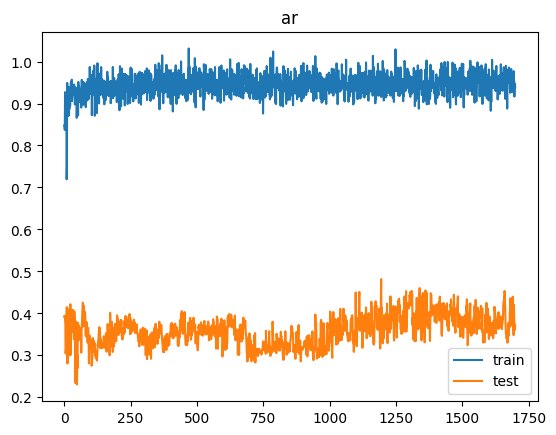

2/2 [==============================] - 1s 3ms/step


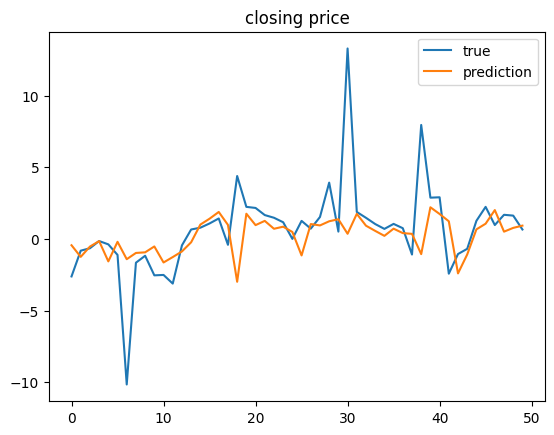

[MSE Baseline] train: 4.746274205889186  test: 5.023830941163814
Delta time with epochs = 1700: 0:32:02.297143
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 5, 20)       1440        ['input_8[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 5, 27)        0           ['bidirectional_14[0][0]',       
                                                                  'input_8[0][0]

Time for epoch 46 is 1.1038775444030762 sec Generator Loss: 0.825942873954773,  Discriminator_loss: 1.3364535570144653
Time for epoch 47 is 1.1069846153259277 sec Generator Loss: 0.8297678828239441,  Discriminator_loss: 1.3334739208221436
Time for epoch 48 is 1.1261539459228516 sec Generator Loss: 0.830308735370636,  Discriminator_loss: 1.334233045578003
Time for epoch 49 is 1.1661276817321777 sec Generator Loss: 0.8340961337089539,  Discriminator_loss: 1.3362711668014526
Time for epoch 50 is 1.116539716720581 sec Generator Loss: 0.8316060304641724,  Discriminator_loss: 1.3372348546981812
Time for epoch 51 is 1.1403582096099854 sec Generator Loss: 0.8169397711753845,  Discriminator_loss: 1.3476135730743408
Time for epoch 52 is 1.1736114025115967 sec Generator Loss: 0.8131378293037415,  Discriminator_loss: 1.3514515161514282
Time for epoch 53 is 1.133620262145996 sec Generator Loss: 0.8178344368934631,  Discriminator_loss: 1.338854432106018
Time for epoch 54 is 1.1967413425445557 sec Ge

Time for epoch 115 is 1.2097434997558594 sec Generator Loss: 0.804130494594574,  Discriminator_loss: 1.345369815826416
Time for epoch 116 is 1.190706729888916 sec Generator Loss: 0.8067365288734436,  Discriminator_loss: 1.3540031909942627
Time for epoch 117 is 1.1637227535247803 sec Generator Loss: 0.8047751188278198,  Discriminator_loss: 1.3490064144134521
Time for epoch 118 is 1.0905804634094238 sec Generator Loss: 0.8024924397468567,  Discriminator_loss: 1.3544542789459229
Time for epoch 119 is 1.0894834995269775 sec Generator Loss: 0.793128490447998,  Discriminator_loss: 1.3536823987960815
Time for epoch 120 is 1.095029592514038 sec Generator Loss: 0.7955084443092346,  Discriminator_loss: 1.3563377857208252
Time for epoch 121 is 1.0662803649902344 sec Generator Loss: 0.8063963055610657,  Discriminator_loss: 1.350197434425354
Time for epoch 122 is 1.1682462692260742 sec Generator Loss: 0.795683741569519,  Discriminator_loss: 1.3530700206756592
Time for epoch 123 is 1.193132162094116

Time for epoch 184 is 1.1157774925231934 sec Generator Loss: 0.8098182678222656,  Discriminator_loss: 1.343146562576294
Time for epoch 185 is 1.1603760719299316 sec Generator Loss: 0.8053126335144043,  Discriminator_loss: 1.3480744361877441
Time for epoch 186 is 1.1276390552520752 sec Generator Loss: 0.7917710542678833,  Discriminator_loss: 1.3491759300231934
Time for epoch 187 is 1.1744704246520996 sec Generator Loss: 0.794224202632904,  Discriminator_loss: 1.3506841659545898
Time for epoch 188 is 1.1008732318878174 sec Generator Loss: 0.7944586873054504,  Discriminator_loss: 1.3466218709945679
Time for epoch 189 is 1.0766429901123047 sec Generator Loss: 0.7930853366851807,  Discriminator_loss: 1.3524574041366577
Time for epoch 190 is 1.082014560699463 sec Generator Loss: 0.8010448813438416,  Discriminator_loss: 1.3408297300338745
Time for epoch 191 is 1.1458699703216553 sec Generator Loss: 0.8045918941497803,  Discriminator_loss: 1.3474940061569214
Time for epoch 192 is 1.11844897270

Time for epoch 253 is 1.120732307434082 sec Generator Loss: 0.8055029511451721,  Discriminator_loss: 1.3437604904174805
Time for epoch 254 is 1.0897724628448486 sec Generator Loss: 0.8112331628799438,  Discriminator_loss: 1.345358967781067
Time for epoch 255 is 1.106172800064087 sec Generator Loss: 0.8064101338386536,  Discriminator_loss: 1.3441684246063232
Time for epoch 256 is 1.1579997539520264 sec Generator Loss: 0.8081276416778564,  Discriminator_loss: 1.3382371664047241
Time for epoch 257 is 1.125211477279663 sec Generator Loss: 0.8056132197380066,  Discriminator_loss: 1.3429266214370728
Time for epoch 258 is 1.1165337562561035 sec Generator Loss: 0.8085951209068298,  Discriminator_loss: 1.3408147096633911
Time for epoch 259 is 1.1115376949310303 sec Generator Loss: 0.8068040013313293,  Discriminator_loss: 1.3409346342086792
Time for epoch 260 is 1.109933853149414 sec Generator Loss: 0.8009129762649536,  Discriminator_loss: 1.343660593032837
Time for epoch 261 is 1.08592391014099

Time for epoch 322 is 1.2315495014190674 sec Generator Loss: 0.8160744905471802,  Discriminator_loss: 1.3304307460784912
Time for epoch 323 is 1.2055573463439941 sec Generator Loss: 0.8217700123786926,  Discriminator_loss: 1.3321952819824219
Time for epoch 324 is 1.1296052932739258 sec Generator Loss: 0.8209928870201111,  Discriminator_loss: 1.3359386920928955
Time for epoch 325 is 1.1412594318389893 sec Generator Loss: 0.8156494498252869,  Discriminator_loss: 1.3359521627426147
Time for epoch 326 is 1.1113944053649902 sec Generator Loss: 0.8123847246170044,  Discriminator_loss: 1.336496353149414
Time for epoch 327 is 1.153181552886963 sec Generator Loss: 0.8210217356681824,  Discriminator_loss: 1.3362268209457397
Time for epoch 328 is 1.1806247234344482 sec Generator Loss: 0.8367592096328735,  Discriminator_loss: 1.3216652870178223
Time for epoch 329 is 1.0906455516815186 sec Generator Loss: 0.826625406742096,  Discriminator_loss: 1.3312369585037231
Time for epoch 330 is 1.15376853942

Time for epoch 390 is 1.1116163730621338 sec Generator Loss: 0.829688310623169,  Discriminator_loss: 1.3229423761367798
Time for epoch 391 is 1.1325972080230713 sec Generator Loss: 0.8318033814430237,  Discriminator_loss: 1.3320521116256714
Time for epoch 392 is 1.0976946353912354 sec Generator Loss: 0.8292397856712341,  Discriminator_loss: 1.328997254371643
Time for epoch 393 is 1.0801963806152344 sec Generator Loss: 0.8251054883003235,  Discriminator_loss: 1.3304545879364014
Time for epoch 394 is 1.0857834815979004 sec Generator Loss: 0.8232030868530273,  Discriminator_loss: 1.3276389837265015
Time for epoch 395 is 1.1065878868103027 sec Generator Loss: 0.8356620073318481,  Discriminator_loss: 1.3208361864089966
Time for epoch 396 is 1.1135108470916748 sec Generator Loss: 0.8345703482627869,  Discriminator_loss: 1.3168895244598389
Time for epoch 397 is 1.0797696113586426 sec Generator Loss: 0.8316164612770081,  Discriminator_loss: 1.332937479019165
Time for epoch 398 is 1.10398221015

Time for epoch 459 is 1.1174910068511963 sec Generator Loss: 0.8327735066413879,  Discriminator_loss: 1.3310471773147583
Time for epoch 460 is 1.1011595726013184 sec Generator Loss: 0.8397804498672485,  Discriminator_loss: 1.3227977752685547
Time for epoch 461 is 1.1100764274597168 sec Generator Loss: 0.842503547668457,  Discriminator_loss: 1.326136589050293
Time for epoch 462 is 1.131394386291504 sec Generator Loss: 0.8367531299591064,  Discriminator_loss: 1.3219592571258545
Time for epoch 463 is 1.1142323017120361 sec Generator Loss: 0.8312031626701355,  Discriminator_loss: 1.3176071643829346
Time for epoch 464 is 1.1131937503814697 sec Generator Loss: 0.8358551263809204,  Discriminator_loss: 1.3243534564971924
Time for epoch 465 is 1.1198017597198486 sec Generator Loss: 0.8412836194038391,  Discriminator_loss: 1.3254250288009644
Time for epoch 466 is 1.1435585021972656 sec Generator Loss: 0.8339195847511292,  Discriminator_loss: 1.3226584196090698
Time for epoch 467 is 1.12049579620

Time for epoch 528 is 1.2150402069091797 sec Generator Loss: 0.8424818515777588,  Discriminator_loss: 1.3221533298492432
Time for epoch 529 is 1.1606371402740479 sec Generator Loss: 0.8320496082305908,  Discriminator_loss: 1.3294541835784912
Time for epoch 530 is 1.2309203147888184 sec Generator Loss: 0.8399543166160583,  Discriminator_loss: 1.3181809186935425
Time for epoch 531 is 1.1692399978637695 sec Generator Loss: 0.8246402144432068,  Discriminator_loss: 1.329280972480774
Time for epoch 532 is 1.1604580879211426 sec Generator Loss: 0.8436678051948547,  Discriminator_loss: 1.3145791292190552
Time for epoch 533 is 1.1950418949127197 sec Generator Loss: 0.8358979821205139,  Discriminator_loss: 1.3250250816345215
Time for epoch 534 is 1.1635088920593262 sec Generator Loss: 0.8291240334510803,  Discriminator_loss: 1.3297473192214966
Time for epoch 535 is 1.1423537731170654 sec Generator Loss: 0.8349750638008118,  Discriminator_loss: 1.3271771669387817
Time for epoch 536 is 1.084171533

Time for epoch 597 is 1.1155166625976562 sec Generator Loss: 0.8342154026031494,  Discriminator_loss: 1.326981782913208
Time for epoch 598 is 1.105170726776123 sec Generator Loss: 0.831656277179718,  Discriminator_loss: 1.325747013092041
Time for epoch 599 is 1.1783082485198975 sec Generator Loss: 0.8375906348228455,  Discriminator_loss: 1.319485068321228
Time for epoch 600 is 1.1493768692016602 sec Generator Loss: 0.8284905552864075,  Discriminator_loss: 1.3316915035247803
Time for epoch 601 is 1.1312620639801025 sec Generator Loss: 0.8233397006988525,  Discriminator_loss: 1.3356313705444336
Time for epoch 602 is 1.128638505935669 sec Generator Loss: 0.832730233669281,  Discriminator_loss: 1.3284274339675903
Time for epoch 603 is 1.1168394088745117 sec Generator Loss: 0.829101026058197,  Discriminator_loss: 1.3236474990844727
Time for epoch 604 is 1.1288037300109863 sec Generator Loss: 0.8293482661247253,  Discriminator_loss: 1.328338861465454
Time for epoch 605 is 1.1005668640136719 

Time for epoch 666 is 1.208366870880127 sec Generator Loss: 0.8439766764640808,  Discriminator_loss: 1.3226258754730225
Time for epoch 667 is 1.1078917980194092 sec Generator Loss: 0.8322190046310425,  Discriminator_loss: 1.3222835063934326
Time for epoch 668 is 1.1389527320861816 sec Generator Loss: 0.8347527384757996,  Discriminator_loss: 1.326923131942749
Time for epoch 669 is 1.1689074039459229 sec Generator Loss: 0.8427132964134216,  Discriminator_loss: 1.326236605644226
Time for epoch 670 is 1.0943958759307861 sec Generator Loss: 0.8412564396858215,  Discriminator_loss: 1.3090912103652954
Time for epoch 671 is 1.1173746585845947 sec Generator Loss: 0.8432430624961853,  Discriminator_loss: 1.3225237131118774
Time for epoch 672 is 1.1150989532470703 sec Generator Loss: 0.8487372398376465,  Discriminator_loss: 1.3278560638427734
Time for epoch 673 is 1.1099128723144531 sec Generator Loss: 0.8378475904464722,  Discriminator_loss: 1.3253896236419678
Time for epoch 674 is 1.15262722969

In [ ]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("dcbilstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 20)        1440        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 5, 27)        0           ['bidirectional[0][0]',          
                                                                  'input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20)          3040        ['concatenate[0][0]']        

Time for epoch 48 is 0.8674061298370361 sec Generator Loss: 0.8181363344192505,  Discriminator_loss: 1.337450385093689
Time for epoch 49 is 0.865103006362915 sec Generator Loss: 0.8236507177352905,  Discriminator_loss: 1.3327312469482422
Time for epoch 50 is 0.862457275390625 sec Generator Loss: 0.8257681131362915,  Discriminator_loss: 1.339167594909668
Time for epoch 51 is 0.882819652557373 sec Generator Loss: 0.823573648929596,  Discriminator_loss: 1.333641767501831
Time for epoch 52 is 0.8666021823883057 sec Generator Loss: 0.8211195468902588,  Discriminator_loss: 1.3389763832092285
Time for epoch 53 is 0.9266388416290283 sec Generator Loss: 0.8250569701194763,  Discriminator_loss: 1.3403652906417847
Time for epoch 54 is 0.8707873821258545 sec Generator Loss: 0.8099458813667297,  Discriminator_loss: 1.3435723781585693
Time for epoch 55 is 0.9573862552642822 sec Generator Loss: 0.8195173740386963,  Discriminator_loss: 1.3387172222137451
Time for epoch 56 is 0.9190316200256348 sec Gen

Time for epoch 117 is 0.9158117771148682 sec Generator Loss: 0.8021112680435181,  Discriminator_loss: 1.3447719812393188
Time for epoch 118 is 0.9493353366851807 sec Generator Loss: 0.7984620332717896,  Discriminator_loss: 1.34713613986969
Time for epoch 119 is 0.9148368835449219 sec Generator Loss: 0.7882856130599976,  Discriminator_loss: 1.3559428453445435
Time for epoch 120 is 0.9491729736328125 sec Generator Loss: 0.7858690023422241,  Discriminator_loss: 1.3550801277160645
Time for epoch 121 is 0.9541707038879395 sec Generator Loss: 0.806668758392334,  Discriminator_loss: 1.348233699798584
Time for epoch 122 is 1.2178046703338623 sec Generator Loss: 0.7971450090408325,  Discriminator_loss: 1.3493883609771729
Time for epoch 123 is 1.0045111179351807 sec Generator Loss: 0.7891599535942078,  Discriminator_loss: 1.3528766632080078
Time for epoch 124 is 0.9454925060272217 sec Generator Loss: 0.7923625707626343,  Discriminator_loss: 1.3487510681152344
Time for epoch 125 is 0.944567918777

Time for epoch 185 is 0.9250853061676025 sec Generator Loss: 0.7995860576629639,  Discriminator_loss: 1.3518955707550049
Time for epoch 186 is 0.8948235511779785 sec Generator Loss: 0.7958288192749023,  Discriminator_loss: 1.3593690395355225
Time for epoch 187 is 0.8969731330871582 sec Generator Loss: 0.795145571231842,  Discriminator_loss: 1.3522884845733643
Time for epoch 188 is 0.8908684253692627 sec Generator Loss: 0.7866801023483276,  Discriminator_loss: 1.3632363080978394
Time for epoch 189 is 0.8946375846862793 sec Generator Loss: 0.7918607592582703,  Discriminator_loss: 1.3601701259613037
Time for epoch 190 is 0.9085779190063477 sec Generator Loss: 0.7945736050605774,  Discriminator_loss: 1.3554610013961792
Time for epoch 191 is 1.002878189086914 sec Generator Loss: 0.7910702228546143,  Discriminator_loss: 1.3590428829193115
Time for epoch 192 is 0.9261157512664795 sec Generator Loss: 0.7947114706039429,  Discriminator_loss: 1.3578376770019531
Time for epoch 193 is 1.0064485073

Time for epoch 253 is 0.8537352085113525 sec Generator Loss: 0.7873039245605469,  Discriminator_loss: 1.3551459312438965
Time for epoch 254 is 0.8675689697265625 sec Generator Loss: 0.796347975730896,  Discriminator_loss: 1.3541350364685059
Time for epoch 255 is 0.8590507507324219 sec Generator Loss: 0.7917359471321106,  Discriminator_loss: 1.3494319915771484
Time for epoch 256 is 0.8687350749969482 sec Generator Loss: 0.8073602318763733,  Discriminator_loss: 1.3444604873657227
Time for epoch 257 is 0.8658499717712402 sec Generator Loss: 0.8023054599761963,  Discriminator_loss: 1.3525046110153198
Time for epoch 258 is 0.8584537506103516 sec Generator Loss: 0.7875863313674927,  Discriminator_loss: 1.3595727682113647
Time for epoch 259 is 0.8547241687774658 sec Generator Loss: 0.7971706390380859,  Discriminator_loss: 1.3546509742736816
Time for epoch 260 is 0.85677170753479 sec Generator Loss: 0.7970696687698364,  Discriminator_loss: 1.355582356452942
Time for epoch 261 is 0.851236343383

Time for epoch 322 is 0.8615882396697998 sec Generator Loss: 0.8109256625175476,  Discriminator_loss: 1.3383697271347046
Time for epoch 323 is 0.8610343933105469 sec Generator Loss: 0.7992954850196838,  Discriminator_loss: 1.350198745727539
Time for epoch 324 is 0.852219820022583 sec Generator Loss: 0.7988046407699585,  Discriminator_loss: 1.3444980382919312
Time for epoch 325 is 0.85524582862854 sec Generator Loss: 0.8109853267669678,  Discriminator_loss: 1.3427042961120605
Time for epoch 326 is 0.8757319450378418 sec Generator Loss: 0.8036804795265198,  Discriminator_loss: 1.3433914184570312
Time for epoch 327 is 0.8584499359130859 sec Generator Loss: 0.79770427942276,  Discriminator_loss: 1.345438838005066
Time for epoch 328 is 0.8543095588684082 sec Generator Loss: 0.8092697262763977,  Discriminator_loss: 1.3416203260421753
Time for epoch 329 is 0.9081149101257324 sec Generator Loss: 0.8099501132965088,  Discriminator_loss: 1.3416098356246948
Time for epoch 330 is 0.899043560028076

Time for epoch 390 is 0.8790833950042725 sec Generator Loss: 0.8199914693832397,  Discriminator_loss: 1.3348972797393799
Time for epoch 391 is 0.8710286617279053 sec Generator Loss: 0.8146412968635559,  Discriminator_loss: 1.340644121170044
Time for epoch 392 is 0.9038429260253906 sec Generator Loss: 0.8180969953536987,  Discriminator_loss: 1.3300034999847412
Time for epoch 393 is 0.9106571674346924 sec Generator Loss: 0.8201725482940674,  Discriminator_loss: 1.33834707736969
Time for epoch 394 is 0.8918411731719971 sec Generator Loss: 0.8279487490653992,  Discriminator_loss: 1.332047700881958
Time for epoch 395 is 1.1526272296905518 sec Generator Loss: 0.8201967477798462,  Discriminator_loss: 1.3310073614120483
Time for epoch 396 is 0.8685617446899414 sec Generator Loss: 0.8176499605178833,  Discriminator_loss: 1.3390371799468994
Time for epoch 397 is 0.8701848983764648 sec Generator Loss: 0.827315628528595,  Discriminator_loss: 1.3303272724151611
Time for epoch 398 is 0.8702502250671

Time for epoch 458 is 0.9039137363433838 sec Generator Loss: 0.8223580121994019,  Discriminator_loss: 1.329045057296753
Time for epoch 459 is 0.9122085571289062 sec Generator Loss: 0.8287624716758728,  Discriminator_loss: 1.3343108892440796
Time for epoch 460 is 0.9006044864654541 sec Generator Loss: 0.8330681324005127,  Discriminator_loss: 1.3297193050384521
Time for epoch 461 is 0.8950543403625488 sec Generator Loss: 0.8205068707466125,  Discriminator_loss: 1.339461326599121
Time for epoch 462 is 0.8612813949584961 sec Generator Loss: 0.8294628262519836,  Discriminator_loss: 1.3301396369934082
Time for epoch 463 is 0.8854579925537109 sec Generator Loss: 0.8227694034576416,  Discriminator_loss: 1.341420292854309
Time for epoch 464 is 0.889833927154541 sec Generator Loss: 0.8216668367385864,  Discriminator_loss: 1.328426718711853
Time for epoch 465 is 0.9582357406616211 sec Generator Loss: 0.8283729553222656,  Discriminator_loss: 1.332240343093872
Time for epoch 466 is 0.91528558731079

Time for epoch 527 is 0.8881621360778809 sec Generator Loss: 0.827673077583313,  Discriminator_loss: 1.3300278186798096
Time for epoch 528 is 0.8706803321838379 sec Generator Loss: 0.818867027759552,  Discriminator_loss: 1.339292049407959
Time for epoch 529 is 0.8782076835632324 sec Generator Loss: 0.8270409107208252,  Discriminator_loss: 1.334694266319275
Time for epoch 530 is 0.9102888107299805 sec Generator Loss: 0.8279637694358826,  Discriminator_loss: 1.333372712135315
Time for epoch 531 is 0.870128870010376 sec Generator Loss: 0.8253414034843445,  Discriminator_loss: 1.332993984222412
Time for epoch 532 is 0.8924846649169922 sec Generator Loss: 0.8248153328895569,  Discriminator_loss: 1.3387012481689453
Time for epoch 533 is 0.8692352771759033 sec Generator Loss: 0.8199576735496521,  Discriminator_loss: 1.335680365562439
Time for epoch 534 is 0.8688592910766602 sec Generator Loss: 0.8266341686248779,  Discriminator_loss: 1.3293967247009277
Time for epoch 535 is 0.8670980930328369

Time for epoch 596 is 0.9276697635650635 sec Generator Loss: 0.8297128081321716,  Discriminator_loss: 1.3274378776550293
Time for epoch 597 is 0.901923656463623 sec Generator Loss: 0.8352530598640442,  Discriminator_loss: 1.328359842300415
Time for epoch 598 is 0.8994121551513672 sec Generator Loss: 0.8172252178192139,  Discriminator_loss: 1.339536428451538
Time for epoch 599 is 0.8908090591430664 sec Generator Loss: 0.8219800591468811,  Discriminator_loss: 1.3375190496444702
Time for epoch 600 is 0.9059040546417236 sec Generator Loss: 0.8253540992736816,  Discriminator_loss: 1.332811951637268
Time for epoch 601 is 0.891747236251831 sec Generator Loss: 0.8347514867782593,  Discriminator_loss: 1.3280583620071411
Time for epoch 602 is 0.896136999130249 sec Generator Loss: 0.8304590582847595,  Discriminator_loss: 1.3288521766662598
Time for epoch 603 is 0.8887424468994141 sec Generator Loss: 0.8368253707885742,  Discriminator_loss: 1.3318955898284912
Time for epoch 604 is 0.86906528472900

Time for epoch 665 is 0.8887472152709961 sec Generator Loss: 0.8389813899993896,  Discriminator_loss: 1.3221513032913208
Time for epoch 666 is 0.8657069206237793 sec Generator Loss: 0.8355063796043396,  Discriminator_loss: 1.3266921043395996
Time for epoch 667 is 0.8658814430236816 sec Generator Loss: 0.8335259556770325,  Discriminator_loss: 1.329648733139038
Time for epoch 668 is 0.9287281036376953 sec Generator Loss: 0.8265520930290222,  Discriminator_loss: 1.3366070985794067
Time for epoch 669 is 0.8993449211120605 sec Generator Loss: 0.8346933126449585,  Discriminator_loss: 1.328075885772705
Time for epoch 670 is 0.9169282913208008 sec Generator Loss: 0.8306317925453186,  Discriminator_loss: 1.3284776210784912
Time for epoch 671 is 0.9012837409973145 sec Generator Loss: 0.8345926403999329,  Discriminator_loss: 1.3313169479370117
Time for epoch 672 is 0.8703131675720215 sec Generator Loss: 0.8380977511405945,  Discriminator_loss: 1.3182896375656128
Time for epoch 673 is 0.8697502613

Time for epoch 733 is 0.9274194240570068 sec Generator Loss: 0.8389841914176941,  Discriminator_loss: 1.3223423957824707
Time for epoch 734 is 0.9587056636810303 sec Generator Loss: 0.8458200097084045,  Discriminator_loss: 1.323071837425232
Time for epoch 735 is 0.971503496170044 sec Generator Loss: 0.8301196694374084,  Discriminator_loss: 1.3297531604766846
Time for epoch 736 is 0.9130122661590576 sec Generator Loss: 0.8405500054359436,  Discriminator_loss: 1.332847237586975
Time for epoch 737 is 0.925884485244751 sec Generator Loss: 0.8281274437904358,  Discriminator_loss: 1.3320683240890503
Time for epoch 738 is 0.9192314147949219 sec Generator Loss: 0.830723226070404,  Discriminator_loss: 1.330338954925537
Time for epoch 739 is 0.8772492408752441 sec Generator Loss: 0.8294887542724609,  Discriminator_loss: 1.3297804594039917
Time for epoch 740 is 0.9608902931213379 sec Generator Loss: 0.8440079092979431,  Discriminator_loss: 1.3247827291488647
Time for epoch 741 is 0.91099762916564

Time for epoch 801 is 0.8738093376159668 sec Generator Loss: 0.8316808342933655,  Discriminator_loss: 1.3240556716918945
Time for epoch 802 is 0.8730983734130859 sec Generator Loss: 0.83607417345047,  Discriminator_loss: 1.3281738758087158
Time for epoch 803 is 0.8711395263671875 sec Generator Loss: 0.8281517624855042,  Discriminator_loss: 1.3290523290634155
Time for epoch 804 is 0.8721630573272705 sec Generator Loss: 0.8418024778366089,  Discriminator_loss: 1.3238836526870728
Time for epoch 805 is 0.8683223724365234 sec Generator Loss: 0.8408848643302917,  Discriminator_loss: 1.3252257108688354
Time for epoch 806 is 0.873690128326416 sec Generator Loss: 0.833020031452179,  Discriminator_loss: 1.333406925201416
Time for epoch 807 is 0.9905567169189453 sec Generator Loss: 0.8332735300064087,  Discriminator_loss: 1.3227696418762207
Time for epoch 808 is 1.2779464721679688 sec Generator Loss: 0.8357136249542236,  Discriminator_loss: 1.3328286409378052
Time for epoch 809 is 1.1910808086395

Time for epoch 870 is 0.8711161613464355 sec Generator Loss: 0.8407787084579468,  Discriminator_loss: 1.3318349123001099
Time for epoch 871 is 0.8903412818908691 sec Generator Loss: 0.8376572132110596,  Discriminator_loss: 1.3202441930770874
Time for epoch 872 is 0.9388561248779297 sec Generator Loss: 0.851603090763092,  Discriminator_loss: 1.3204314708709717
Time for epoch 873 is 0.8982341289520264 sec Generator Loss: 0.8326460123062134,  Discriminator_loss: 1.3299401998519897
Time for epoch 874 is 0.90631103515625 sec Generator Loss: 0.8359816074371338,  Discriminator_loss: 1.3261629343032837
Time for epoch 875 is 0.8765060901641846 sec Generator Loss: 0.8524807691574097,  Discriminator_loss: 1.3219075202941895
Time for epoch 876 is 0.8729567527770996 sec Generator Loss: 0.8490914106369019,  Discriminator_loss: 1.3258963823318481
Time for epoch 877 is 0.8693408966064453 sec Generator Loss: 0.8354028463363647,  Discriminator_loss: 1.333589792251587
Time for epoch 878 is 0.879478693008

Time for epoch 939 is 0.9700925350189209 sec Generator Loss: 0.8385323882102966,  Discriminator_loss: 1.33372163772583
Time for epoch 940 is 0.9746787548065186 sec Generator Loss: 0.8460516929626465,  Discriminator_loss: 1.3257884979248047
Time for epoch 941 is 0.9608209133148193 sec Generator Loss: 0.8407008051872253,  Discriminator_loss: 1.3231834173202515
Time for epoch 942 is 0.9694104194641113 sec Generator Loss: 0.842635989189148,  Discriminator_loss: 1.3278021812438965
Time for epoch 943 is 0.9683980941772461 sec Generator Loss: 0.8449627757072449,  Discriminator_loss: 1.3272403478622437
Time for epoch 944 is 0.9664900302886963 sec Generator Loss: 0.8462775349617004,  Discriminator_loss: 1.3308744430541992
Time for epoch 945 is 0.9660038948059082 sec Generator Loss: 0.8368880152702332,  Discriminator_loss: 1.3257030248641968
Time for epoch 946 is 0.9736058712005615 sec Generator Loss: 0.8435148000717163,  Discriminator_loss: 1.3347564935684204
Time for epoch 947 is 1.03959918022

Time for epoch 1007 is 0.917229175567627 sec Generator Loss: 0.8355734944343567,  Discriminator_loss: 1.3401739597320557
Time for epoch 1008 is 0.8944721221923828 sec Generator Loss: 0.8360077142715454,  Discriminator_loss: 1.3268128633499146
Time for epoch 1009 is 1.0256621837615967 sec Generator Loss: 0.8346250653266907,  Discriminator_loss: 1.3261123895645142
Time for epoch 1010 is 1.0520412921905518 sec Generator Loss: 0.8420990705490112,  Discriminator_loss: 1.321948528289795
Time for epoch 1011 is 1.0518543720245361 sec Generator Loss: 0.8438506126403809,  Discriminator_loss: 1.3305602073669434
Time for epoch 1012 is 0.9933943748474121 sec Generator Loss: 0.8290646076202393,  Discriminator_loss: 1.3358930349349976
Time for epoch 1013 is 0.9662315845489502 sec Generator Loss: 0.8390105366706848,  Discriminator_loss: 1.3339436054229736
Time for epoch 1014 is 0.9670112133026123 sec Generator Loss: 0.838571310043335,  Discriminator_loss: 1.3219397068023682
Time for epoch 1015 is 0.97

Time for epoch 1075 is 0.9765703678131104 sec Generator Loss: 0.8316470980644226,  Discriminator_loss: 1.3334747552871704
Time for epoch 1076 is 0.970940351486206 sec Generator Loss: 0.8328845500946045,  Discriminator_loss: 1.3340729475021362
Time for epoch 1077 is 0.9708590507507324 sec Generator Loss: 0.8385252356529236,  Discriminator_loss: 1.333148717880249
Time for epoch 1078 is 1.0216772556304932 sec Generator Loss: 0.8380337357521057,  Discriminator_loss: 1.3291957378387451
Time for epoch 1079 is 0.9774775505065918 sec Generator Loss: 0.84828782081604,  Discriminator_loss: 1.3222686052322388
Time for epoch 1080 is 0.9761862754821777 sec Generator Loss: 0.8438519835472107,  Discriminator_loss: 1.3258554935455322
Time for epoch 1081 is 0.9753251075744629 sec Generator Loss: 0.8368109464645386,  Discriminator_loss: 1.3252060413360596
Time for epoch 1082 is 0.9900152683258057 sec Generator Loss: 0.8477740287780762,  Discriminator_loss: 1.3168808221817017
Time for epoch 1083 is 0.963

Time for epoch 1143 is 1.024468183517456 sec Generator Loss: 0.8550170063972473,  Discriminator_loss: 1.3225595951080322
Time for epoch 1144 is 1.053894281387329 sec Generator Loss: 0.8416663408279419,  Discriminator_loss: 1.32767653465271
Time for epoch 1145 is 0.980276346206665 sec Generator Loss: 0.8358873724937439,  Discriminator_loss: 1.3309080600738525
Time for epoch 1146 is 1.0360877513885498 sec Generator Loss: 0.8378809690475464,  Discriminator_loss: 1.3326219320297241
Time for epoch 1147 is 1.1605033874511719 sec Generator Loss: 0.8275761604309082,  Discriminator_loss: 1.3420366048812866
Time for epoch 1148 is 1.0712902545928955 sec Generator Loss: 0.8365964293479919,  Discriminator_loss: 1.3272453546524048
Time for epoch 1149 is 1.0366666316986084 sec Generator Loss: 0.8379642963409424,  Discriminator_loss: 1.3258498907089233
Time for epoch 1150 is 1.0311670303344727 sec Generator Loss: 0.8333311676979065,  Discriminator_loss: 1.3279560804367065
Time for epoch 1151 is 1.0523

Time for epoch 1211 is 1.0019278526306152 sec Generator Loss: 0.8420180082321167,  Discriminator_loss: 1.328038215637207
Time for epoch 1212 is 0.9757912158966064 sec Generator Loss: 0.8379016518592834,  Discriminator_loss: 1.3266890048980713
Time for epoch 1213 is 1.049222707748413 sec Generator Loss: 0.8415874242782593,  Discriminator_loss: 1.3259464502334595
Time for epoch 1214 is 1.0875091552734375 sec Generator Loss: 0.8442075848579407,  Discriminator_loss: 1.3239959478378296
Time for epoch 1215 is 1.070589542388916 sec Generator Loss: 0.8504622578620911,  Discriminator_loss: 1.3189818859100342
Time for epoch 1216 is 1.0504682064056396 sec Generator Loss: 0.8420866131782532,  Discriminator_loss: 1.3311964273452759
Time for epoch 1217 is 1.023061990737915 sec Generator Loss: 0.8349135518074036,  Discriminator_loss: 1.335831880569458
Time for epoch 1218 is 1.0116605758666992 sec Generator Loss: 0.8317016959190369,  Discriminator_loss: 1.3318322896957397
Time for epoch 1219 is 1.0535

Time for epoch 1279 is 1.0169456005096436 sec Generator Loss: 0.8431347012519836,  Discriminator_loss: 1.3289717435836792
Time for epoch 1280 is 1.0138652324676514 sec Generator Loss: 0.8337908387184143,  Discriminator_loss: 1.3256198167800903
Time for epoch 1281 is 0.9925048351287842 sec Generator Loss: 0.842525064945221,  Discriminator_loss: 1.322701334953308
Time for epoch 1282 is 0.9770691394805908 sec Generator Loss: 0.840670108795166,  Discriminator_loss: 1.32590651512146
Time for epoch 1283 is 0.9726645946502686 sec Generator Loss: 0.840509295463562,  Discriminator_loss: 1.3248878717422485
Time for epoch 1284 is 0.9770779609680176 sec Generator Loss: 0.8443716168403625,  Discriminator_loss: 1.3235080242156982
Time for epoch 1285 is 0.9830706119537354 sec Generator Loss: 0.8369911313056946,  Discriminator_loss: 1.326874852180481
Time for epoch 1286 is 0.9326608180999756 sec Generator Loss: 0.8378541469573975,  Discriminator_loss: 1.325791358947754
Time for epoch 1287 is 0.9271957

Time for epoch 1347 is 1.016671895980835 sec Generator Loss: 0.8501878380775452,  Discriminator_loss: 1.3229743242263794
Time for epoch 1348 is 0.9742193222045898 sec Generator Loss: 0.8291924595832825,  Discriminator_loss: 1.3275259733200073
Time for epoch 1349 is 1.0061185359954834 sec Generator Loss: 0.8459734916687012,  Discriminator_loss: 1.3247814178466797
Time for epoch 1350 is 1.012336254119873 sec Generator Loss: 0.8431879281997681,  Discriminator_loss: 1.3247909545898438
Time for epoch 1351 is 1.0614008903503418 sec Generator Loss: 0.834783136844635,  Discriminator_loss: 1.3252567052841187
Time for epoch 1352 is 0.992656946182251 sec Generator Loss: 0.8501967191696167,  Discriminator_loss: 1.315948247909546
Time for epoch 1353 is 0.984328031539917 sec Generator Loss: 0.8437284231185913,  Discriminator_loss: 1.3275361061096191
Time for epoch 1354 is 1.0443971157073975 sec Generator Loss: 0.8375112414360046,  Discriminator_loss: 1.33003568649292
Time for epoch 1355 is 0.9511477

Time for epoch 1415 is 1.0215246677398682 sec Generator Loss: 0.8430681824684143,  Discriminator_loss: 1.325717806816101
Time for epoch 1416 is 0.9883148670196533 sec Generator Loss: 0.8480101227760315,  Discriminator_loss: 1.3164106607437134
Time for epoch 1417 is 0.9817497730255127 sec Generator Loss: 0.8443321585655212,  Discriminator_loss: 1.3305402994155884
Time for epoch 1418 is 0.9978170394897461 sec Generator Loss: 0.8532438278198242,  Discriminator_loss: 1.3237195014953613
Time for epoch 1419 is 0.9823660850524902 sec Generator Loss: 0.8376448154449463,  Discriminator_loss: 1.329433560371399
Time for epoch 1420 is 0.9704728126525879 sec Generator Loss: 0.8368301391601562,  Discriminator_loss: 1.3293027877807617
Time for epoch 1421 is 0.9412918090820312 sec Generator Loss: 0.8429480791091919,  Discriminator_loss: 1.3289778232574463
Time for epoch 1422 is 0.9270882606506348 sec Generator Loss: 0.8535773754119873,  Discriminator_loss: 1.3227002620697021
Time for epoch 1423 is 0.9

Time for epoch 1483 is 1.0063591003417969 sec Generator Loss: 0.8542381525039673,  Discriminator_loss: 1.315977931022644
Time for epoch 1484 is 0.9821703433990479 sec Generator Loss: 0.8520805835723877,  Discriminator_loss: 1.3242242336273193
Time for epoch 1485 is 0.9823107719421387 sec Generator Loss: 0.838629961013794,  Discriminator_loss: 1.332926630973816
Time for epoch 1486 is 1.0420234203338623 sec Generator Loss: 0.8455839157104492,  Discriminator_loss: 1.3268239498138428
Time for epoch 1487 is 0.9902701377868652 sec Generator Loss: 0.8500121831893921,  Discriminator_loss: 1.3236474990844727
Time for epoch 1488 is 0.9803509712219238 sec Generator Loss: 0.8362908363342285,  Discriminator_loss: 1.3342421054840088
Time for epoch 1489 is 0.9389562606811523 sec Generator Loss: 0.8374536633491516,  Discriminator_loss: 1.3186041116714478
Time for epoch 1490 is 0.9248816967010498 sec Generator Loss: 0.8457991480827332,  Discriminator_loss: 1.322982668876648
Time for epoch 1491 is 0.924

Time for epoch 1551 is 1.0875284671783447 sec Generator Loss: 0.8428181409835815,  Discriminator_loss: 1.3312060832977295
Time for epoch 1552 is 1.0717201232910156 sec Generator Loss: 0.8422192335128784,  Discriminator_loss: 1.328028917312622
Time for epoch 1553 is 1.0172648429870605 sec Generator Loss: 0.8401089310646057,  Discriminator_loss: 1.3297065496444702
Time for epoch 1554 is 0.9802403450012207 sec Generator Loss: 0.8379734754562378,  Discriminator_loss: 1.3255833387374878
Time for epoch 1555 is 0.9801506996154785 sec Generator Loss: 0.8449800610542297,  Discriminator_loss: 1.3231514692306519
Time for epoch 1556 is 0.9471838474273682 sec Generator Loss: 0.8334115147590637,  Discriminator_loss: 1.3286223411560059
Time for epoch 1557 is 0.9359054565429688 sec Generator Loss: 0.8450077772140503,  Discriminator_loss: 1.325094223022461
Time for epoch 1558 is 0.924889087677002 sec Generator Loss: 0.8490109443664551,  Discriminator_loss: 1.3243720531463623
Time for epoch 1559 is 0.92

Time for epoch 1619 is 0.9011690616607666 sec Generator Loss: 0.8482189178466797,  Discriminator_loss: 1.3260219097137451
Time for epoch 1620 is 0.8920392990112305 sec Generator Loss: 0.843940019607544,  Discriminator_loss: 1.3221006393432617
Time for epoch 1621 is 0.9284379482269287 sec Generator Loss: 0.853314220905304,  Discriminator_loss: 1.3166553974151611
Time for epoch 1622 is 0.9015517234802246 sec Generator Loss: 0.8540487289428711,  Discriminator_loss: 1.3220038414001465
Time for epoch 1623 is 0.9821245670318604 sec Generator Loss: 0.8405934572219849,  Discriminator_loss: 1.3277360200881958
Time for epoch 1624 is 0.9398345947265625 sec Generator Loss: 0.8469306230545044,  Discriminator_loss: 1.3248683214187622
Time for epoch 1625 is 0.9194414615631104 sec Generator Loss: 0.845421314239502,  Discriminator_loss: 1.3190327882766724
Time for epoch 1626 is 0.8640682697296143 sec Generator Loss: 0.8416483402252197,  Discriminator_loss: 1.3253815174102783
Time for epoch 1627 is 0.84

Time for epoch 1687 is 1.0001842975616455 sec Generator Loss: 0.8302628993988037,  Discriminator_loss: 1.3311033248901367
Time for epoch 1688 is 1.0447945594787598 sec Generator Loss: 0.8518931865692139,  Discriminator_loss: 1.3214001655578613
Time for epoch 1689 is 0.9786586761474609 sec Generator Loss: 0.8503445982933044,  Discriminator_loss: 1.3226628303527832
Time for epoch 1690 is 0.977837324142456 sec Generator Loss: 0.832134485244751,  Discriminator_loss: 1.3297377824783325
Time for epoch 1691 is 0.9952573776245117 sec Generator Loss: 0.858171284198761,  Discriminator_loss: 1.3232074975967407
Time for epoch 1692 is 0.9755542278289795 sec Generator Loss: 0.8523068428039551,  Discriminator_loss: 1.320655107498169
Time for epoch 1693 is 0.9498476982116699 sec Generator Loss: 0.8542223572731018,  Discriminator_loss: 1.3215633630752563
Time for epoch 1694 is 0.9796607494354248 sec Generator Loss: 0.837726354598999,  Discriminator_loss: 1.3295494318008423
Time for epoch 1695 is 1.0111

Time for epoch 1755 is 1.0710270404815674 sec Generator Loss: 0.8390857577323914,  Discriminator_loss: 1.3259447813034058
Time for epoch 1756 is 1.0911908149719238 sec Generator Loss: 0.8418323993682861,  Discriminator_loss: 1.322498083114624
Time for epoch 1757 is 1.0665838718414307 sec Generator Loss: 0.8587058782577515,  Discriminator_loss: 1.3176703453063965
Time for epoch 1758 is 1.123462438583374 sec Generator Loss: 0.8386142253875732,  Discriminator_loss: 1.324766755104065
Time for epoch 1759 is 1.1301381587982178 sec Generator Loss: 0.8476348519325256,  Discriminator_loss: 1.322455883026123
Time for epoch 1760 is 1.177583932876587 sec Generator Loss: 0.8445934653282166,  Discriminator_loss: 1.329563856124878
Time for epoch 1761 is 1.0885274410247803 sec Generator Loss: 0.8528363704681396,  Discriminator_loss: 1.3228613138198853
Time for epoch 1762 is 1.06648850440979 sec Generator Loss: 0.8513756394386292,  Discriminator_loss: 1.3278677463531494
Time for epoch 1763 is 1.0657210

Time for epoch 1823 is 1.0362050533294678 sec Generator Loss: 0.8542394638061523,  Discriminator_loss: 1.3224601745605469
Time for epoch 1824 is 0.991682767868042 sec Generator Loss: 0.8438093066215515,  Discriminator_loss: 1.3236711025238037
Time for epoch 1825 is 0.9826128482818604 sec Generator Loss: 0.8390257954597473,  Discriminator_loss: 1.331947684288025
Time for epoch 1826 is 1.0283777713775635 sec Generator Loss: 0.8423997163772583,  Discriminator_loss: 1.3228566646575928
Time for epoch 1827 is 1.1042616367340088 sec Generator Loss: 0.8406203985214233,  Discriminator_loss: 1.3281594514846802
Time for epoch 1828 is 0.9981937408447266 sec Generator Loss: 0.8506487607955933,  Discriminator_loss: 1.33014976978302
Time for epoch 1829 is 0.9739515781402588 sec Generator Loss: 0.8406356573104858,  Discriminator_loss: 1.32733154296875
Time for epoch 1830 is 0.9297020435333252 sec Generator Loss: 0.8421819806098938,  Discriminator_loss: 1.3218979835510254
Time for epoch 1831 is 1.02285

Time for epoch 1891 is 1.0207970142364502 sec Generator Loss: 0.8441775441169739,  Discriminator_loss: 1.3195079565048218
Time for epoch 1892 is 1.0090785026550293 sec Generator Loss: 0.8403046131134033,  Discriminator_loss: 1.3271899223327637
Time for epoch 1893 is 0.9913938045501709 sec Generator Loss: 0.8508403301239014,  Discriminator_loss: 1.3238693475723267
Time for epoch 1894 is 0.940310001373291 sec Generator Loss: 0.8458658456802368,  Discriminator_loss: 1.3279751539230347
Time for epoch 1895 is 0.9319672584533691 sec Generator Loss: 0.8456576466560364,  Discriminator_loss: 1.3248649835586548
Time for epoch 1896 is 0.9262175559997559 sec Generator Loss: 0.8421924710273743,  Discriminator_loss: 1.3245259523391724
Time for epoch 1897 is 0.9309971332550049 sec Generator Loss: 0.8454892039299011,  Discriminator_loss: 1.3211627006530762
Time for epoch 1898 is 0.940866231918335 sec Generator Loss: 0.8589722514152527,  Discriminator_loss: 1.3176379203796387
Time for epoch 1899 is 0.9

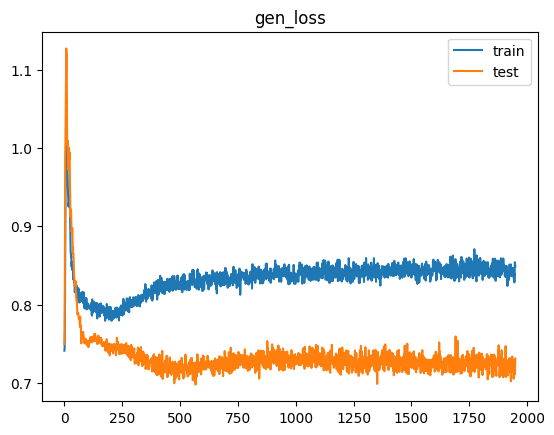

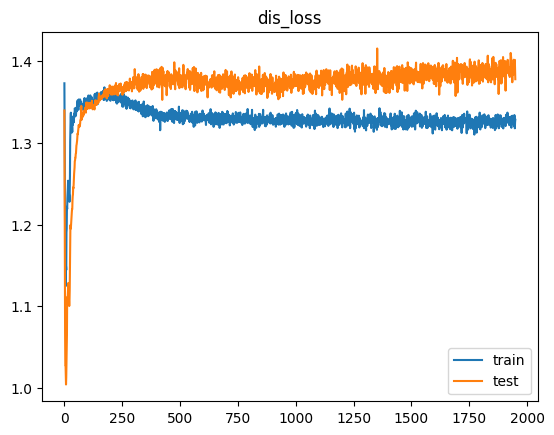

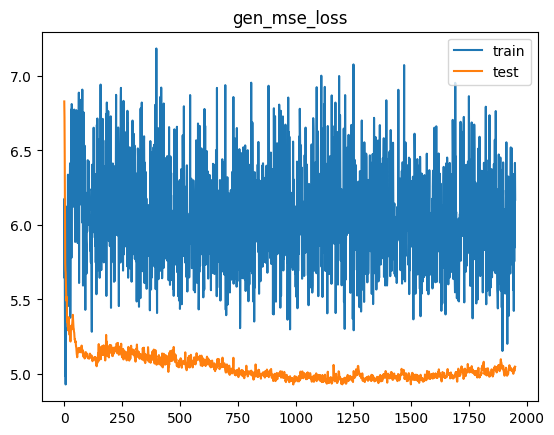

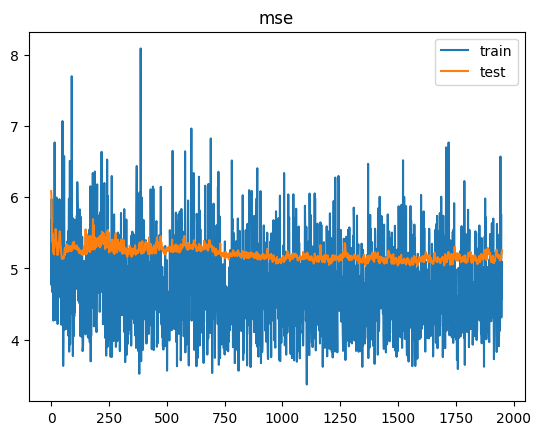

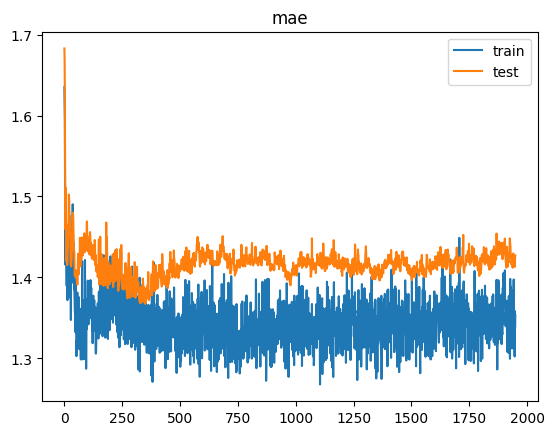

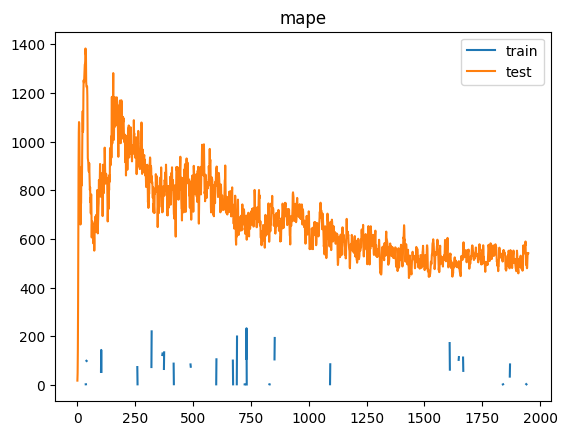

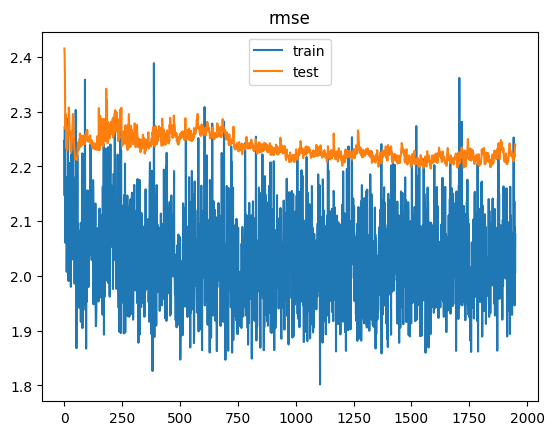

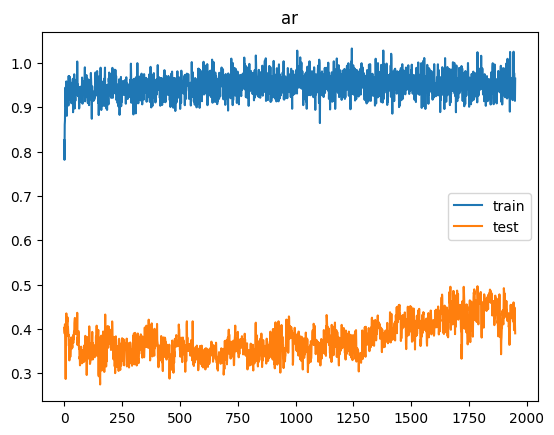

2/2 [==============================] - 1s 4ms/step


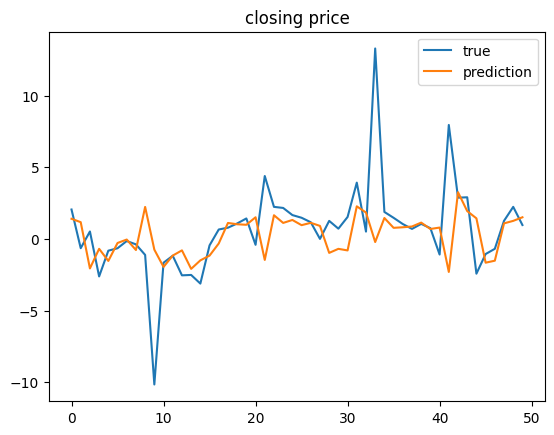

[MSE Baseline] train: 4.884709822077843  test: 4.988566607603537
Delta time with epochs = 1950: 0:31:16.755072


In [20]:
for epochs in [1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("dcbilstm_ffnn_epochs_{0}.h5".format(epochs))